# PARAMS

In [56]:
import numpy as np
import pandas as pd
import os
import xarray as xr
import seaborn as sns

from n0_config_params import *
from n0bis_config_analysis_functions import *
from n0ter_stats import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [74]:
sujet_list =                    np.array(['01PD','03VN','05LV','06EF','07PB','08DM','09TA','10BH',
                            '11FA','12BD','13FP','14MD','15LG','16GM','17JR','19TM','20TY','21ZV',
                            '23LF','24TJ','26MN','28NT','29SC','30AR','31HJ','32CM','33MA'])

sujet_list_rev =                np.array(['PD01','VN03','LV05','EF06','PB07','DM08','TA09','BH10',
                            'FA11','BD12','FP13','MD14','LG15','GM16','JR17','TM19','TY20','ZV21',
                            'LF23','TJ24','MN26','NT28','SC29','AR30','HJ31','CM32','MA33'])

# ['02MJ', '18SE', '22DI', '27BD'] signal problems
# ['04GB', '25DF'] dypnea induction failed

sujet_best_list =               np.array(['BD12','CM32','FA11','GM16','HJ31','JR17','MA33','MN26',
                            'PD01','SC29','TA09','TJ24','TM19','VN03','ZV21'])
sujet_best_list_rev =           np.array(['12BD','32CM','11FA','16GM','31HJ','17JR','33MA','26MN',
                            '01PD','29SC','09TA','24TJ','19TM','03VN','21ZV'])

sujet_no_respond =              np.array(['LV05','EF06','PB07','DM08','BH10','FP13','MD14','LG15',
                            'TY20','LF23','NT28','AR30'])
sujet_no_respond_rev =          np.array(['05LV','06EF','07PB','08DM','10BH','13FP','14MD','15LG',
                            '20TY','23LF','28NT','30AR'])


session_list = np.array(['o', '+', '-'])
cond_list = np.array(['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2'])

metric_paris = ['Ttot', 'VT', 'Ve']

# LOAD DATA PARIS

In [58]:
os.chdir(os.path.join(path_data, 'respi_detection'))
df_respi_paris = pd.read_excel('OLFADYS_alldata_mean.xlsx').query(f"sujet in {sujet_list.tolist()}").reset_index(drop=True)


for row_i in range(df_respi_paris.shape[0]):
    if df_respi_paris.iloc[row_i]['odor'] == 'p':
        df_respi_paris['odor'][row_i] = '+'
    if df_respi_paris.iloc[row_i]['odor'] == 'n':
        df_respi_paris['odor'][row_i] = '-'

df_respi_paris = df_respi_paris.rename(columns={"odor": "session"})

sujet_sel_mask = []

for row_i in range(df_respi_paris.shape[0]):

    if df_respi_paris['sujet'].iloc[row_i] in sujet_best_list_rev:

        sujet_sel_mask.append('YES')

    else:

        sujet_sel_mask.append('NO')

df_respi_paris['select_best'] = sujet_sel_mask

for nan_i in np.where(df_respi_paris['PetCO2'].isnull().values)[0]:
    odor = df_respi_paris['session'][nan_i]
    cond = df_respi_paris['cond'][nan_i]
    nan_replace_petCO2 = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")['PetCO2'].median()
    nan_replace_VAS_A = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")['VAS_A'].median()
    nan_replace_VAS_S = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")['VAS_S'].median()
    nan_replace_Ttot = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")['Ttot'].median()
    nan_replace_VT = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")['VT'].median()
    nan_replace_Ve = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")['Ve'].median()
    df_respi_paris['PetCO2'][nan_i] = nan_replace_petCO2 
    df_respi_paris['VAS_A'][nan_i] = nan_replace_VAS_A 
    df_respi_paris['VAS_S'][nan_i] = nan_replace_VAS_S 
    df_respi_paris['Ttot'][nan_i] = nan_replace_Ttot
    df_respi_paris['VT'][nan_i] = nan_replace_VT
    df_respi_paris['Ve'][nan_i] = nan_replace_Ve

for nan_i in np.where(df_respi_paris['VT'].isnull().values)[0]:
    odor = df_respi_paris['session'][nan_i]
    cond = df_respi_paris['cond'][nan_i]
    nan_replace_VT = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")['VT'].median()
    nan_replace_Ve = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")['Ve'].median()
    df_respi_paris['VT'][nan_i] = nan_replace_VT
    df_respi_paris['Ve'][nan_i] = nan_replace_Ve

df_respi_paris

/tmp/ipykernel_2961/2725853819.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respi_paris['odor'][row_i] = '+'
/tmp/ipykernel_2961/2725853819.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respi_paris['odor'][row_i] = '-'
/tmp/ipykernel_2961/2725853819.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respi_paris['PetCO2'][nan_i] = nan_replace_petCO2
/tmp/ipykernel_2961/2725853819.py:37: SettingWithCopyWarning: 
A

sujet     cond session        TI        Te      Ttot         BF        VT  \
0    01PD  FR_CV_1       o  2.393846  3.008462  5.402308  11.837491  0.562511   
1    03VN  FR_CV_1       o  2.692766  3.617660  6.310426   9.545615  1.157782   
2    05LV  FR_CV_1       o  2.435536  2.843929  5.279464  11.626768  0.567217   
3    06EF  FR_CV_1       o  1.649000  2.068875  3.717875  16.298862  0.493380   
4    07PB  FR_CV_1       o  1.304717  1.504906  2.809623  21.771218  0.649400   
..    ...      ...     ...       ...       ...       ...        ...       ...   
319  29SC  FR_CV_2       -  1.671310  1.872262  3.543571  17.294815  0.731305   
320  30AR  FR_CV_2       -  1.427614  1.934886  3.362500  18.019880  0.577633   
321  31HJ  FR_CV_2       -  1.783425  2.277945  4.061370  14.811920  0.796478   
322  32CM  FR_CV_2       -  1.853947  2.058684  3.912632  15.556511  0.727632   
323  33MA  FR_CV_2       -  2.374615  2.178154  4.552769  13.657869  0.505092   

            Ve     VT_Ti    Ti_Ttot     PRESS     PetCO2  VAS_S  VAS_A  \
0     6.121682  0.229809  44.118335 -1.814150  30.619312    NaN    NaN   
1    11.013808  0.430079  42.714931 -4.095677  41.109311    NaN    NaN   
2     6.446338  0.233685  46.081250 -2.445666  38.509328    NaN    NaN   
3     8.047073  0.300471  44.566152 -2.818668  31.008479    NaN    NaN   
4    13.772378  0.494112  46.423333 -4.087813  37.777710    NaN    NaN   
..         ...       ...        ...       ...        ...    ...    ...   
319  12.333833  0.435322  47.230747 -4.246468  37.879662    NaN    NaN   
320  10.280461  0.403985  42.511473 -3.152908  36.640867    NaN    NaN   
321  11.779759  0.446903  43.984879 -3.927595  37.493090    NaN    NaN   
322  11.142399  0.391526  47.546784 -3.904454  37.805881    NaN    NaN   
323   6.674845  0.216982  51.719452 -2.272483  34.220138    NaN    NaN   

    select_best  
0           YES  
1           YES  
2            NO  
3            NO  
4            NO  
..          ...  
319         YES  
320          NO  
321         YES  
322         YES  
323         YES  

[324 rows x 16 columns]

# LOAD DATA LYON

In [59]:
metric_tot = ['inspi_index', 'expi_index', 'next_inspi_index',
       'inspi_time', 'expi_time', 'next_inspi_time', 'cycle_duration',
       'inspi_duration', 'expi_duration', 'cycle_freq', 'inspi_volume',
       'expi_volume', 'total_amplitude', 'inspi_amplitude', 'expi_amplitude',
       'select']

metric_list = ['inspi_duration', 'expi_duration', 'cycle_freq', 'total_amplitude']

In [60]:
xr_dict = {'sujet' : sujet_list, 'cond' : cond_list, 'session' : session_list, 'metric' : metric_list, 'time' : np.arange(1000)}
xr_data = np.zeros((sujet_list.shape[0], cond_list.shape[0], session_list.shape[0], len(metric_list), 1000))
xr_respi_allsig = xr.DataArray(xr_data, dims=xr_dict.keys(), coords=xr_dict.values())

In [61]:
zscore = {}

for sujet in sujet_list:

    zscore[sujet] = {}

    os.chdir(os.path.join(path_results, sujet,'RESPI'))

    for session_i in session_list:
         
        zscore[sujet][session_i] = {}

        for metric in metric_list:

            zscore[sujet][session_i][metric] = {}

            x = np.array([])

            for cond in cond_list:

                file_df = f'{sujet}_{cond}_{session_i}_respfeatures.xlsx'
                respi_vals = pd.read_excel(file_df)[metric].values

                f = scipy.interpolate.interp1d(np.linspace(0, 1, respi_vals.shape[0]), respi_vals, kind='linear')
                respi_vals_resampled = f(np.linspace(0, 1, 1000))

                x = np.concatenate((x, respi_vals_resampled), axis=0)

            zscore[sujet][session_i][metric]['mean'] = x.mean()
            zscore[sujet][session_i][metric]['std'] = x.std()



In [62]:
# sujet = 'PD01'
# session_i = 'o'
# cond = 'FR_CV1'

for sujet in sujet_list:

    os.chdir(os.path.join(path_results, sujet,'RESPI'))

    for cond in cond_list:

        for session_i in session_list:

            file_df = f'{sujet}_{cond}_{session_i}_respfeatures.xlsx'
            raw_df = pd.read_excel(file_df)

            for metric in metric_list:

                respi_vals = raw_df[metric].values

                f = scipy.interpolate.interp1d(np.linspace(0, 1, respi_vals.shape[0]), respi_vals, kind='linear')
                respi_vals_resampled = f(np.linspace(0, 1, 1000))

                z_respi_vals_resampled = (respi_vals_resampled - zscore[sujet][session_i][metric]['mean']) / zscore[sujet][session_i][metric]['std']

                xr_respi_allsig.loc[sujet, cond, session_i, metric, :] = z_respi_vals_resampled


In [63]:
for sujet_i, sujet in enumerate(sujet_list):

    os.chdir(os.path.join(path_results, sujet,'RESPI'))

    for cond_i, cond in enumerate(cond_list):

        for session_i, session in enumerate(session_list):

            df_raw = pd.read_excel(f'{sujet}_{cond}_{session}_respfeatures.xlsx').query("select == 1").drop(columns=['Unnamed: 0', 'select'])
            df_raw_cols = df_raw.columns.values
            raw_mean = df_raw.mean(axis=0).values.reshape(1,-1)
            df_mean_i = pd.DataFrame(data=raw_mean, columns=df_raw_cols)
            
            df_header = pd.DataFrame({'sujet' : [sujet], 'cond' : [cond], 'session' : [session]})
            df_mean_i = pd.concat((df_header, df_mean_i), axis=1)

            if sujet_i+cond_i+session_i == 0:
                df_allsujet = df_mean_i
            else:
                df_allsujet = pd.concat((df_allsujet, df_mean_i), axis=0)

In [64]:
df_allsujet

sujet     cond session   inspi_index    expi_index  next_inspi_index  \
0   01PD  FR_CV_1       o  73751.459459  75329.459459      77476.000000   
0   01PD  FR_CV_1       +  76699.627907  77912.302326      79888.488372   
0   01PD  FR_CV_1       -  78219.350877  79137.543860      80691.210526   
0   01PD     MECA       o  69872.000000  71375.489796      72721.469388   
0   01PD     MECA       +  64886.285714  66152.333333      68213.309524   
..   ...      ...     ...           ...           ...               ...   
0   33MA      CO2       +  75881.157895  77113.666667      78363.368421   
0   33MA      CO2       -  76045.350877  77245.912281      78510.192982   
0   33MA  FR_CV_2       o  75603.927711  76434.614458      77331.783133   
0   33MA  FR_CV_2       +  72756.820513  73615.064103      74564.410256   
0   33MA  FR_CV_2       -  74984.274194  76028.967742      77266.967742   

    inspi_time   expi_time  next_inspi_time  cycle_duration  inspi_duration  \
0   147.502919  150.658919       154.952000        7.449081        3.156000   
0   153.399256  155.824605       159.776977        6.377721        2.425349   
0   156.438702  158.275088       161.382421        4.943719        1.836386   
0   139.744000  142.750980       145.442939        5.698939        3.006980   
0   129.772571  132.304667       136.426619        6.654048        2.532095   
..         ...         ...              ...             ...             ...   
0   151.762316  154.227333       156.726737        4.964421        2.465018   
0   152.090702  154.491825       157.020386        4.929684        2.401123   
0   151.207855  152.869229       154.663566        3.455711        1.661373   
0   145.513641  147.230128       149.128821        3.615179        1.716487   
0   149.968548  152.057935       154.533935        4.565387        2.089387   

    expi_duration  cycle_freq  inspi_volume  expi_volume  total_amplitude  \
0        4.293081    0.148122      2.265153     1.230680         1.539592   
0        3.952372    0.174074      1.942612     2.010978         2.176828   
0        3.107333    0.217296      1.494659     1.383365         1.907390   
0        2.691959    0.186994      1.750262     1.057401         1.483738   
0        4.121952    0.179841      2.323250     2.372798         2.505508   
..            ...         ...           ...          ...              ...   
0        2.499404    0.203683      3.579790     2.940018         3.882571   
0        2.528561    0.212464      3.763427     3.931167         4.878473   
0        1.794337    0.291934      1.757143     1.289387         2.511541   
0        1.898692    0.282535      2.220878     1.648984         3.133965   
0        2.476000    0.229212      1.829135     1.675984         2.453490   

    inspi_amplitude  expi_amplitude  
0          0.875587        0.664006  
0          1.025665        1.151163  
0          1.050503        0.856887  
0          0.705014        0.778724  
0          1.174980        1.330528  
..              ...             ...  
0          1.984680        1.897891  
0          2.299870        2.578604  
0          1.344945        1.166597  
0          1.679703        1.454262  
0          1.236856        1.216634  

[324 rows x 18 columns]

In [65]:
df_allsujet = df_allsujet[['sujet', 'cond', 'session']+metric_list]

In [66]:
sujet_sel_mask = []

for row_i in range(df_allsujet.shape[0]):

    if df_allsujet['sujet'].iloc[row_i] in sujet_best_list_rev:

        sujet_sel_mask.append('YES')

    else:

        sujet_sel_mask.append('NO')

df_allsujet['select_best'] = sujet_sel_mask
df_allsujet

/tmp/ipykernel_2961/785831422.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsujet['select_best'] = sujet_sel_mask


sujet     cond session  inspi_duration  expi_duration  cycle_freq  \
0   01PD  FR_CV_1       o        3.156000       4.293081    0.148122   
0   01PD  FR_CV_1       +        2.425349       3.952372    0.174074   
0   01PD  FR_CV_1       -        1.836386       3.107333    0.217296   
0   01PD     MECA       o        3.006980       2.691959    0.186994   
0   01PD     MECA       +        2.532095       4.121952    0.179841   
..   ...      ...     ...             ...            ...         ...   
0   33MA      CO2       +        2.465018       2.499404    0.203683   
0   33MA      CO2       -        2.401123       2.528561    0.212464   
0   33MA  FR_CV_2       o        1.661373       1.794337    0.291934   
0   33MA  FR_CV_2       +        1.716487       1.898692    0.282535   
0   33MA  FR_CV_2       -        2.089387       2.476000    0.229212   

    total_amplitude select_best  
0          1.539592         YES  
0          2.176828         YES  
0          1.907390         YES  
0          1.483738         YES  
0          2.505508         YES  
..              ...         ...  
0          3.882571         YES  
0          4.878473         YES  
0          2.511541         YES  
0          3.133965         YES  
0          2.453490         YES  

[324 rows x 8 columns]

In [67]:
df_allsujet_VS = df_allsujet.copy()

df_allsujet_VS = df_allsujet_VS[df_allsujet_VS['cond'] != 'FR_CV_2']

for row_i in range(df_allsujet_VS.shape[0]):

    if df_allsujet_VS['cond'].iloc[row_i] == 'FR_CV_1':

        df_allsujet_VS['cond'].iloc[row_i] = 'VS'

    else:

        continue

df_allsujet_VS

/tmp/ipykernel_2961/3233682091.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsujet_VS['cond'].iloc[row_i] = 'VS'


sujet  cond session  inspi_duration  expi_duration  cycle_freq  \
0   01PD    VS       o        3.156000       4.293081    0.148122   
0   01PD    VS       +        2.425349       3.952372    0.174074   
0   01PD    VS       -        1.836386       3.107333    0.217296   
0   01PD  MECA       o        3.006980       2.691959    0.186994   
0   01PD  MECA       +        2.532095       4.121952    0.179841   
..   ...   ...     ...             ...            ...         ...   
0   33MA  MECA       +        1.831405       2.030541    0.268473   
0   33MA  MECA       -        1.557313       2.791094    0.275105   
0   33MA   CO2       o        2.399967       2.244754    0.219786   
0   33MA   CO2       +        2.465018       2.499404    0.203683   
0   33MA   CO2       -        2.401123       2.528561    0.212464   

    total_amplitude select_best  
0          1.539592         YES  
0          2.176828         YES  
0          1.907390         YES  
0          1.483738         YES  
0          2.505508         YES  
..              ...         ...  
0          2.946374         YES  
0          0.566333         YES  
0          5.655984         YES  
0          3.882571         YES  
0          4.878473         YES  

[243 rows x 8 columns]

In [68]:
# df_allsujet_VS = df_allsujet.copy()

# for row_i in range(df_allsujet_VS.shape[0]):

#     if df_allsujet_VS['cond'].iloc[row_i] in ['FR_CV_1', 'FR_CV_2']:

#         df_allsujet_VS['cond'].iloc[row_i] = 'VS'

#     else:

#         continue

# df_allsujet_VS

In [69]:
os.chdir(os.path.join(path_precompute, 'allsujet', 'ERP'))

xr_respi = xr.open_dataarray(f'allsujet_ERP_respi.nc')

In [70]:
dict_data = {'sujet' : [], 'cond' : [], 'session' : [], 'cycle_freq' : [], 'amplitude' : [], 'select_best' : []}

for sujet_i, sujet in enumerate(sujet_list):

    for cond_i, cond in enumerate(cond_list):

        for odor_i, odor in enumerate(odor_list):

            respi_mean = xr_respi.loc[sujet, odor, cond, :]
            respi_mean = respi_mean - respi_mean.mean()
            zero_crossings = np.where(np.diff(np.sign(respi_mean)))[0]
            zero_crossings_sec = xr_respi['times'][zero_crossings]
            cycle_freq = float(1/(np.abs(zero_crossings_sec[0])+zero_crossings_sec[-1]))
            amplitude = float(respi_mean.max() - respi_mean.min())

            dict_data['sujet'].append(sujet)
            dict_data['cond'].append(cond)
            dict_data['session'].append(odor)
            dict_data['cycle_freq'].append(cycle_freq)
            dict_data['amplitude'].append(amplitude)

            if sujet in sujet_best_list_rev:
                select = 'YES'
            else:
                select = 'NO'

            dict_data['select_best'].append(select)

df_respi_mean_stats = pd.DataFrame(dict_data)
df_respi_mean_stats

sujet     cond session  cycle_freq  amplitude select_best
0    01PD  FR_CV_1       o    0.135355   1.705417         YES
1    01PD  FR_CV_1       +    0.187056   1.749410         YES
2    01PD  FR_CV_1       -    0.224215   1.614191         YES
3    01PD     MECA       o    0.181620   1.701739         YES
4    01PD     MECA       +    0.186081   1.786352         YES
..    ...      ...     ...         ...        ...         ...
319  33MA      CO2       +    0.204499   3.191800         YES
320  33MA      CO2       -    0.219298   4.682795         YES
321  33MA  FR_CV_2       o    0.145943   1.721272         YES
322  33MA  FR_CV_2       +    0.143926   2.578612         YES
323  33MA  FR_CV_2       -    0.233863   2.182943         YES

[324 rows x 6 columns]

# GENERAL FIG RESPI

In [159]:
xr_respi['sujet']

<xarray.DataArray 'sujet' (sujet: 29)>
array(['01PD', '03VN', '04GB', '05LV', '06EF', '07PB', '08DM', '09TA', '10BH',
       '11FA', '12BD', '13FP', '14MD', '15LG', '16GM', '17JR', '19TM', '20TY',
       '21ZV', '23LF', '24TJ', '25DF', '26MN', '28NT', '29SC', '30AR', '31HJ',
       '32CM', '33MA'], dtype=object)
Coordinates:
  * sujet    (sujet) object '01PD' '03VN' '04GB' '05LV' ... '31HJ' '32CM' '33MA'

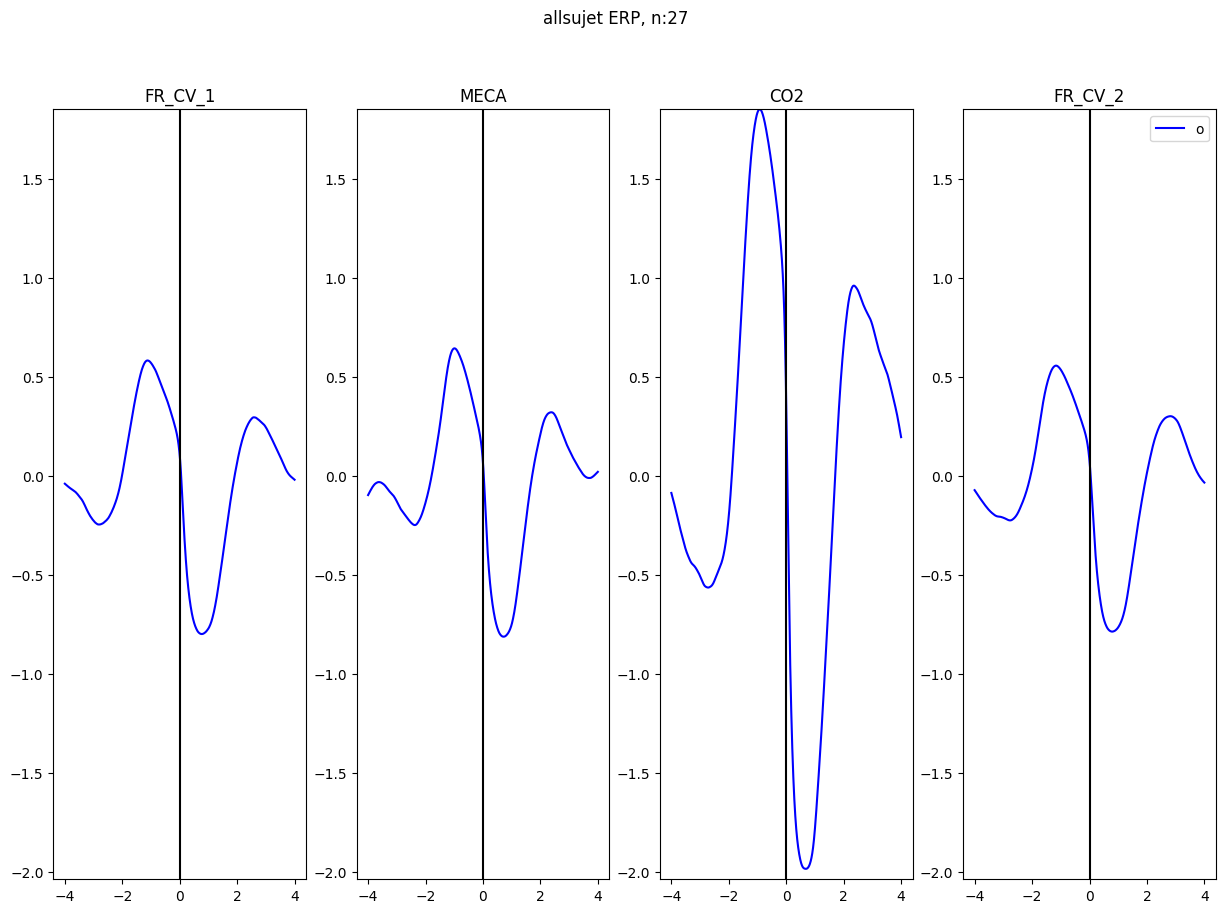

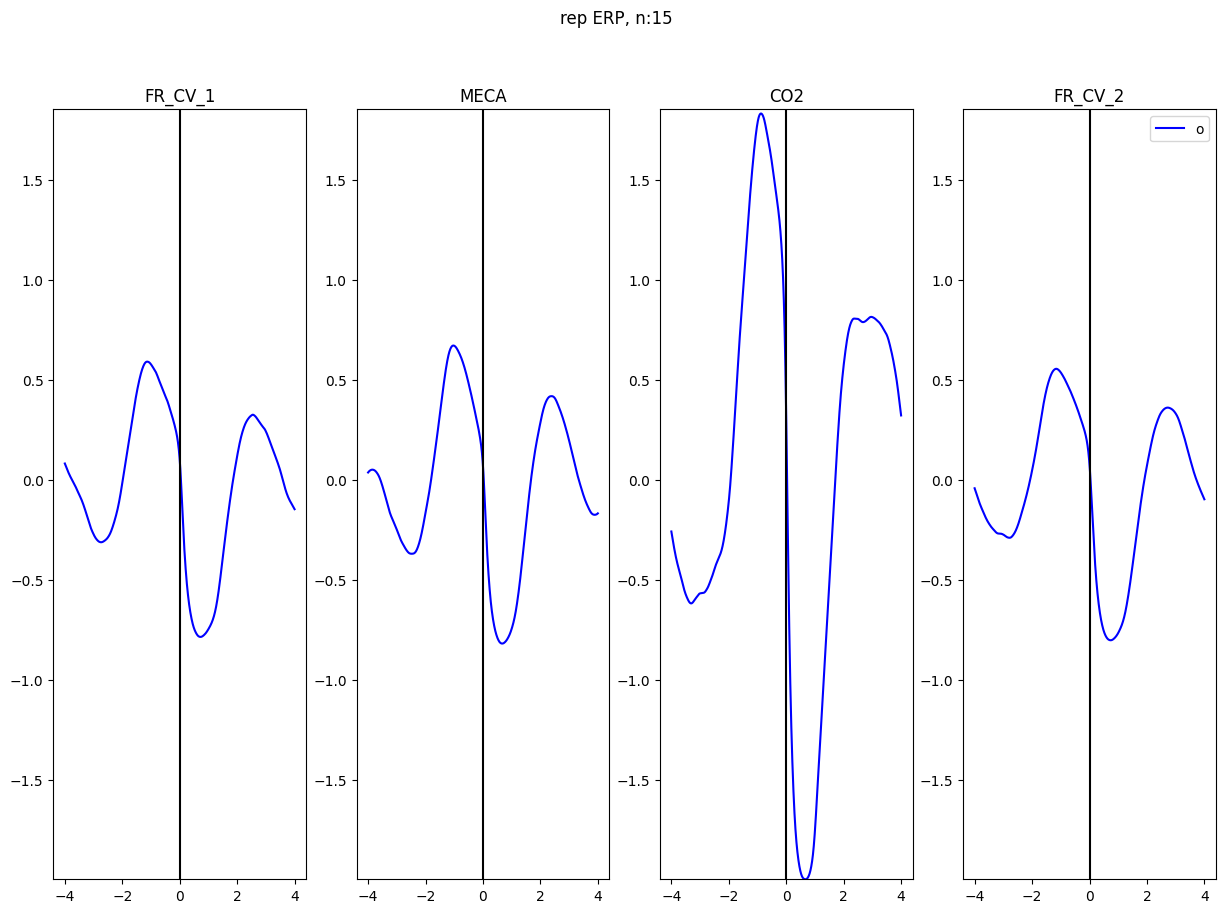

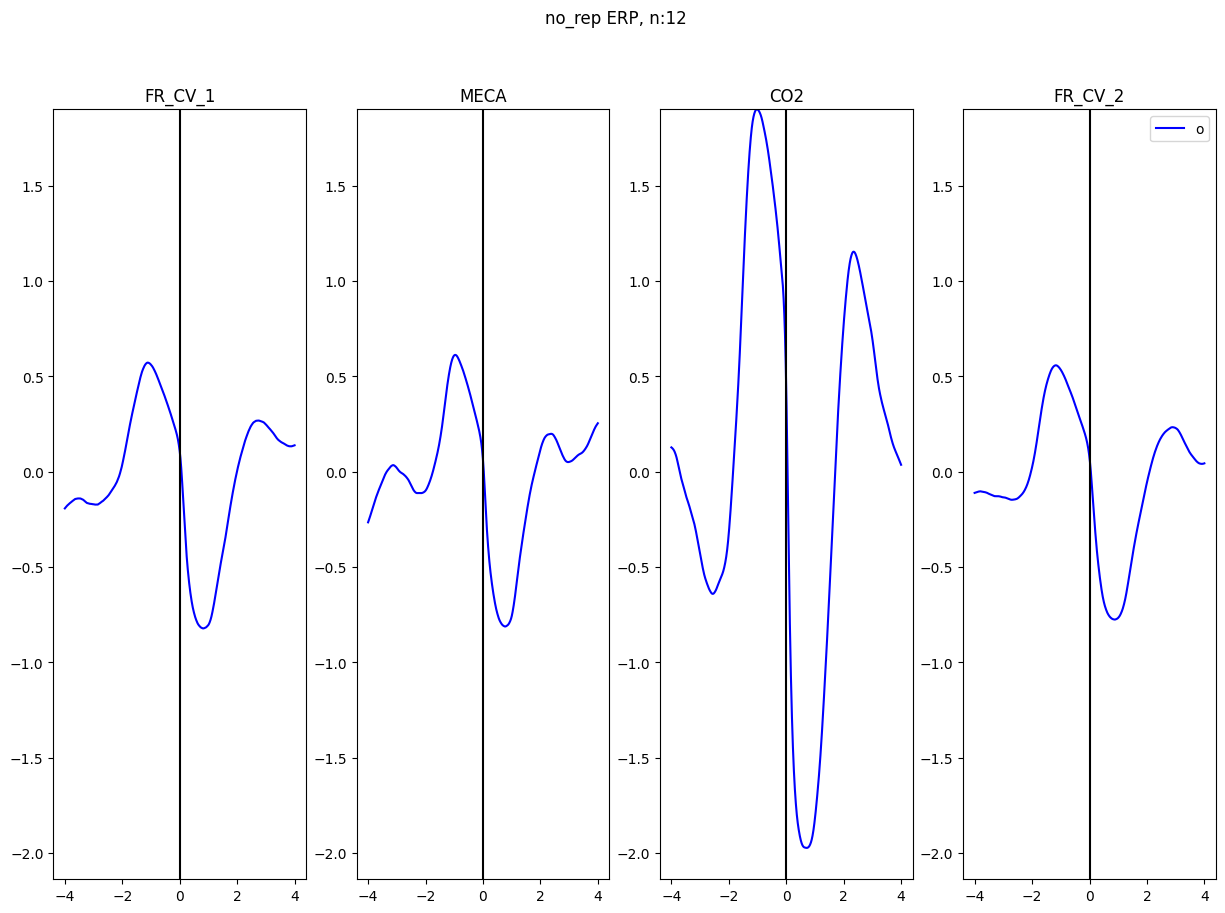

In [75]:
sujet_group = ['allsujet', 'rep', 'no_rep']

t_start_PPI = -4
t_stop_PPI = 4

time_vec = np.arange(t_start_PPI, t_stop_PPI, 1/srate)

for group in sujet_group:

    if group == 'allsujet':
        xr_data = xr_respi.loc[sujet_list]
    if group == 'rep':
        xr_data = xr_respi.loc[sujet_best_list_rev]
    if group == 'no_rep':
        xr_data = xr_respi.loc[sujet_no_respond_rev]

    max = (xr_data.mean('sujet').values).max()
    min = (xr_data.mean('sujet').values).min()

    fig, axs = plt.subplots(ncols=len(conditions), figsize=(15,10))

    for cond_i, cond in enumerate(conditions):

        ax = axs[cond_i]

        ax.set_title(f"{cond}")

        ax.plot(time_vec, xr_data.loc[:, 'o', cond, :].mean('sujet'), label=f'o', color='b')

        # ax.plot(time_vec, xr_data.loc[:, 'o', cond, :].median('sujet'), label=f'o', color='b')
        # ax.plot(time_vec, xr_data.loc[:, '-', cond, :].median('sujet'), label=f'-', color='r')
        # ax.plot(time_vec, xr_data.loc[:, '+', cond, :].median('sujet'), label=f'+', color='g')

        ax.set_ylim(min, max)

        ax.vlines(0, ymin=min, ymax=max, color='k')

    plt.legend()
    
    plt.suptitle(f"{group} ERP, n:{xr_data['sujet'].shape[0]}")

    plt.show()

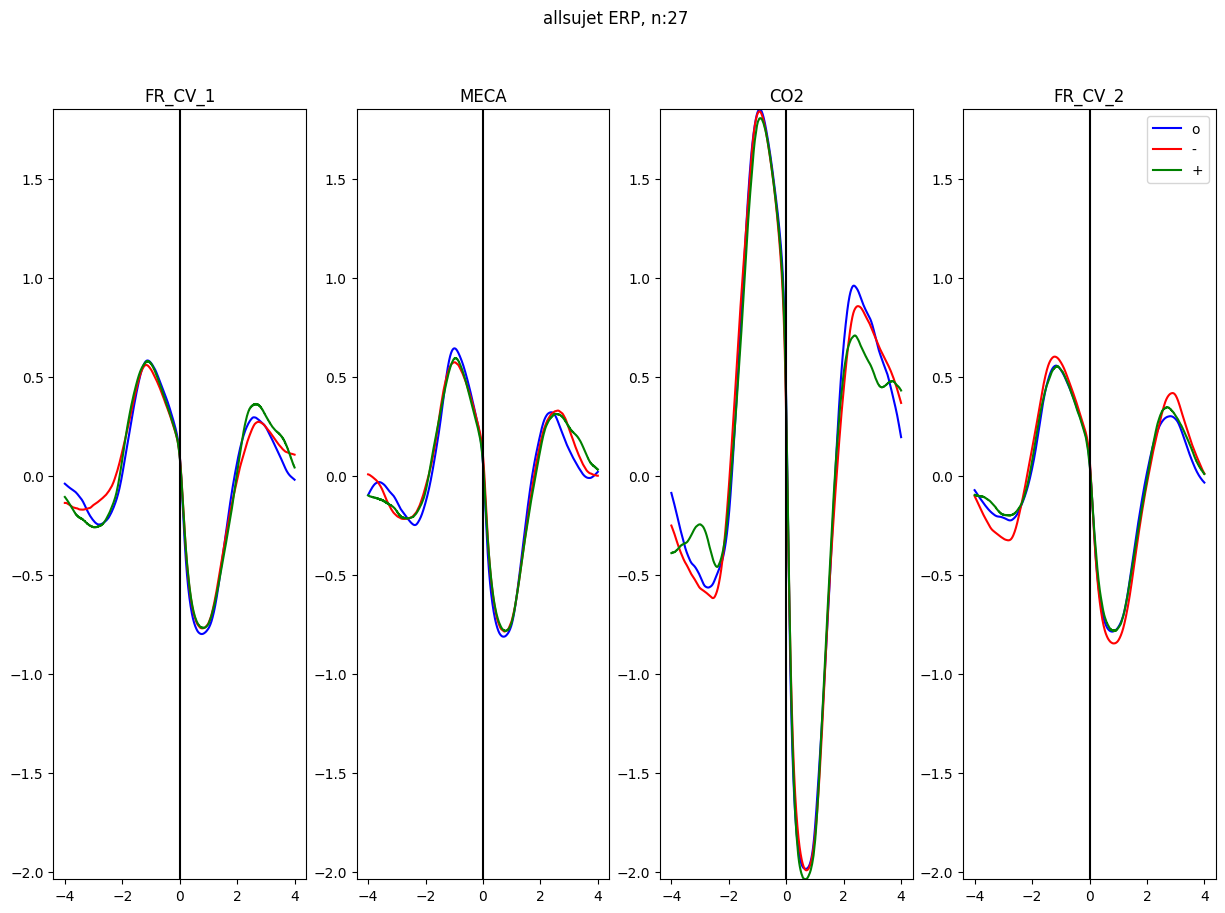

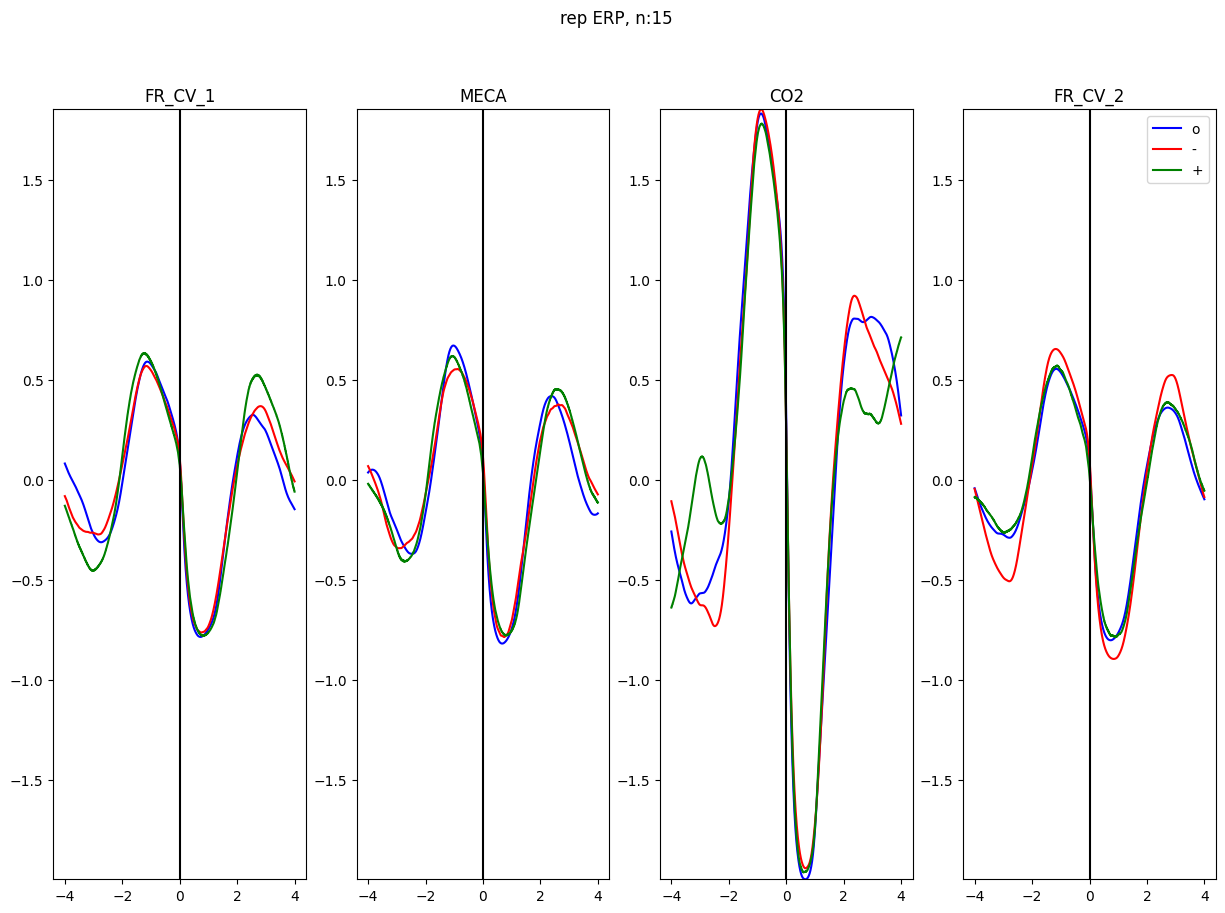

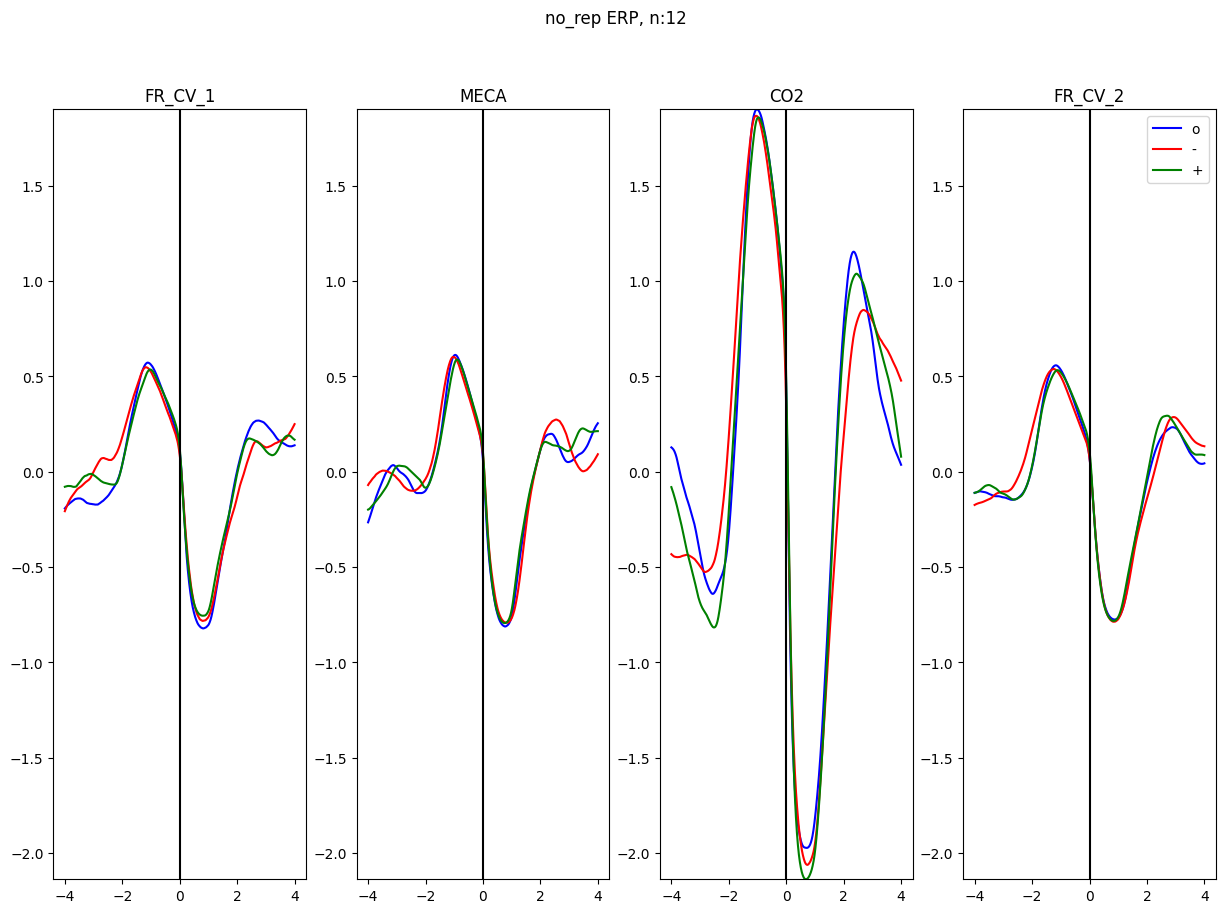

In [76]:
sujet_group = ['allsujet', 'rep', 'no_rep']

t_start_PPI = -4
t_stop_PPI = 4

time_vec = np.arange(t_start_PPI, t_stop_PPI, 1/srate)

for group in sujet_group:

    if group == 'allsujet':
        xr_data = xr_respi.loc[sujet_list]
    if group == 'rep':
        xr_data = xr_respi.loc[sujet_best_list_rev]
    if group == 'no_rep':
        xr_data = xr_respi.loc[sujet_no_respond_rev]

    max = (xr_data.mean('sujet').values).max()
    min = (xr_data.mean('sujet').values).min()

    fig, axs = plt.subplots(ncols=len(conditions), figsize=(15,10))

    for cond_i, cond in enumerate(conditions):

        ax = axs[cond_i]

        ax.set_title(f"{cond}")

        ax.plot(time_vec, xr_data.loc[:, 'o', cond, :].mean('sujet'), label=f'o', color='b')
        ax.plot(time_vec, xr_data.loc[:, '-', cond, :].mean('sujet'), label=f'-', color='r')
        ax.plot(time_vec, xr_data.loc[:, '+', cond, :].mean('sujet'), label=f'+', color='g')

        # ax.plot(time_vec, xr_data.loc[:, 'o', cond, :].median('sujet'), label=f'o', color='b')
        # ax.plot(time_vec, xr_data.loc[:, '-', cond, :].median('sujet'), label=f'-', color='r')
        # ax.plot(time_vec, xr_data.loc[:, '+', cond, :].median('sujet'), label=f'+', color='g')

        ax.set_ylim(min, max)

        ax.vlines(0, ymin=min, ymax=max, color='k')

    plt.legend()
    
    plt.suptitle(f"{group} ERP, n:{xr_data['sujet'].shape[0]}")

    plt.show()

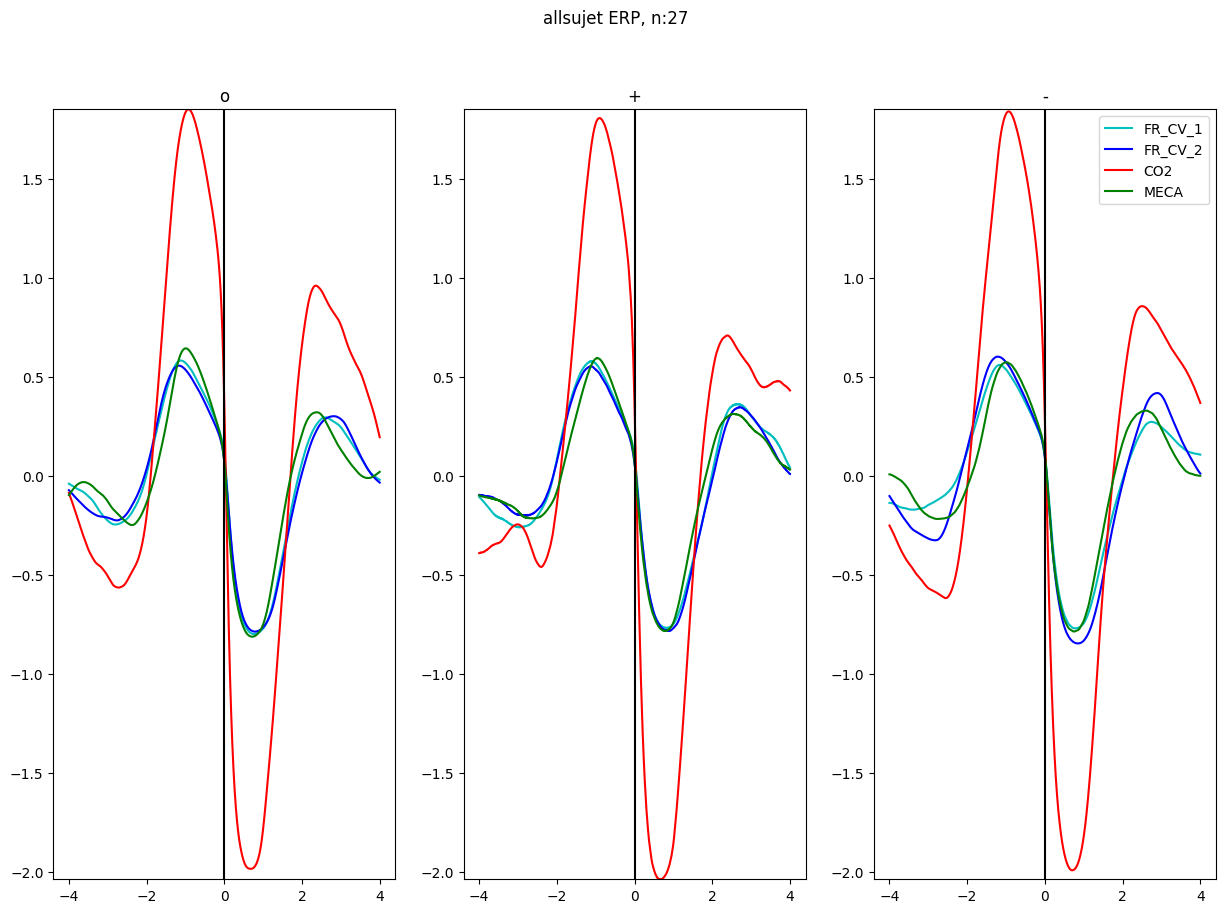

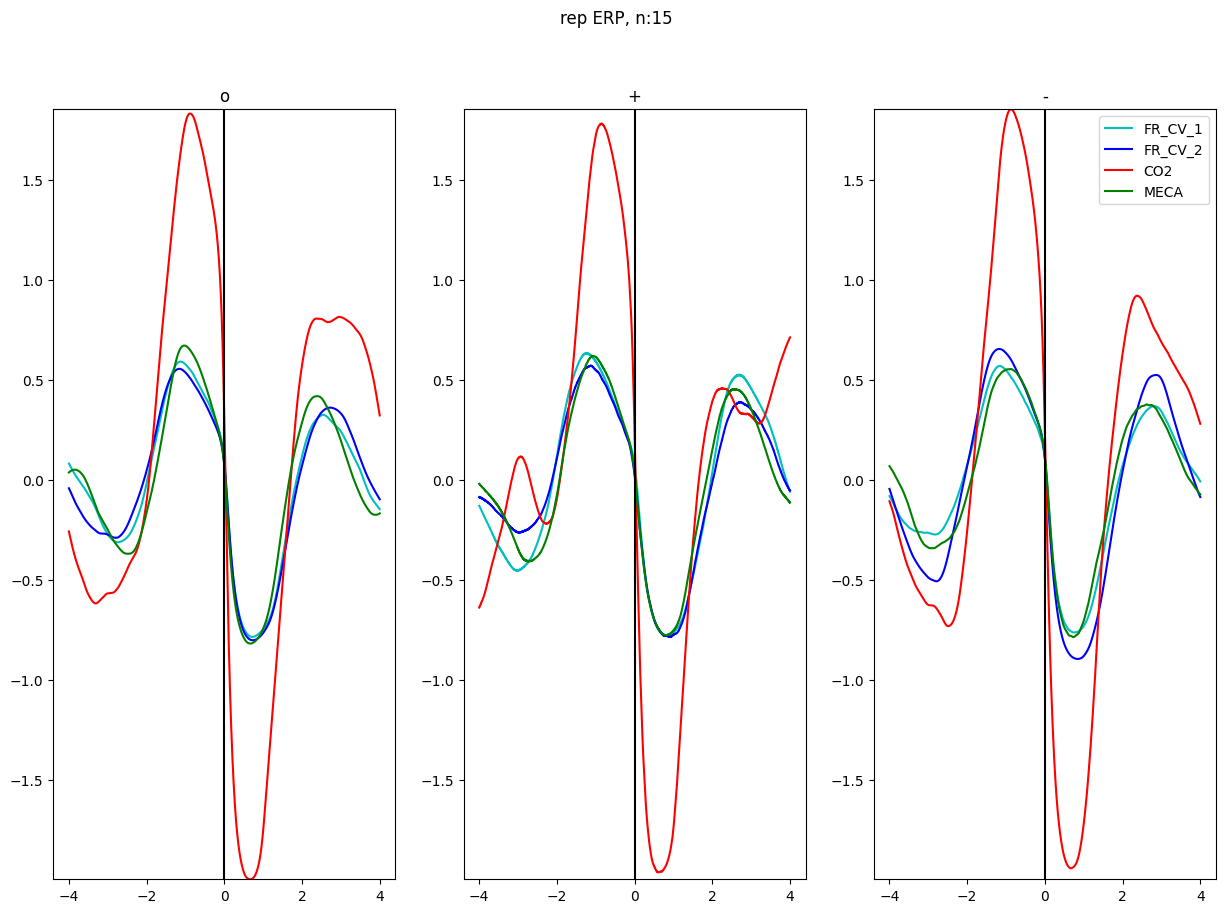

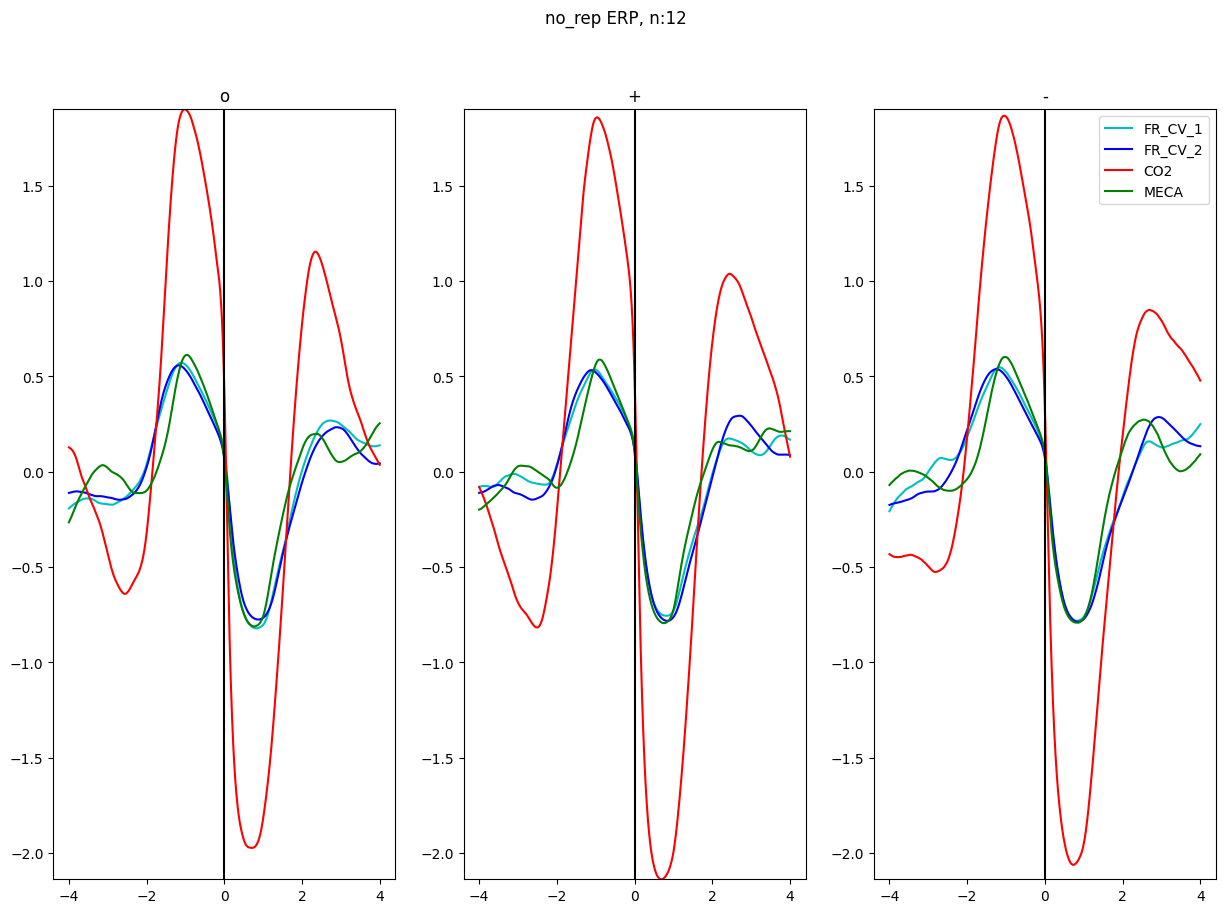

In [77]:
for group in sujet_group:

    if group == 'allsujet':
        xr_data = xr_respi.loc[sujet_list]
    if group == 'rep':
        xr_data = xr_respi.loc[sujet_best_list_rev]
    if group == 'no_rep':
        xr_data = xr_respi.loc[sujet_no_respond_rev]

    max = (xr_data.mean('sujet').values).max()
    min = (xr_data.mean('sujet').values).min()

    fig, axs = plt.subplots(ncols=len(odor_list), figsize=(15,10))

    for odor_i, odor in enumerate(odor_list):

        ax = axs[odor_i]

        ax.set_title(f"{odor}")

        ax.plot(time_vec, xr_data.loc[:, odor, 'FR_CV_1', :].mean('sujet'), label=f'FR_CV_1', color='c')
        ax.plot(time_vec, xr_data.loc[:,  odor, 'FR_CV_2', :].mean('sujet'), label=f'FR_CV_2', color='b')
        ax.plot(time_vec, xr_data.loc[:,  odor, 'CO2', :].mean('sujet'), label=f'CO2', color='r')
        ax.plot(time_vec, xr_data.loc[:,  odor, 'MECA', :].mean('sujet'), label=f'MECA', color='g')

        ax.set_ylim(min, max)

        ax.vlines(0, ymin=min, ymax=max, color='k')

    plt.legend()
    
    plt.suptitle(f"{group} ERP, n:{xr_data['sujet'].shape[0]}")

    plt.show()

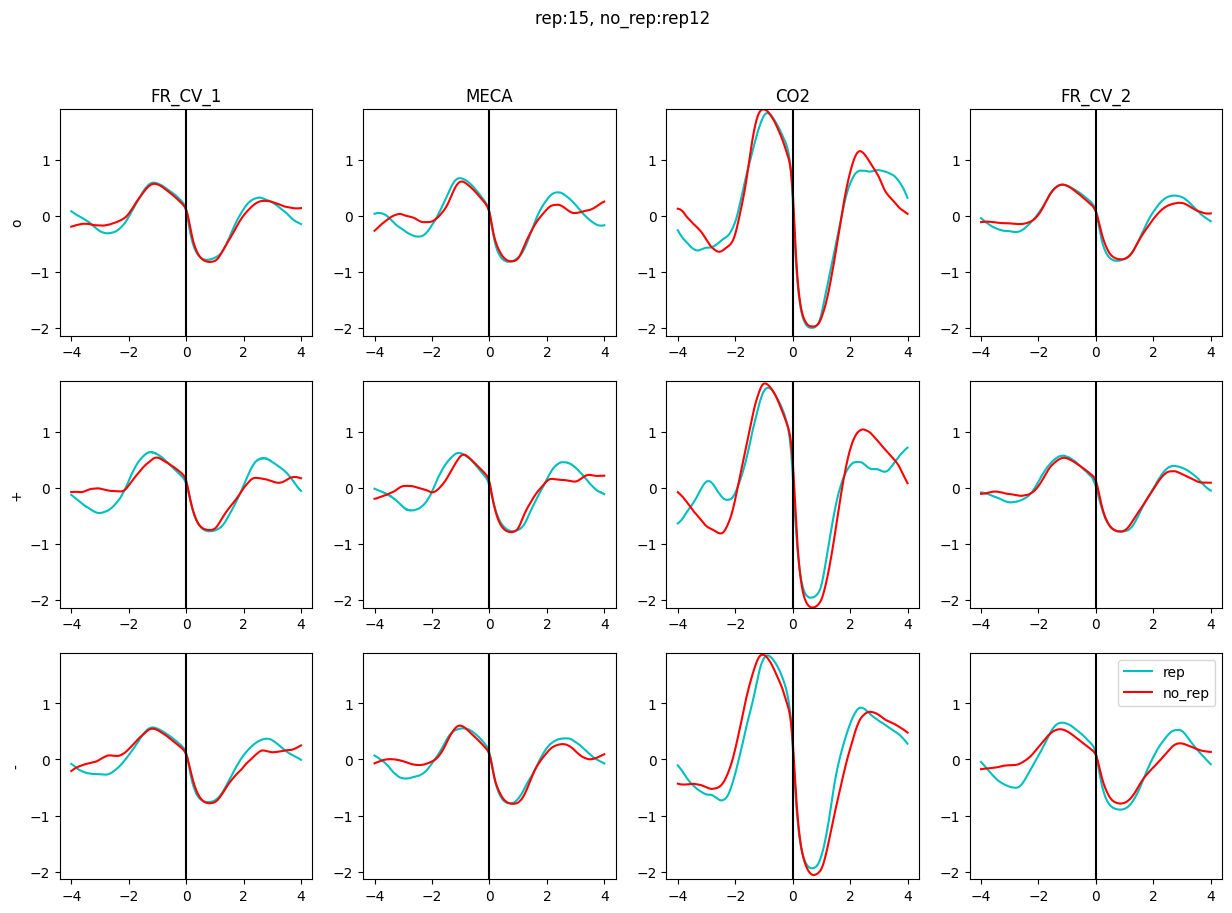

In [78]:
max = np.array([xr_respi.loc[sujet_best_list_rev].mean('sujet').values.max(), xr_respi.loc[sujet_no_respond_rev].mean('sujet').values.max()]).max()
min = np.array([xr_respi.loc[sujet_best_list_rev].mean('sujet').values.min(), xr_respi.loc[sujet_no_respond_rev].mean('sujet').values.min()]).min()

fig, axs = plt.subplots(ncols=len(conditions), nrows=len(odor_list), figsize=(15,10))

for odor_i, odor in enumerate(odor_list):

    for cond_i, cond in enumerate(conditions):

        ax = axs[odor_i, cond_i]

        if odor_i == 0:
            ax.set_title(f"{cond}")

        if cond_i == 0:
            ax.set_ylabel(f"{odor}")

        ax.plot(time_vec, xr_respi.loc[sujet_best_list_rev, odor, cond, :].mean('sujet'), label=f'rep', color='c')
        ax.plot(time_vec, xr_respi.loc[sujet_no_respond_rev, odor, cond, :].mean('sujet'), label=f'no_rep', color='r')

        ax.set_ylim(min, max)

        ax.vlines(0, ymin=min, ymax=max, color='k')

plt.legend()

plt.suptitle(f"rep:{xr_respi.loc[sujet_best_list_rev]['sujet'].shape[0]}, no_rep:rep{xr_respi.loc[sujet_no_respond_rev]['sujet'].shape[0]}")

plt.show()

# EFFECT COND

## all sujet

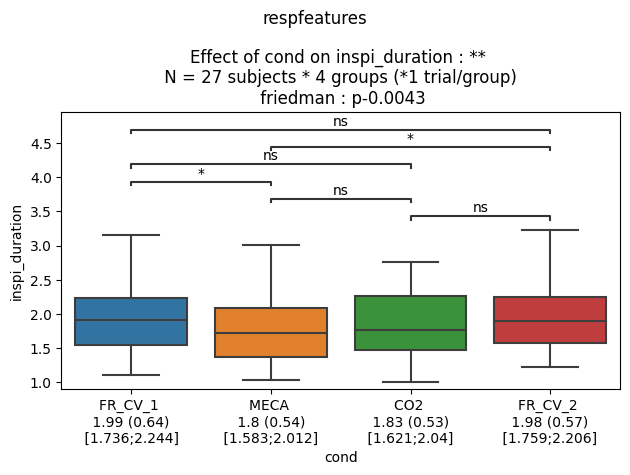

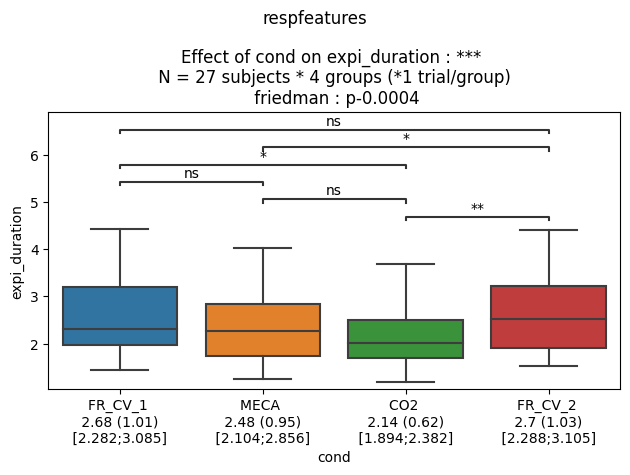

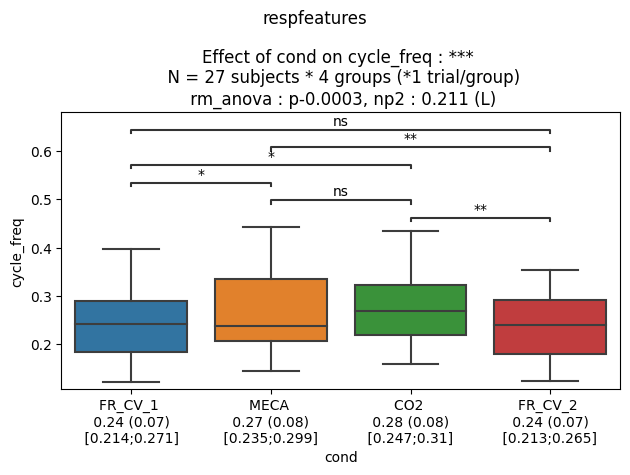

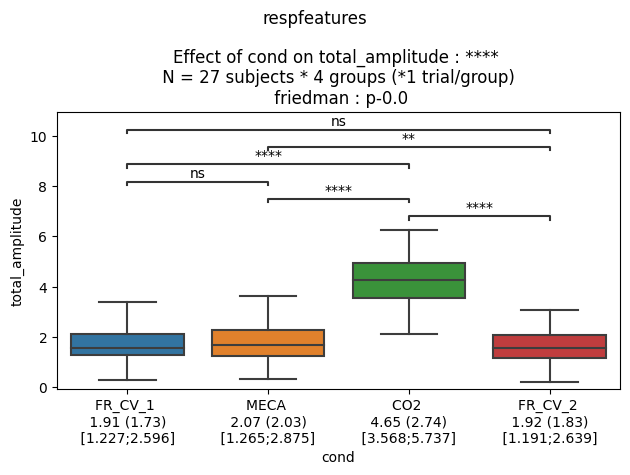

In [79]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet.query(f"session == 'o'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle('respfeatures')
    plt.tight_layout()

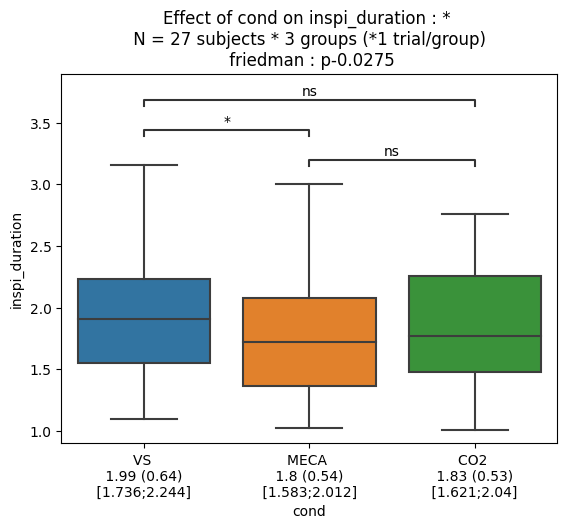

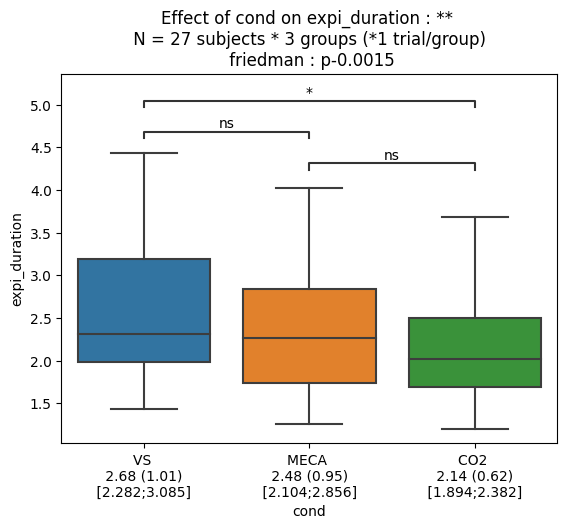

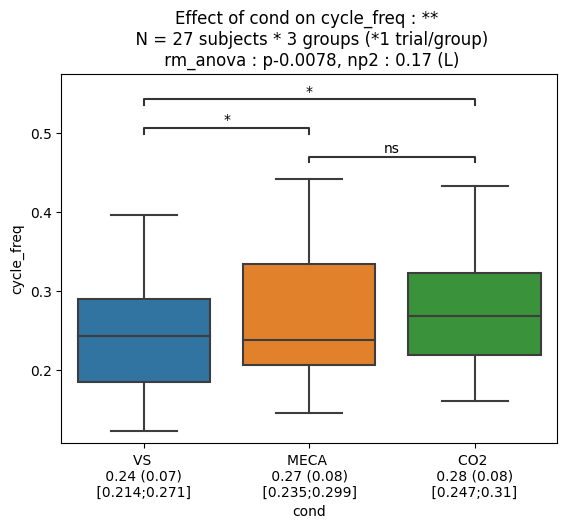

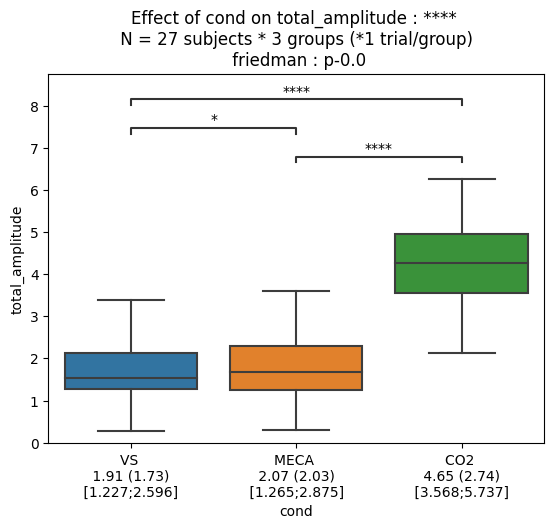

In [80]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet_VS.query(f"session == 'o'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

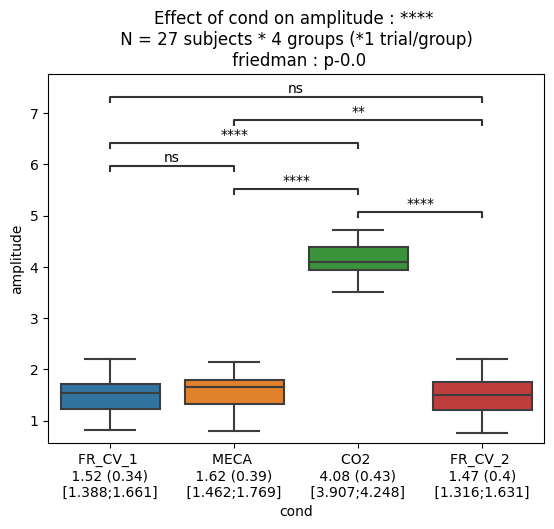

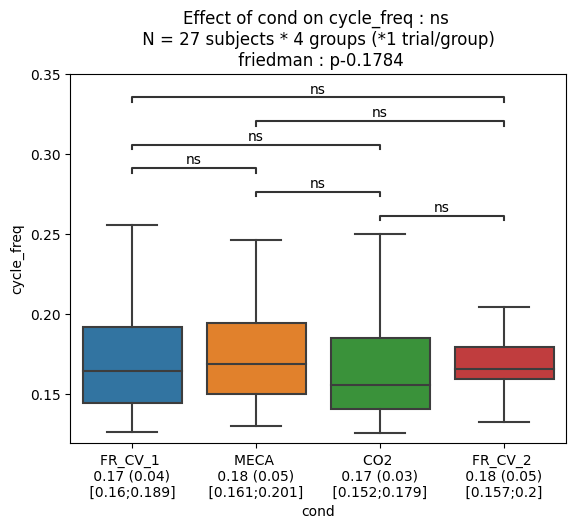

In [81]:
predictor = 'cond' 

for outcome_i in ['amplitude', 'cycle_freq']:

    fig, ax = plt.subplots()
    
    df_stats = df_respi_mean_stats.query(f"session == 'o'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

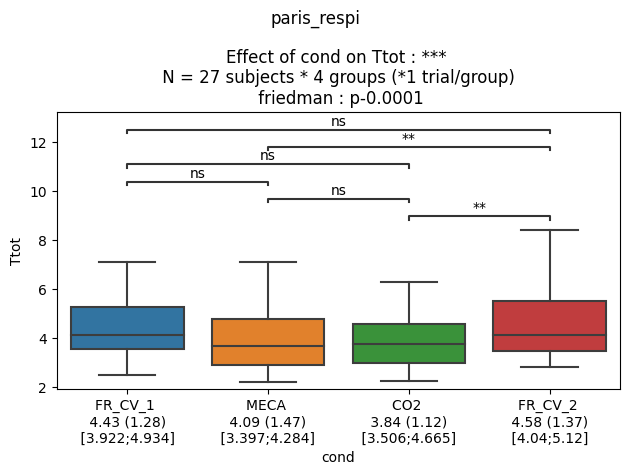

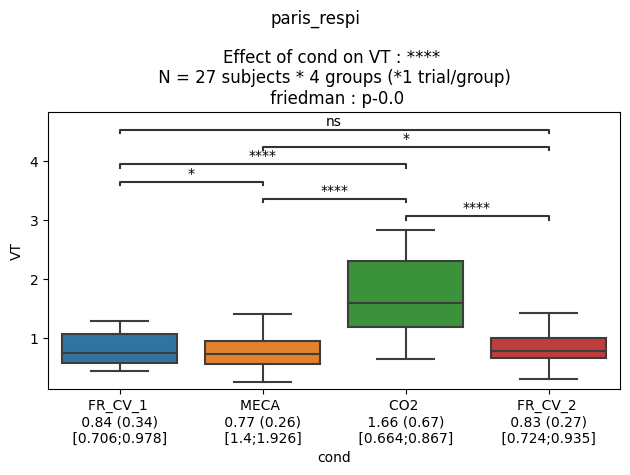

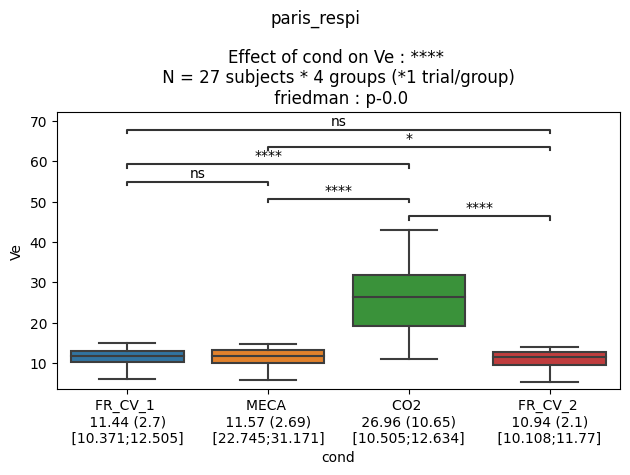

In [82]:
predictor = 'cond' 

for outcome_i in metric_paris:

    fig, ax = plt.subplots()
    
    df_stats = df_respi_paris.query(f"session == 'o'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=conditions)

    plt.suptitle('paris_respi')
    plt.tight_layout()

## best sujet

In [83]:
df_allsujet

sujet     cond session  inspi_duration  expi_duration  cycle_freq  \
0   01PD  FR_CV_1       o        3.156000       4.293081    0.148122   
0   01PD  FR_CV_1       +        2.425349       3.952372    0.174074   
0   01PD  FR_CV_1       -        1.836386       3.107333    0.217296   
0   01PD     MECA       o        3.006980       2.691959    0.186994   
0   01PD     MECA       +        2.532095       4.121952    0.179841   
..   ...      ...     ...             ...            ...         ...   
0   33MA      CO2       +        2.465018       2.499404    0.203683   
0   33MA      CO2       -        2.401123       2.528561    0.212464   
0   33MA  FR_CV_2       o        1.661373       1.794337    0.291934   
0   33MA  FR_CV_2       +        1.716487       1.898692    0.282535   
0   33MA  FR_CV_2       -        2.089387       2.476000    0.229212   

    total_amplitude select_best  
0          1.539592         YES  
0          2.176828         YES  
0          1.907390         YES  
0          1.483738         YES  
0          2.505508         YES  
..              ...         ...  
0          3.882571         YES  
0          4.878473         YES  
0          2.511541         YES  
0          3.133965         YES  
0          2.453490         YES  

[324 rows x 8 columns]

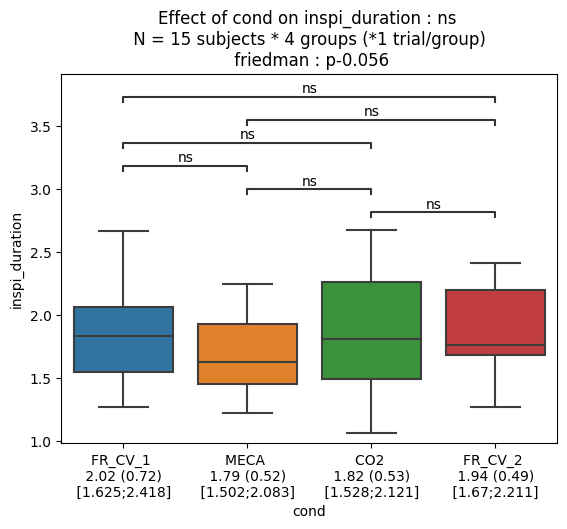

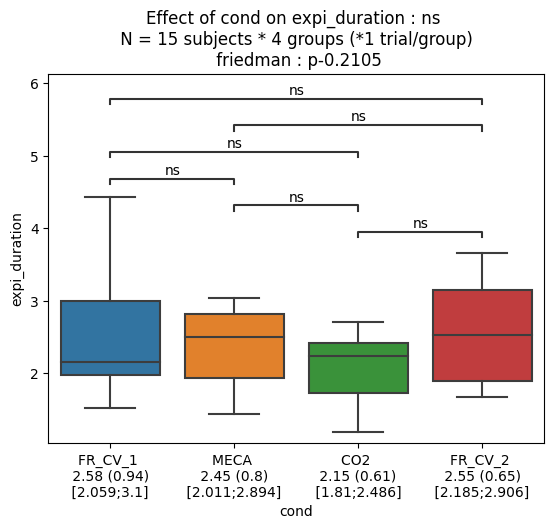

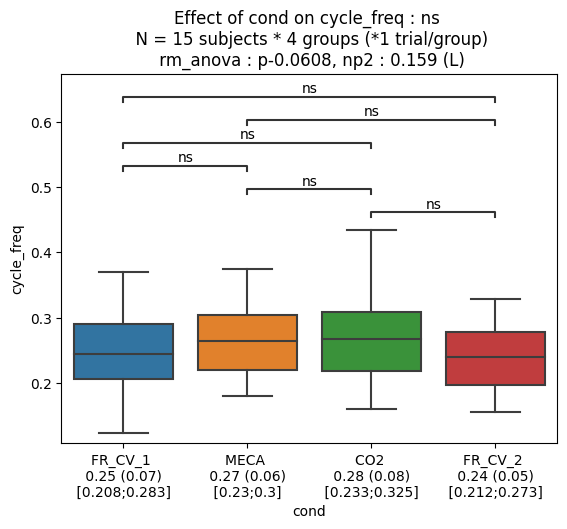

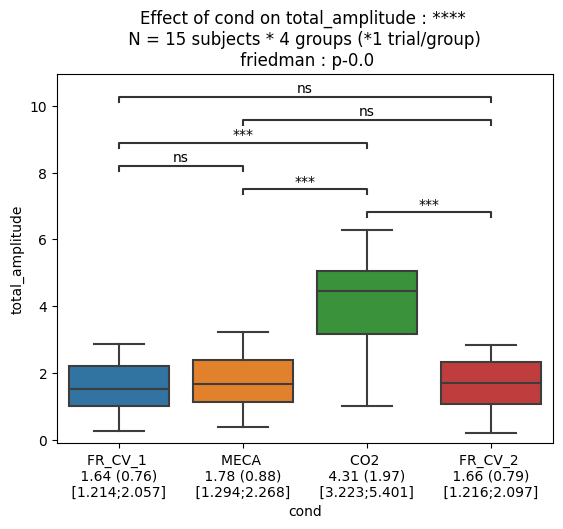

In [84]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet.query(f"session == 'o' and select_best == 'YES'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

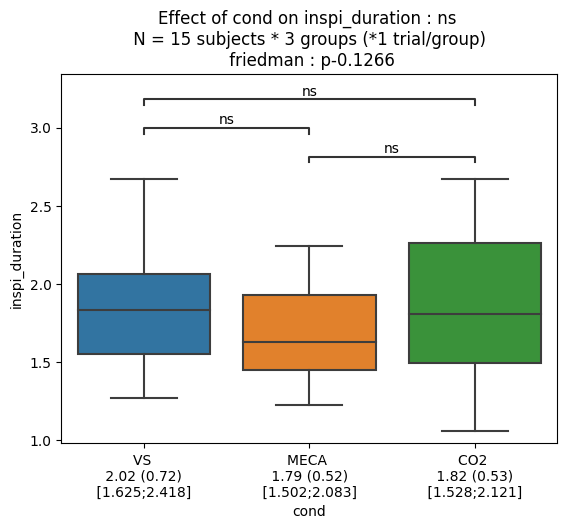

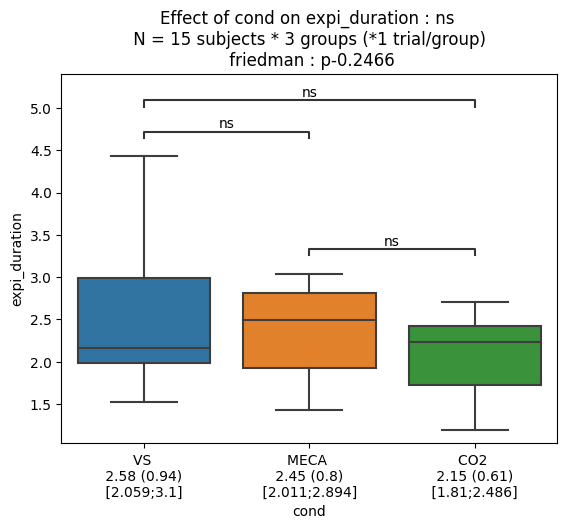

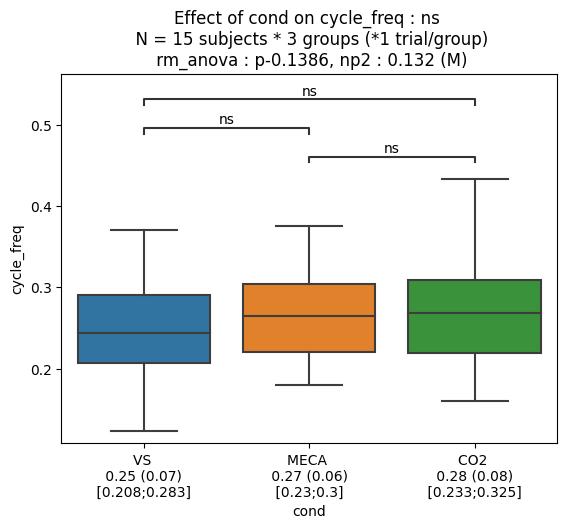

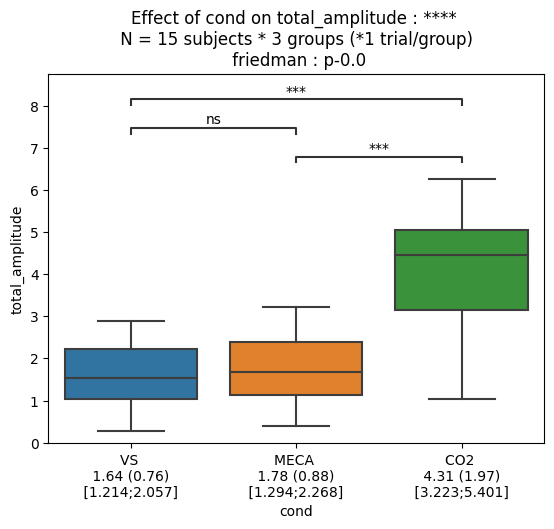

In [85]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet_VS.query(f"session == 'o' and select_best == 'YES'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

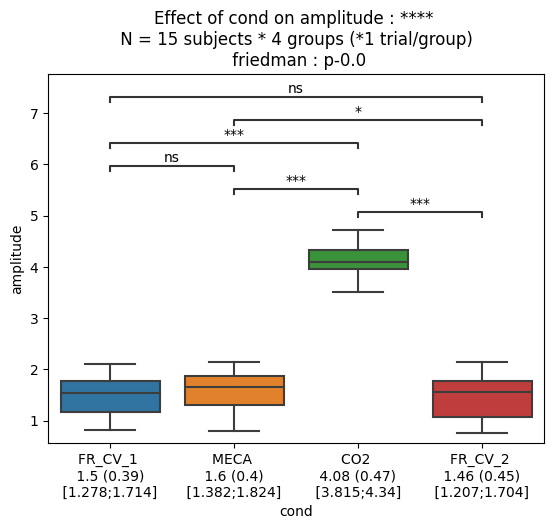

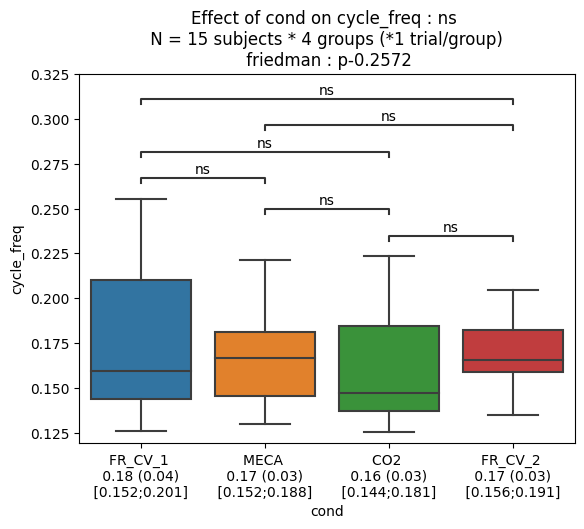

In [86]:
predictor = 'cond' 

for outcome_i in ['amplitude', 'cycle_freq']:

    fig, ax = plt.subplots()
    
    df_stats = df_respi_mean_stats.query(f"session == 'o' and select_best == 'YES'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

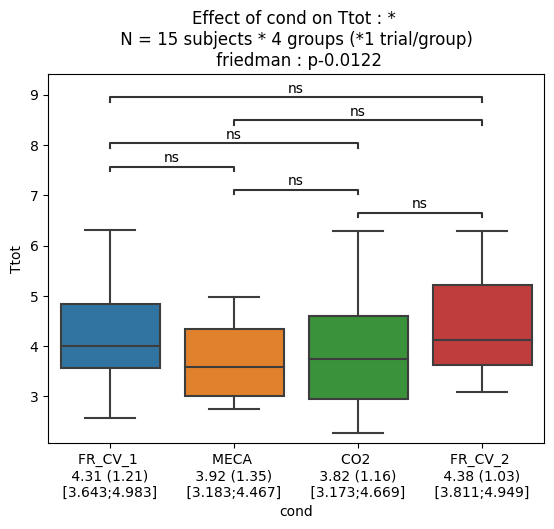

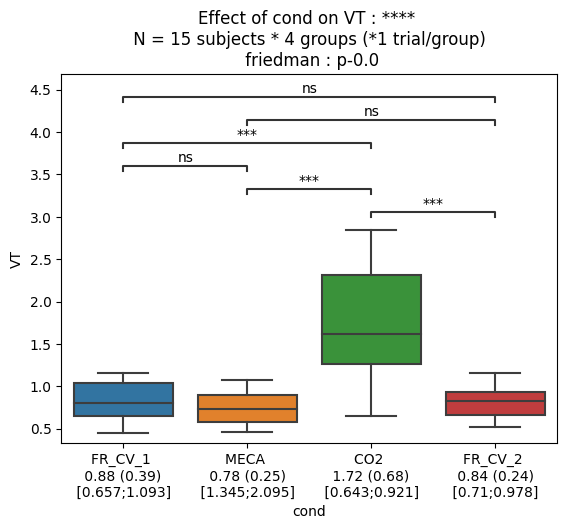

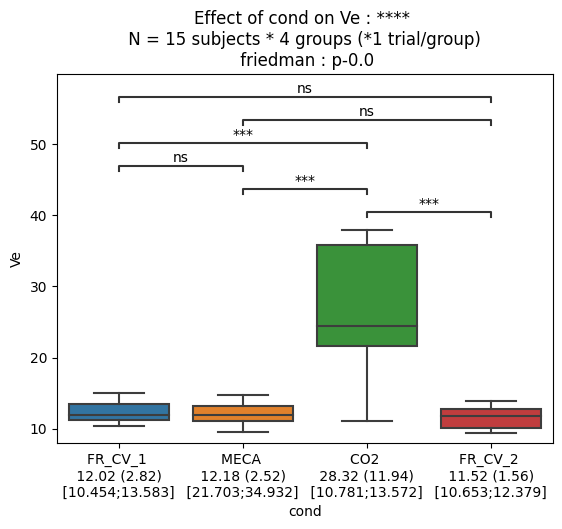

In [87]:
predictor = 'cond' 

for outcome_i in metric_paris:

    fig, ax = plt.subplots()
    
    df_stats = df_respi_paris.query(f"session == 'o' and select_best == 'YES'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=conditions)

## bad sujet

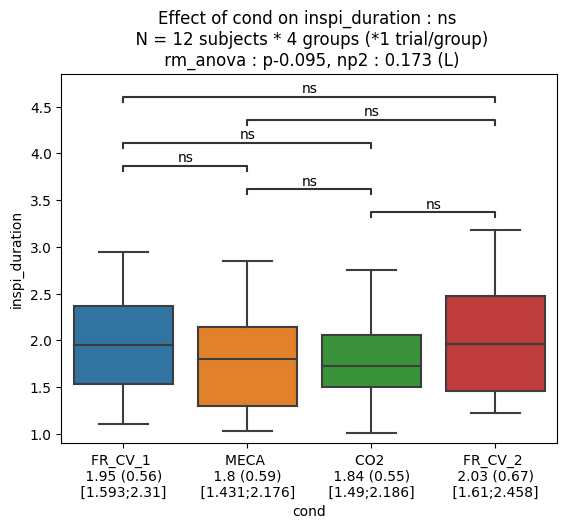

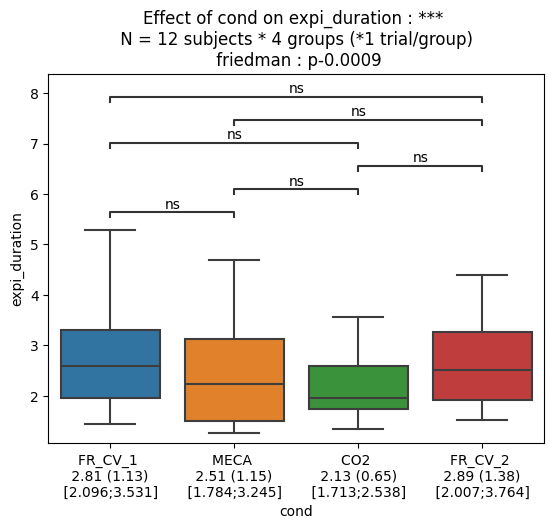

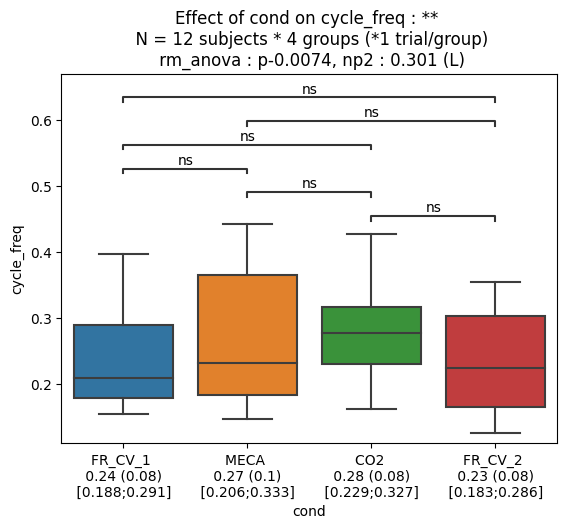

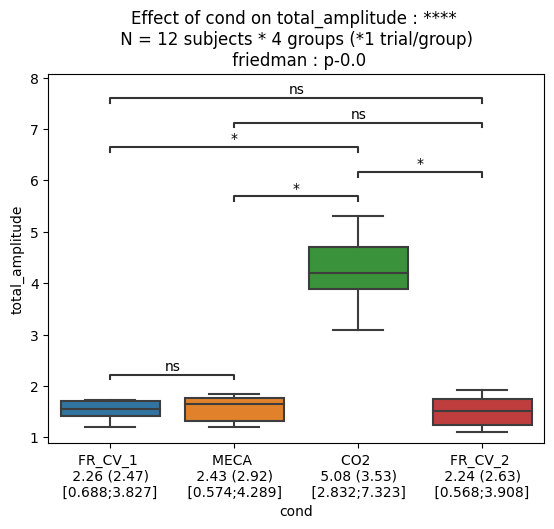

In [88]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet.query(f"session == 'o' and select_best == 'NO'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

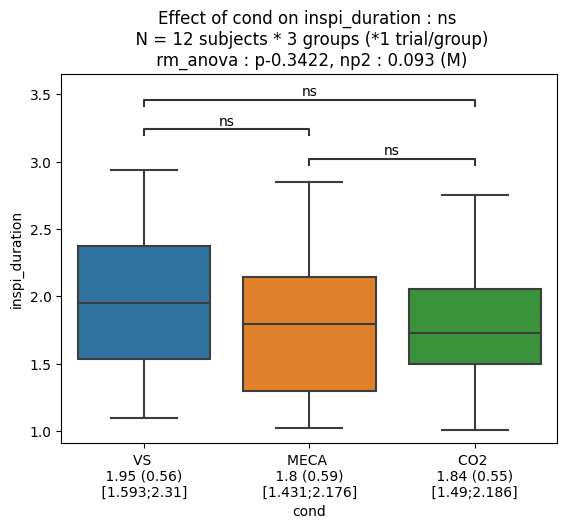

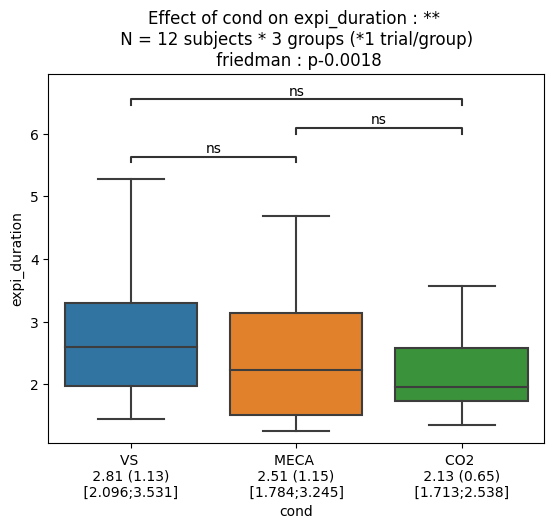

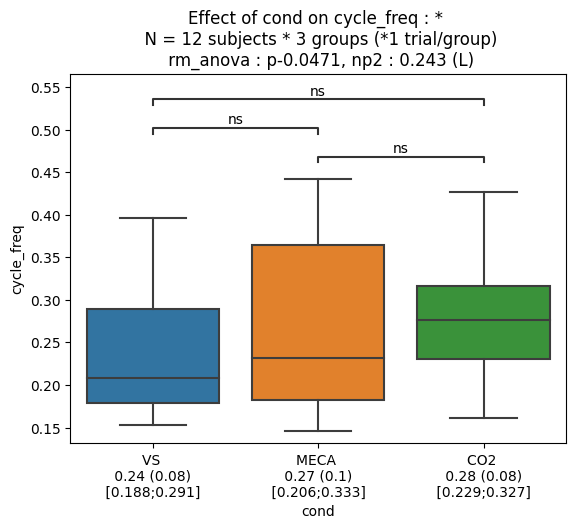

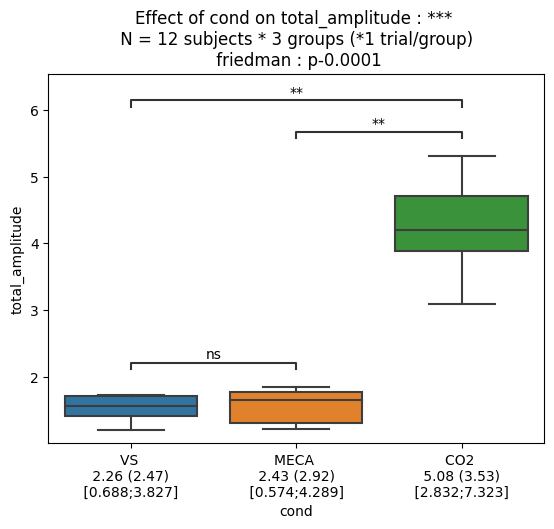

In [89]:
predictor = 'cond' 

for outcome_i in metric_list:

    fig, ax = plt.subplots()
    
    df_stats = df_allsujet_VS.query(f"session == 'o' and select_best == 'NO'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

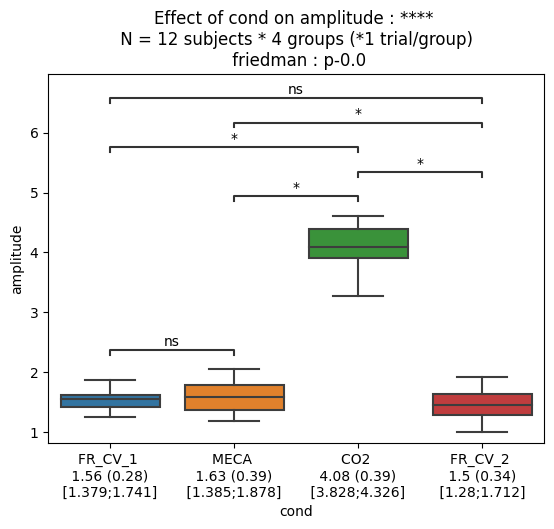

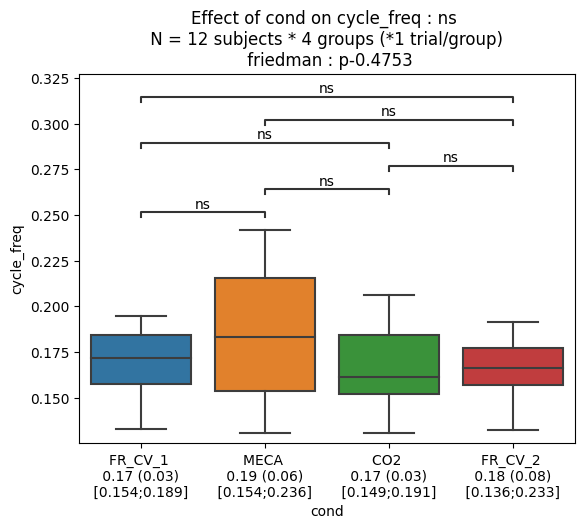

In [90]:
predictor = 'cond' 

for outcome_i in ['amplitude', 'cycle_freq']:

    fig, ax = plt.subplots()
    
    df_stats = df_respi_mean_stats.query(f"session == 'o' and select_best == 'NO'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

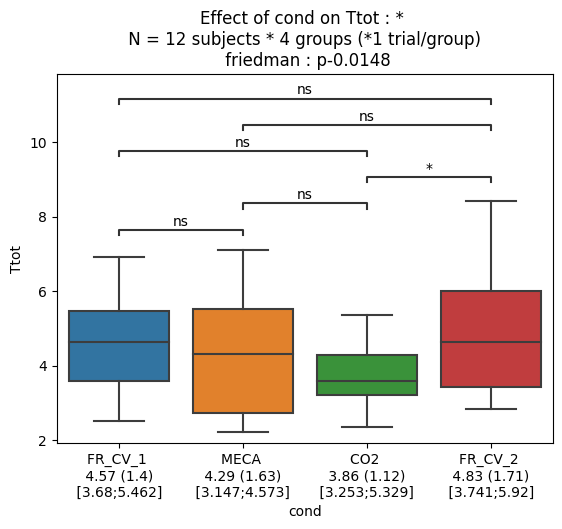

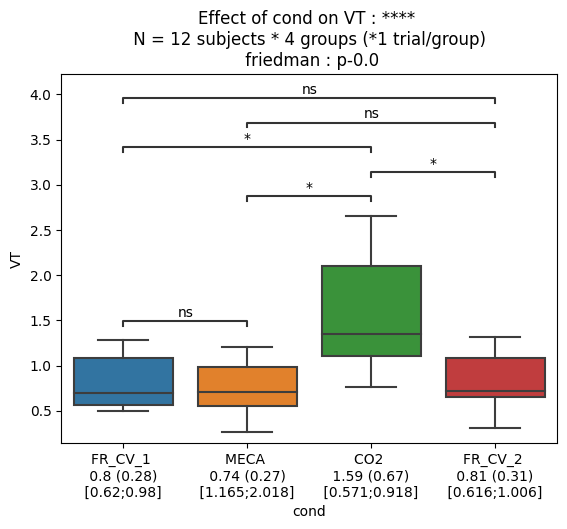

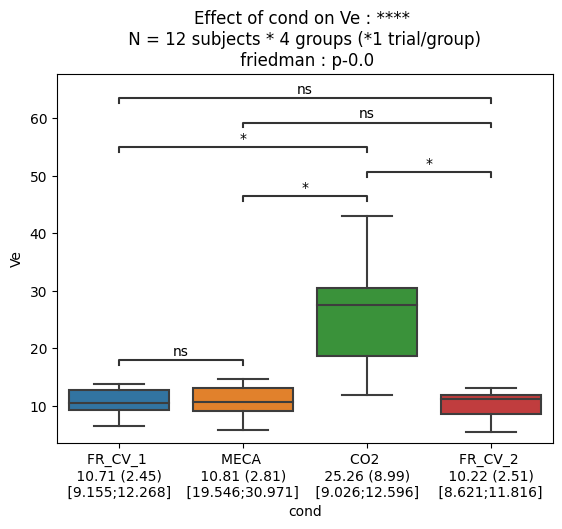

In [91]:
predictor = 'cond' 

for outcome_i in metric_paris:

    fig, ax = plt.subplots()
    
    df_stats = df_respi_paris.query(f"session == 'o' and select_best == 'NO'")
    ax = auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=conditions)

## both

In [103]:
predictor = 'select_best'

count = 0

for odor in odor_list:

    for cond in cond_list:

        for outcome_i in metric_paris:

            df_stats = df_respi_paris.query(f"session == '{odor}' and cond == '{cond}'")

            if count == 0:
                
                df_res = get_df_stats_pre(df_stats, predictor, outcome_i, subject='sujet', design='between', transform=False, verbose=False)
                df_res['cond'] = cond
                df_res['odor'] = odor

            else:

                _df_res = get_df_stats_pre(df_stats, predictor, outcome_i, subject='sujet', design='between', transform=False, verbose=False)
                _df_res['cond'] = cond
                _df_res['odor'] = odor
                df_res = pd.concat([df_res, _df_res])
                
            count += 1

df_res          

test alternative     p-val outcome        YES         NO     cond odor
0  T-test   two-sided  0.619392    Ttot   4.313313   4.571032  FR_CV_1    o
0     MWU   two-sided  0.751116      VT   0.875414   0.799882  FR_CV_1    o
0  T-test   two-sided  0.210058      Ve  12.018823  10.711597  FR_CV_1    o
0     MWU   two-sided  0.826200    Ttot   3.920984   4.291247     MECA    o
0  T-test   two-sided  0.717181      VT   0.782008   0.744603     MECA    o
0  T-test   two-sided  0.202548      Ve  12.176256  10.811141     MECA    o
0  T-test   two-sided  0.937077    Ttot   3.824811   3.859997      CO2    o
0  T-test   two-sided  0.628511      VT   1.719784   1.591778      CO2    o
0  T-test   two-sided  0.454985      Ve  28.317594  25.258262      CO2    o
0  T-test   two-sided  0.432952    Ttot   4.379656   4.830578  FR_CV_2    o
0  T-test   two-sided  0.762681      VT   0.844066   0.810933  FR_CV_2    o
0  T-test   two-sided  0.135744      Ve  11.515930  10.218094  FR_CV_2    o
0  T-test   two-sided  0.623512    Ttot   4.562146   4.847301  FR_CV_1    +
0  T-test   two-sided  0.719442      VT   0.791417   0.826725  FR_CV_1    +
0  T-test   two-sided  0.907541      Ve  10.633926  10.526056  FR_CV_1    +
0  T-test   two-sided  0.709400    Ttot   4.137481   4.361638     MECA    +
0  T-test   two-sided  0.933367      VT   0.751182   0.744017     MECA    +
0  T-test   two-sided  0.748688      Ve  11.103283  10.832964     MECA    +
0  T-test   two-sided  0.648775    Ttot   3.934367   3.743088      CO2    +
0  T-test   two-sided  0.683521      VT   1.670696   1.557161      CO2    +
0  T-test   two-sided  0.632718      Ve  26.968858  24.962715      CO2    +
0  T-test   two-sided  0.692079    Ttot   4.720041   4.516660  FR_CV_2    +
0     MWU   two-sided  0.788413      VT   0.824252   0.789868  FR_CV_2    +
0  T-test   two-sided  0.532909      Ve  10.500116  10.961931  FR_CV_2    +
0  T-test   two-sided  0.155312    Ttot   4.126203   4.939946  FR_CV_1    -
0  T-test   two-sided  0.271085      VT   0.725914   0.863252  FR_CV_1    -
0  T-test   two-sided  0.779072      Ve  10.678577  10.472245  FR_CV_1    -
0  T-test   two-sided  0.247566    Ttot   3.787852   4.461902     MECA    -
0  T-test   two-sided  0.376295      VT   0.681358   0.769373     MECA    -
0  T-test   two-sided  0.525321      Ve  10.985206  10.536460     MECA    -
0  T-test   two-sided  0.173266    Ttot   3.607161   4.207260      CO2    -
0  T-test   two-sided  0.210458      VT   1.311294   1.644726      CO2    -
0  T-test   two-sided  0.777748      Ve  22.659933  23.687123      CO2    -
0  T-test   two-sided  0.180453    Ttot   4.177165   4.790360  FR_CV_2    -
0  T-test   two-sided  0.513617      VT   0.765076   0.820802  FR_CV_2    -
0  T-test   two-sided  0.209113      Ve  11.109897  10.299063  FR_CV_2    -

In [104]:
predictor = 'select_best'

count = 0

for odor in odor_list:

    for cond in cond_list:

        for outcome_i in metric_list:

            df_stats = df_allsujet.query(f"session == '{odor}' and cond == '{cond}'")

            if count == 0:
                
                df_res = get_df_stats_pre(df_stats, predictor, outcome_i, subject='sujet', design='between', transform=False, verbose=False)
                df_res['cond'] = cond
                df_res['odor'] = odor

            else:

                _df_res = get_df_stats_pre(df_stats, predictor, outcome_i, subject='sujet', design='between', transform=False, verbose=False)
                _df_res['cond'] = cond
                _df_res['odor'] = odor
                df_res = pd.concat([df_res, _df_res])
                
            count += 1

df_res

test alternative     p-val          outcome         YES        NO  \
0     MWU   two-sided  0.980536   inspi_duration    2.021536  1.951235   
0     MWU   two-sided  0.642968    expi_duration    2.579515  2.813235   
0  T-test   two-sided  0.851067       cycle_freq    0.245061  0.239504   
0     MWU   two-sided  0.826200  total_amplitude    1.635385  2.257204   
0     MWU   two-sided  0.980536   inspi_duration    1.792847  1.803797   
0  T-test   two-sided  0.874663    expi_duration    2.452316  2.514781   
0  T-test   two-sided  0.891063       cycle_freq    0.265042  0.269650   
0     MWU   two-sided  0.902909  total_amplitude    1.780950  2.431244   
0  T-test   two-sided  0.947890   inspi_duration    1.824603  1.838470   
0  T-test   two-sided  0.928942    expi_duration    2.147844  2.125769   
0  T-test   two-sided  0.972448       cycle_freq    0.278909  0.277834   
0     MWU   two-sided  0.941653  total_amplitude    4.312289  5.077638   
0  T-test   two-sided  0.688601   inspi_duration    1.940552  2.034210   
0     MWU   two-sided  0.642968    expi_duration    2.545650  2.885330   
0  T-test   two-sided  0.771252       cycle_freq    0.242507  0.234460   
0     MWU   two-sided  0.941653  total_amplitude    1.656415  2.238464   
0  T-test   two-sided  0.775680   inspi_duration    1.991137  2.056840   
0  T-test   two-sided  0.660170    expi_duration    2.715975  2.907779   
0  T-test   two-sided  0.869297       cycle_freq    0.231641  0.236504   
0     MWU   two-sided  0.541903  total_amplitude  190.922028  2.729081   
0  T-test   two-sided  0.683726   inspi_duration    1.873714  1.798123   
0  T-test   two-sided  0.829250    expi_duration    2.476860  2.562182   
0  T-test   two-sided  0.633426       cycle_freq    0.253820  0.270014   
0     MWU   two-sided  0.941653  total_amplitude  190.803775  3.069235   
0  T-test   two-sided  0.550379   inspi_duration    1.924997  1.790103   
0  T-test   two-sided  0.843727    expi_duration    2.390533  2.326350   
0  T-test   two-sided  0.969561       cycle_freq    0.272368  0.271106   
0     MWU   two-sided  0.714393  total_amplitude  588.352977  7.470875   
0  T-test   two-sided  0.674374   inspi_duration    2.087190  1.993301   
0  T-test   two-sided  0.904283    expi_duration    2.826559  2.777029   
0  T-test   two-sided  0.747750       cycle_freq    0.228532  0.237648   
0     MWU   two-sided  0.678319  total_amplitude  190.753885  2.741542   
0  T-test   two-sided  0.488609   inspi_duration    1.939661  2.114937   
0  T-test   two-sided  0.448033    expi_duration    2.666000  2.949016   
0     MWU   two-sided  0.479239       cycle_freq    0.238610  0.228739   
0  T-test   two-sided  0.502498  total_amplitude    1.573992  1.707405   
0  T-test   two-sided  0.498353   inspi_duration    1.722409  1.874605   
0     MWU   two-sided  0.714393    expi_duration    2.426037  2.612939   
0     MWU   two-sided  0.541903       cycle_freq    0.276746  0.256406   
0  T-test   two-sided  0.860567  total_amplitude    1.714083  1.753793   
0  T-test   two-sided  0.289371   inspi_duration    1.775299  2.005279   
0  T-test   two-sided  0.291922    expi_duration    2.041979  2.325828   
0  T-test   two-sided  0.300719       cycle_freq    0.286920  0.255540   
0     MWU   two-sided  0.678319  total_amplitude    4.223922  4.411617   
0  T-test   two-sided  0.477576   inspi_duration    1.913871  2.066758   
0     MWU   two-sided  0.574700    expi_duration    2.573452  2.829991   
0     MWU   two-sided  0.541903       cycle_freq    0.243355  0.228673   
0  T-test   two-sided  0.397686  total_amplitude    1.878772  1.681306   

      cond odor  
0  FR_CV_1    o  
0  FR_CV_1    o  
0  FR_CV_1    o  
0  FR_CV_1    o  
0     MECA    o  
0     MECA    o  
0     MECA    o  
0     MECA    o  
0      CO2    o  
0      CO2    o  
0      CO2    o  
0      CO2    o  
0  FR_CV_2    o  
0  FR_CV_2    o  
0  FR_CV_2    o  
0  FR_CV_2    o  
0  FR_CV_1    +  
0  FR_CV_1    +  
0  FR_CV_1    +  
0  FR_CV_1    +  


# EFFECT ODOR

## allsujet

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


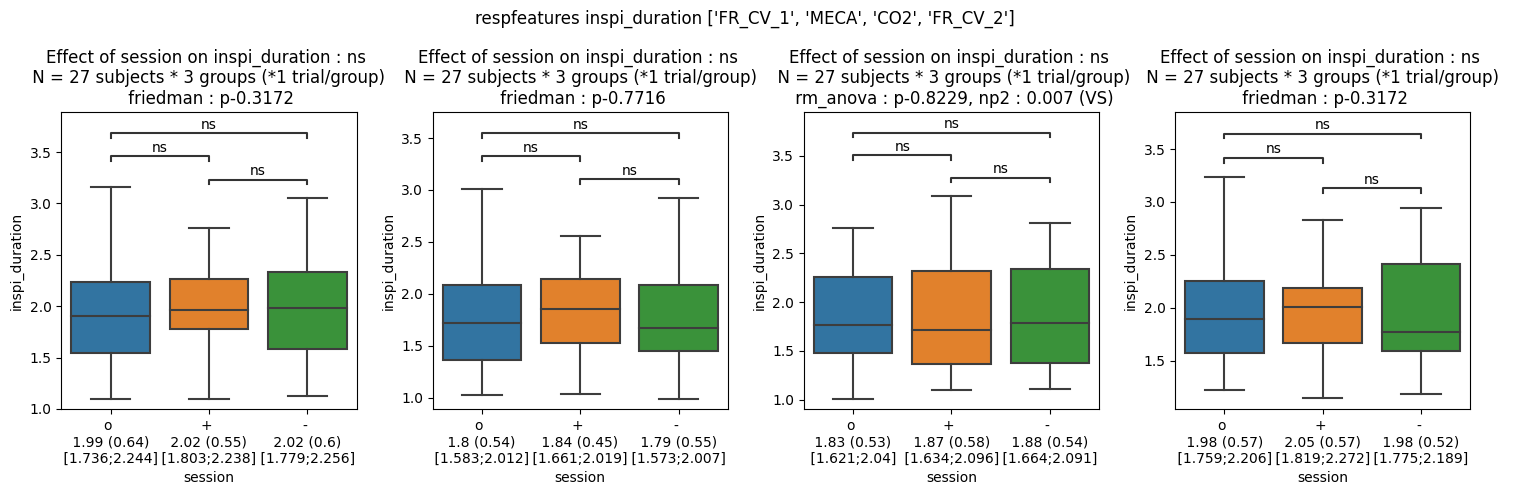

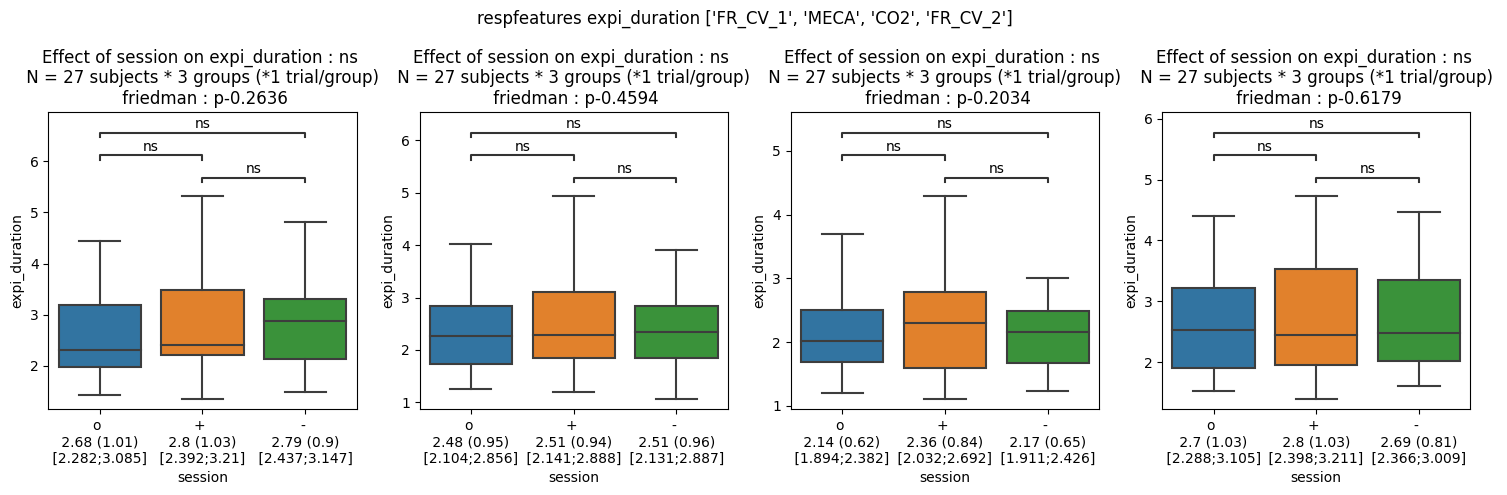

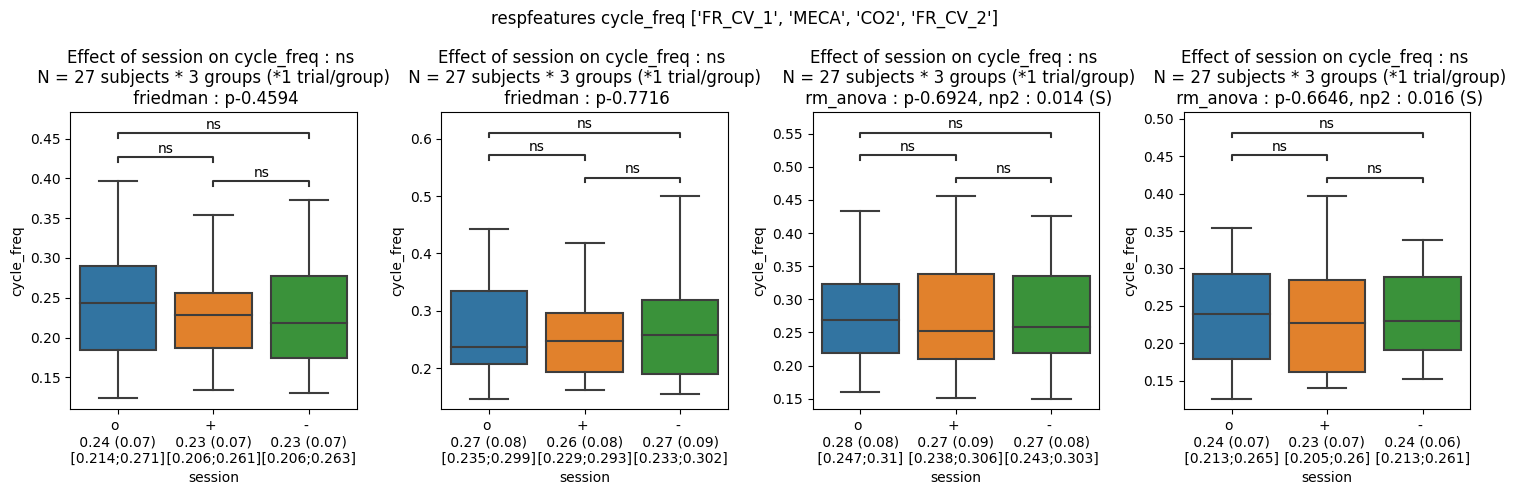

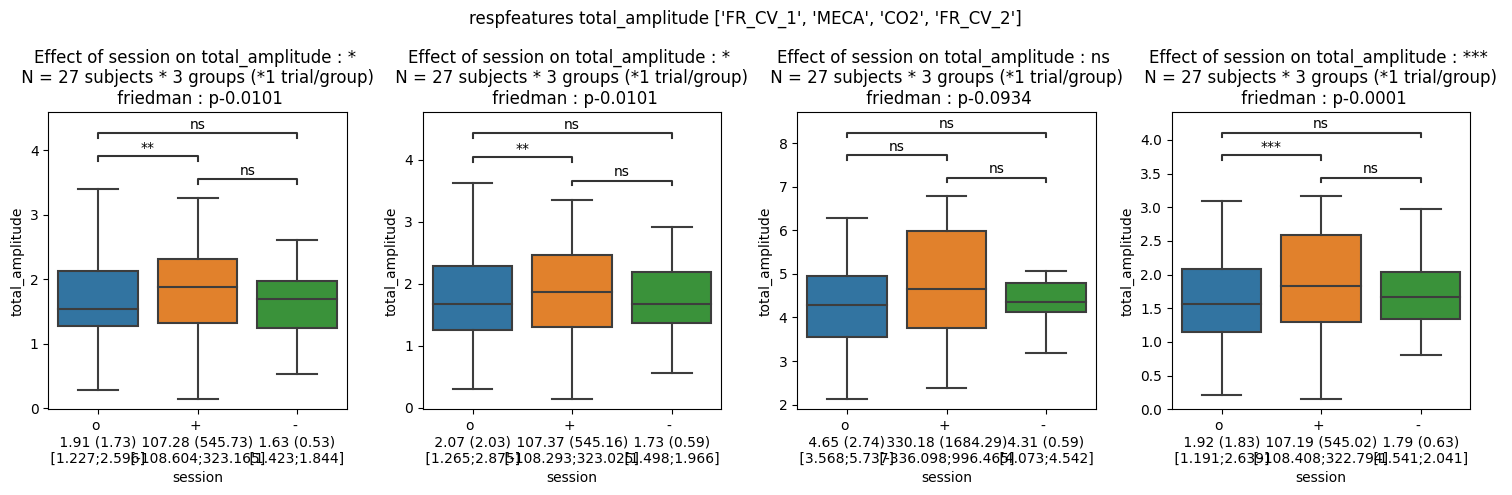

In [105]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_allsujet.query(f"cond == '{cond}'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)
    
    plt.suptitle(f"respfeatures {outcome_i} {conditions}")
    plt.tight_layout()

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


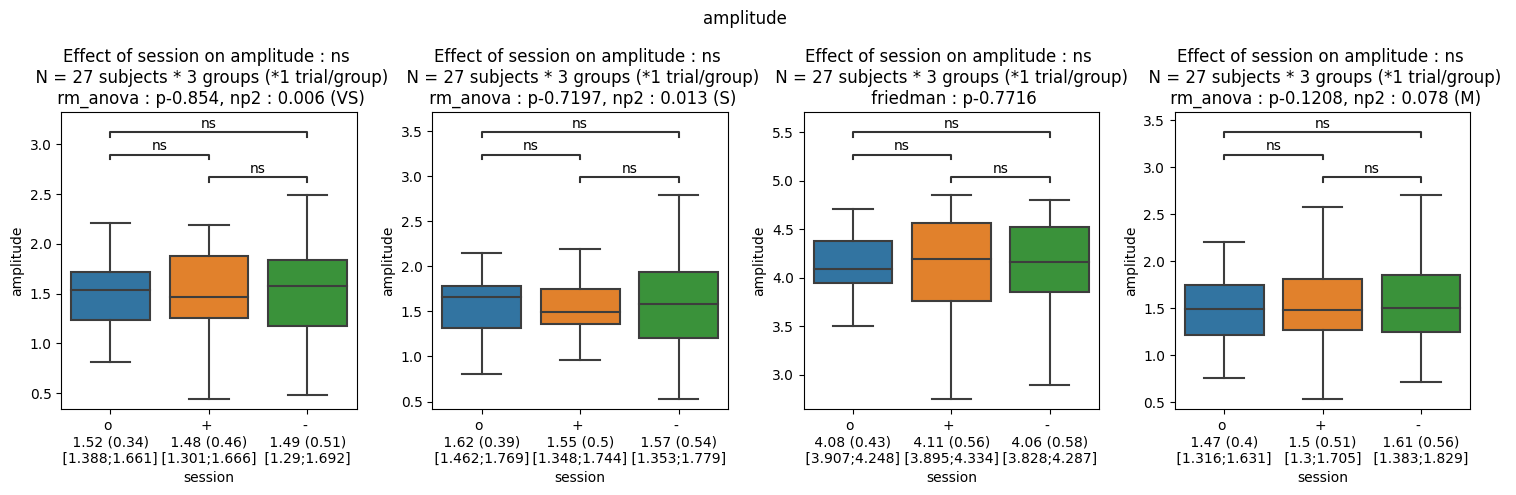

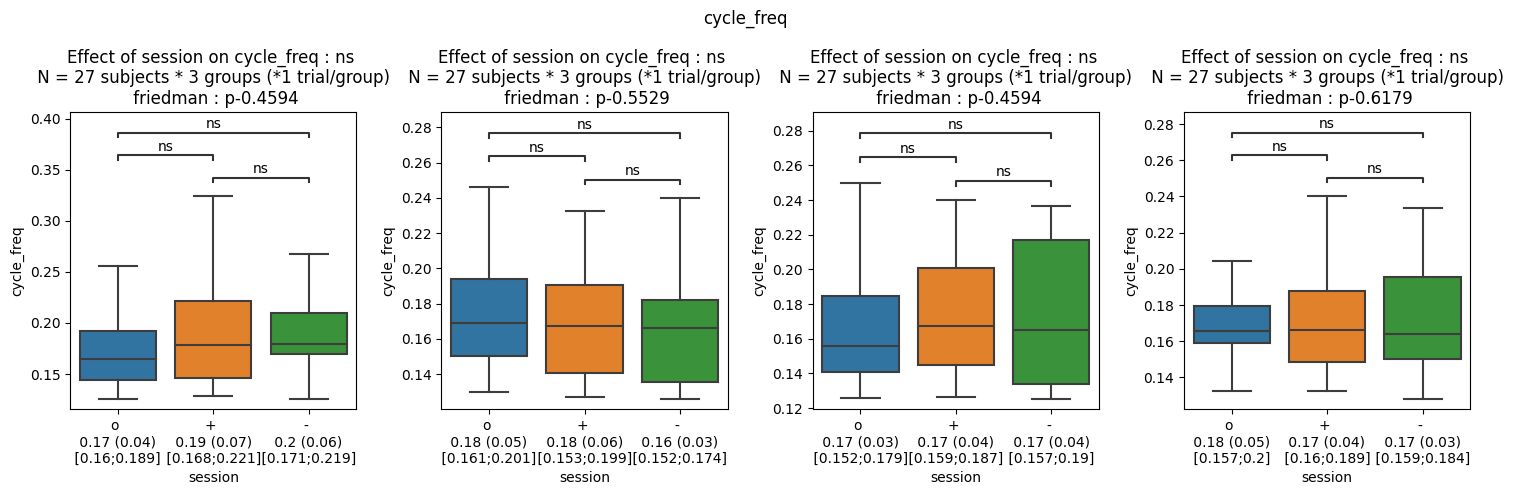

In [106]:
predictor = 'session' 

print(conditions)

for outcome_i in ['amplitude', 'cycle_freq']:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_mean_stats.query(f"cond == '{cond}'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(outcome_i)
    plt.tight_layout()

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


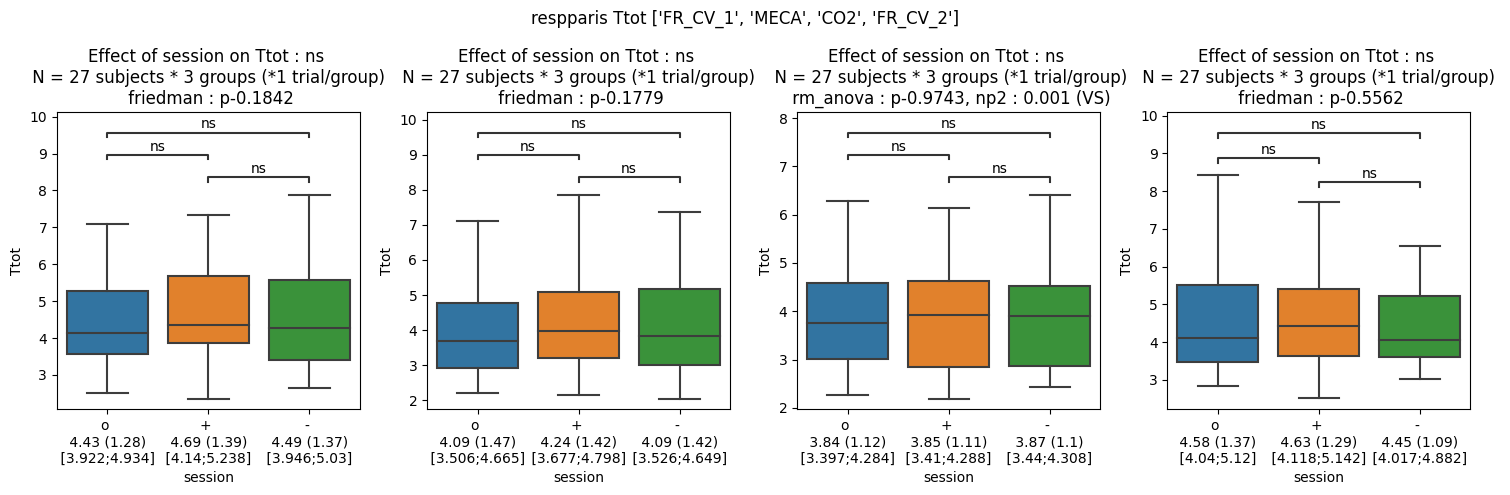

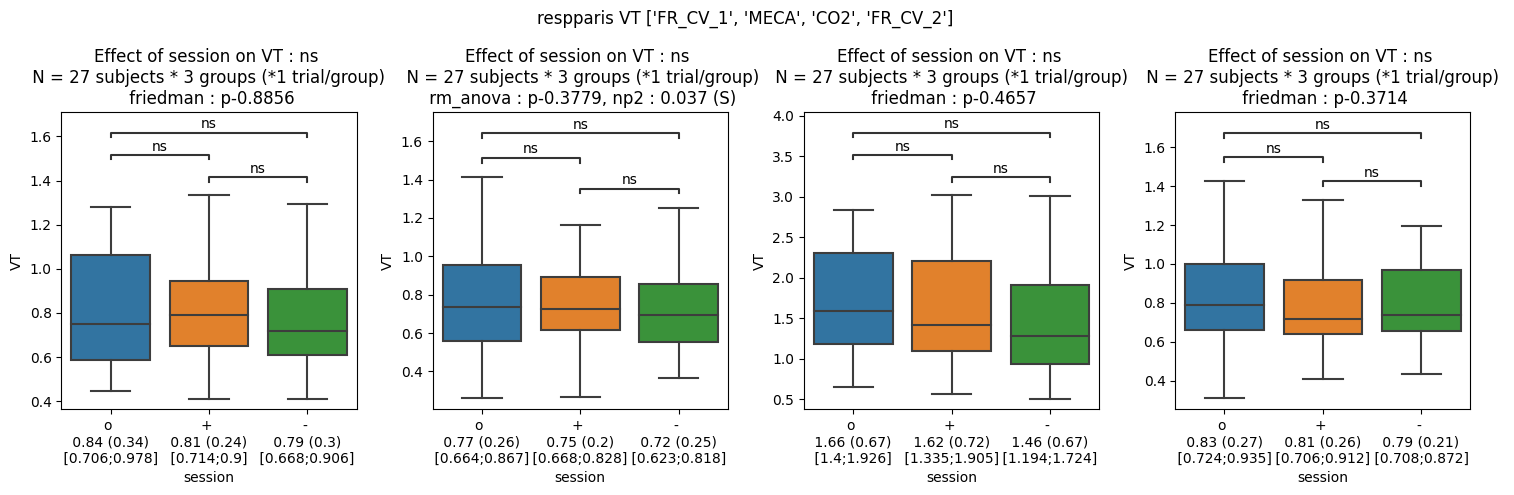

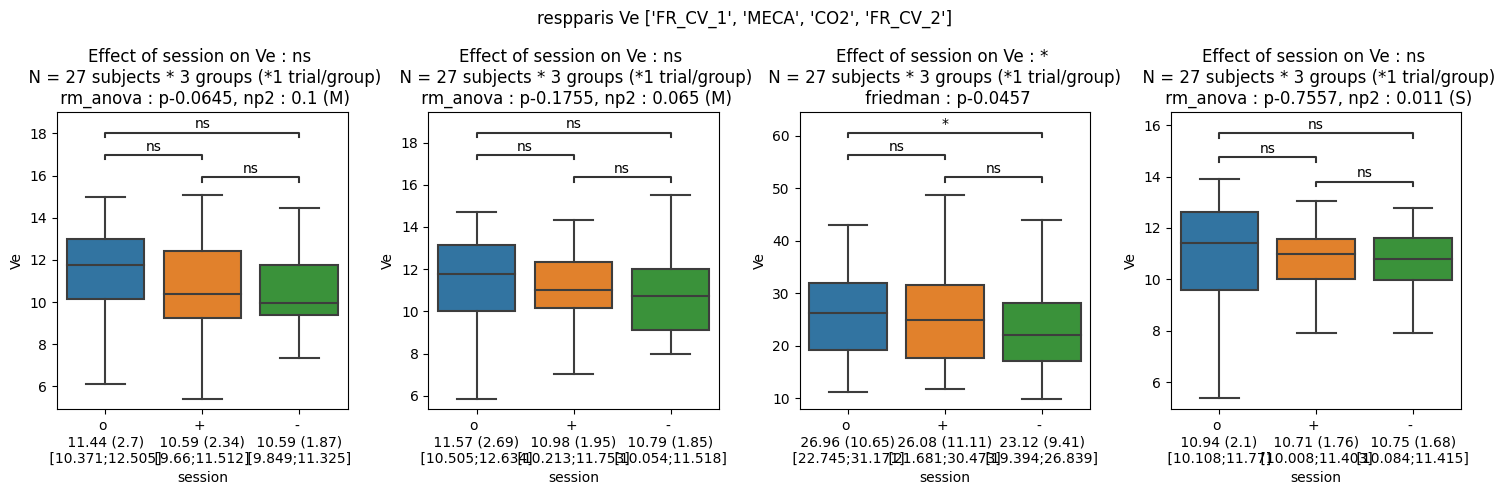

In [107]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_paris:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_paris.query(f"cond == '{cond}'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(f"respparis {outcome_i} {conditions}")
    plt.tight_layout()

## best sujet

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


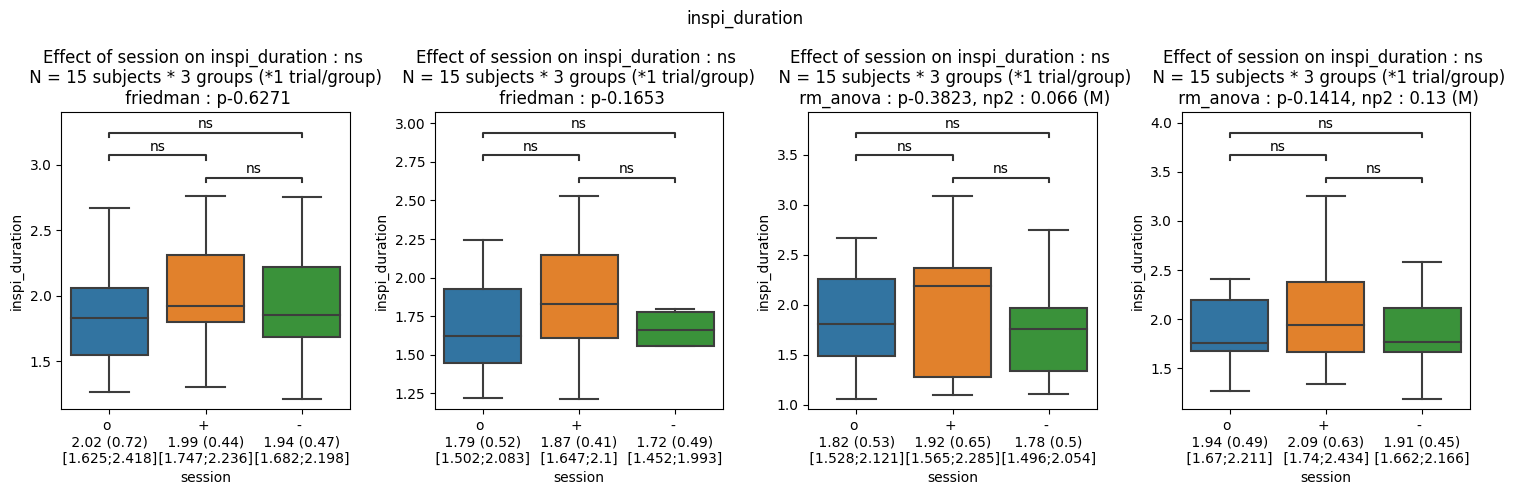

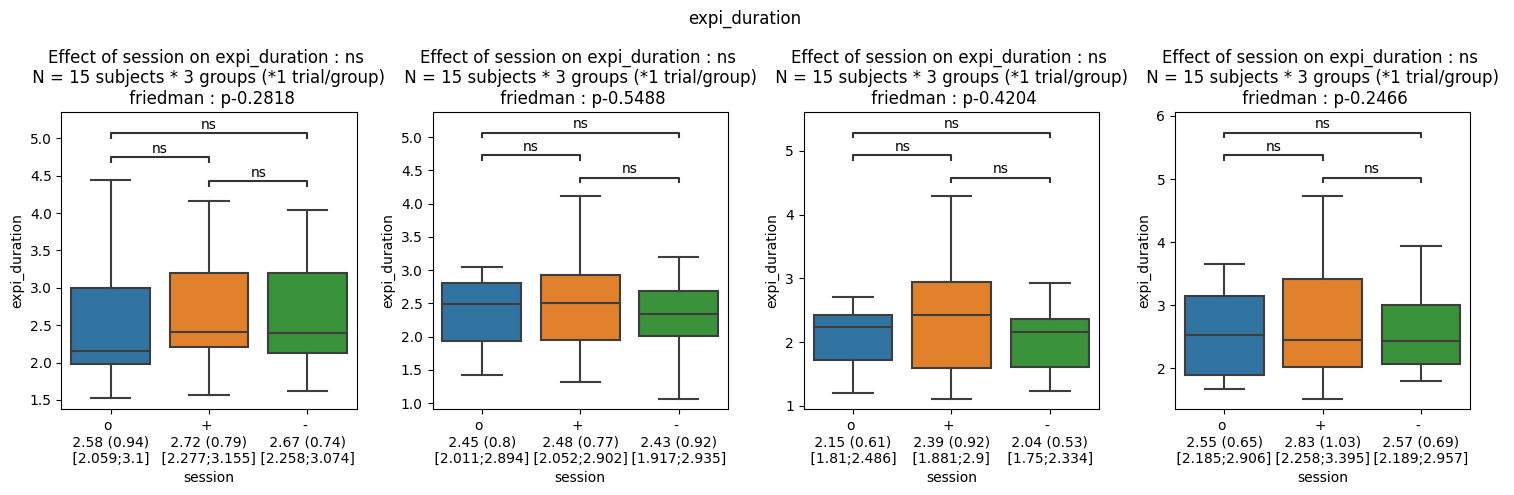

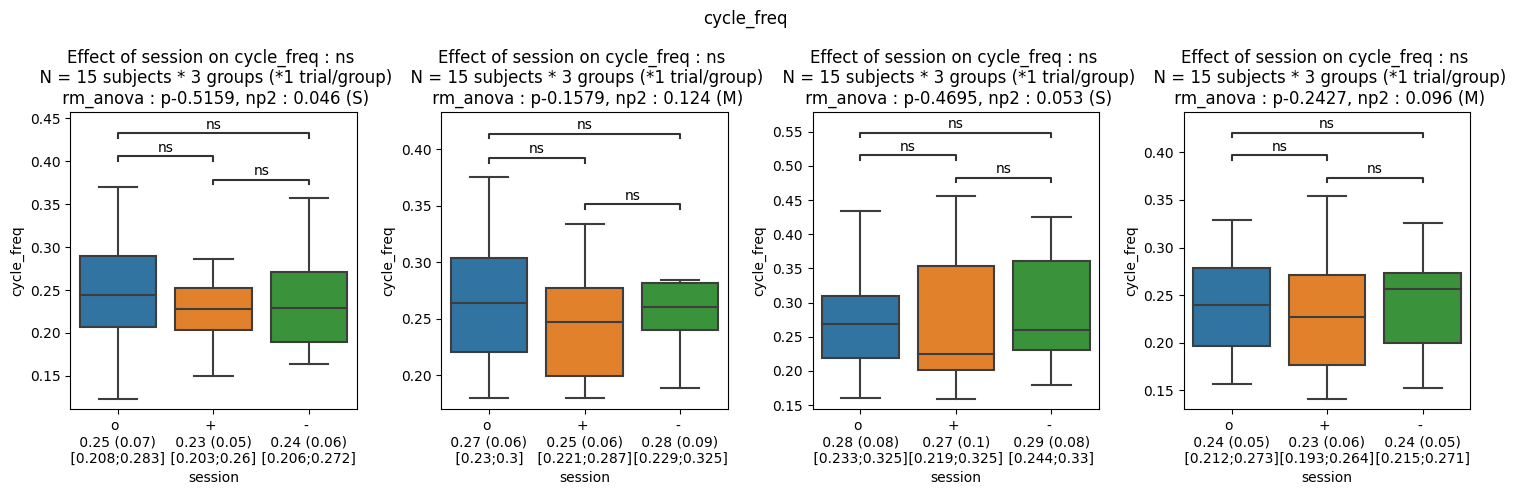

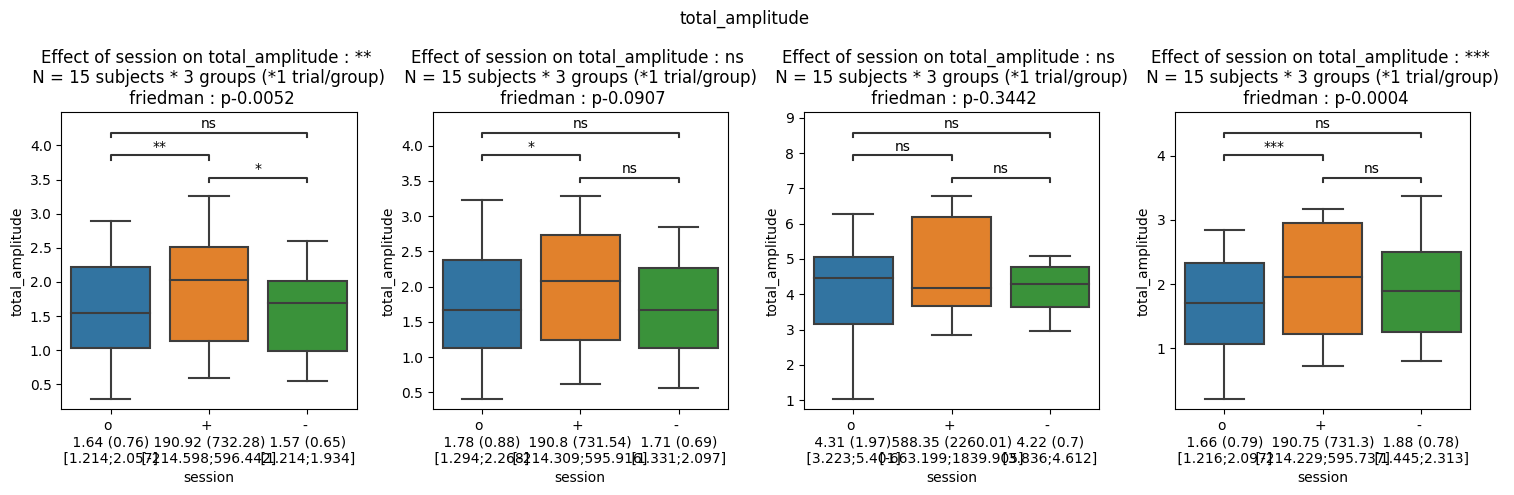

In [108]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_allsujet.query(f"cond == '{cond}' and select_best == 'YES'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(outcome_i)
    plt.tight_layout()

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


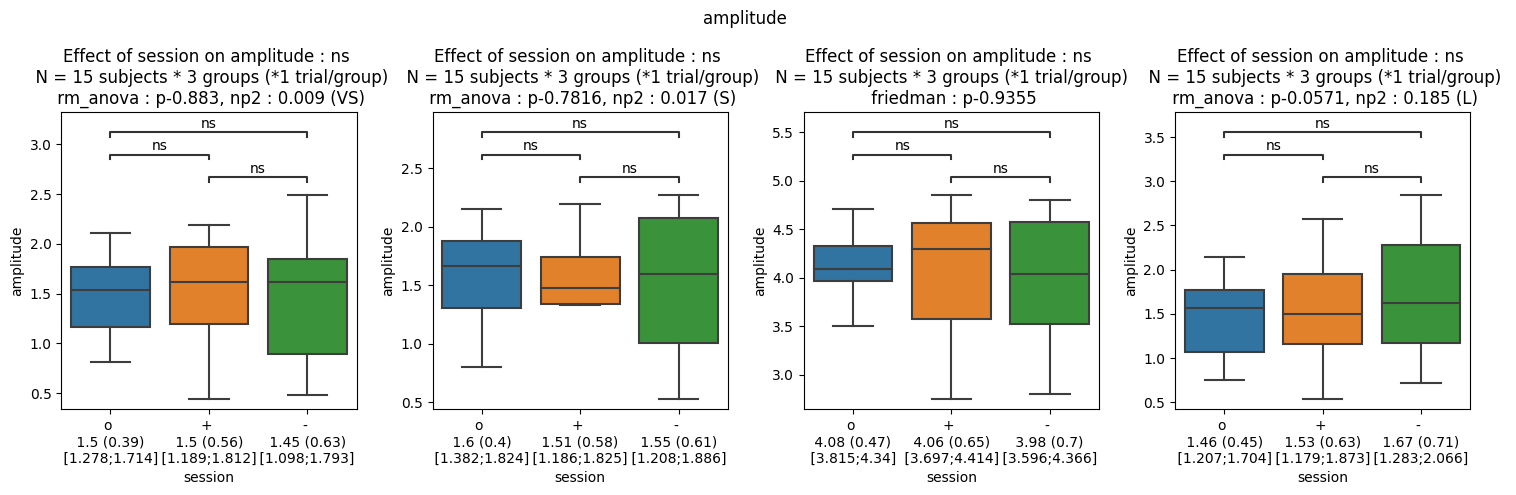

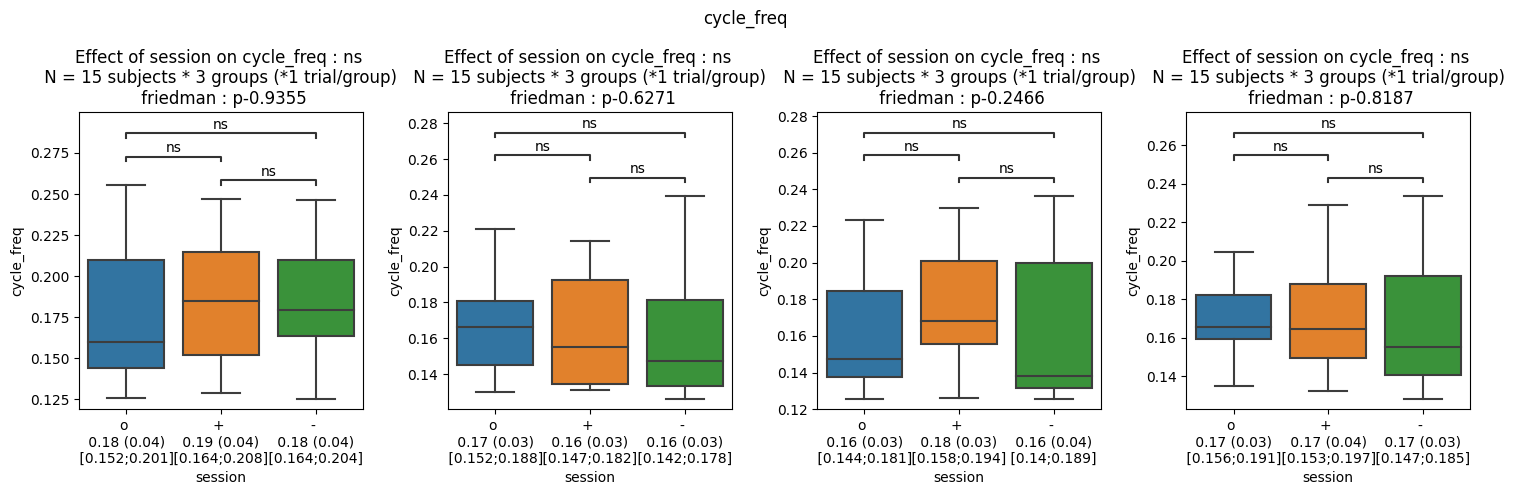

In [109]:
predictor = 'session' 

print(conditions)

for outcome_i in ['amplitude', 'cycle_freq']:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_mean_stats.query(f"cond == '{cond}' and select_best == 'YES'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(outcome_i)
    plt.tight_layout()

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/home/jules/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jules/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jules/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jules/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-val

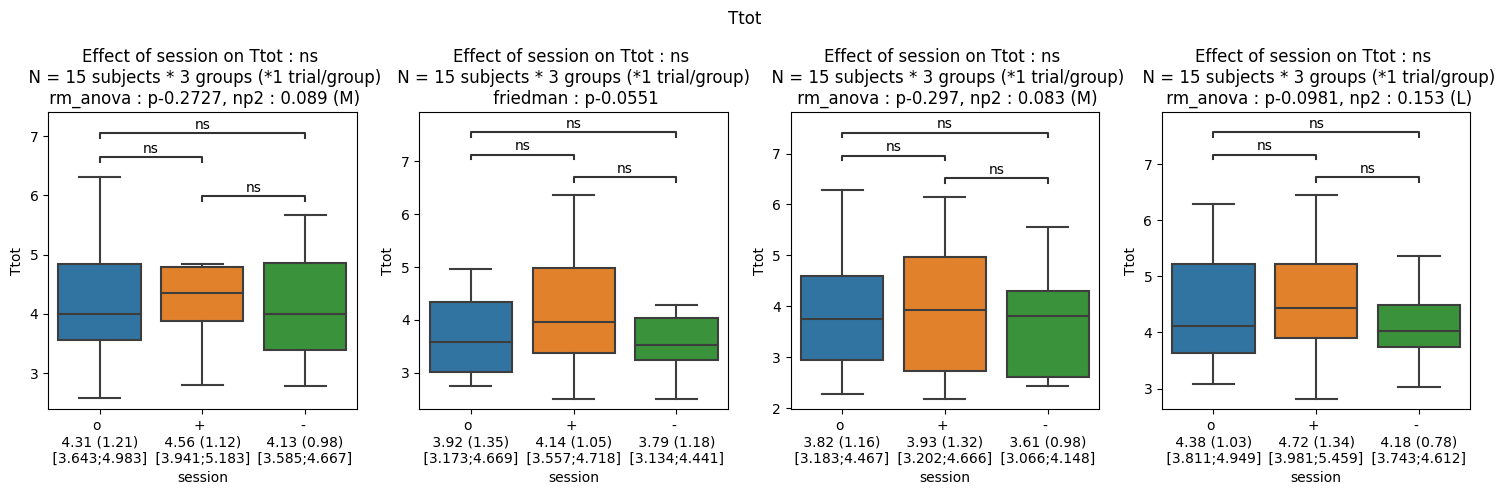

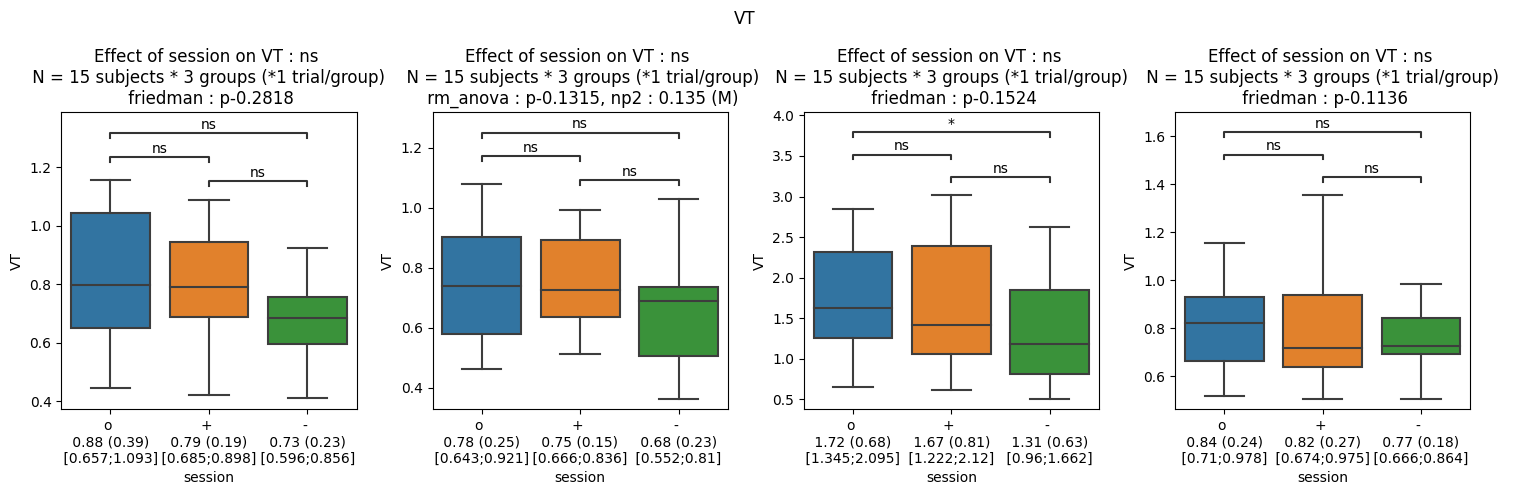

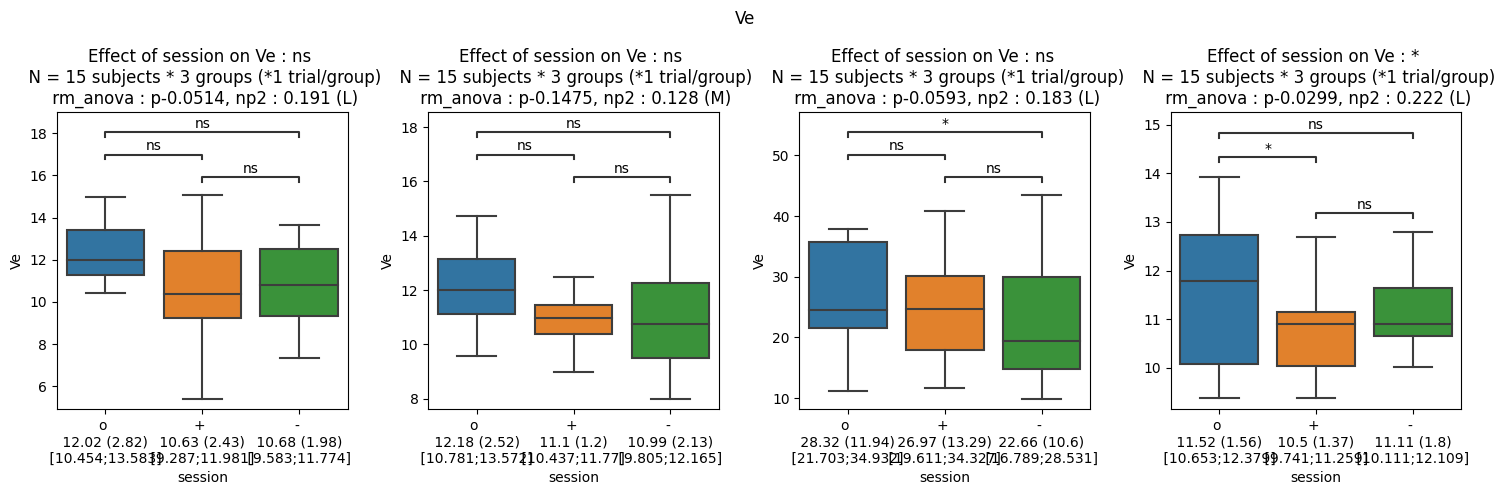

In [110]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_paris:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_paris.query(f"cond == '{cond}' and select_best == 'YES'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(outcome_i)
    plt.tight_layout()

## bad sujet

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/jules/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


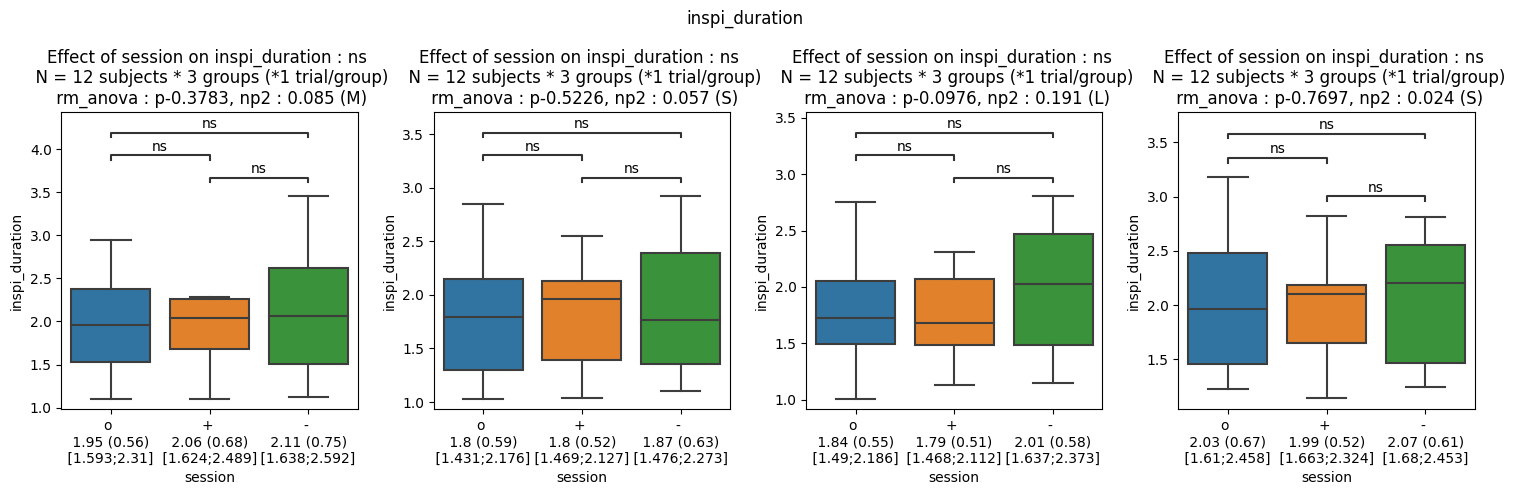

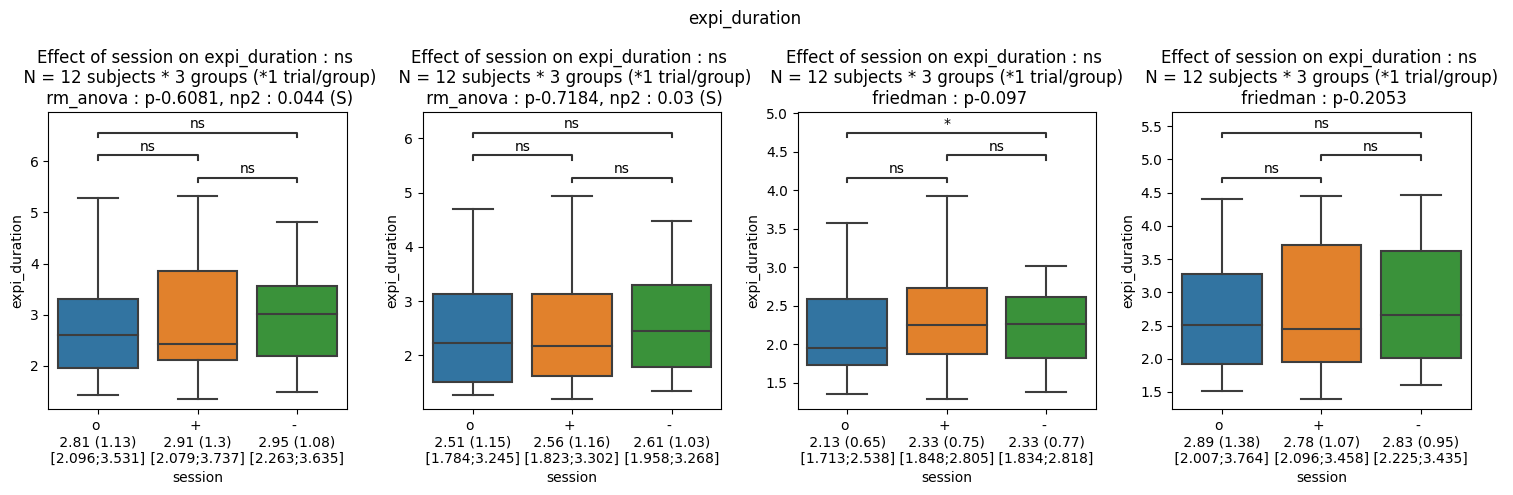

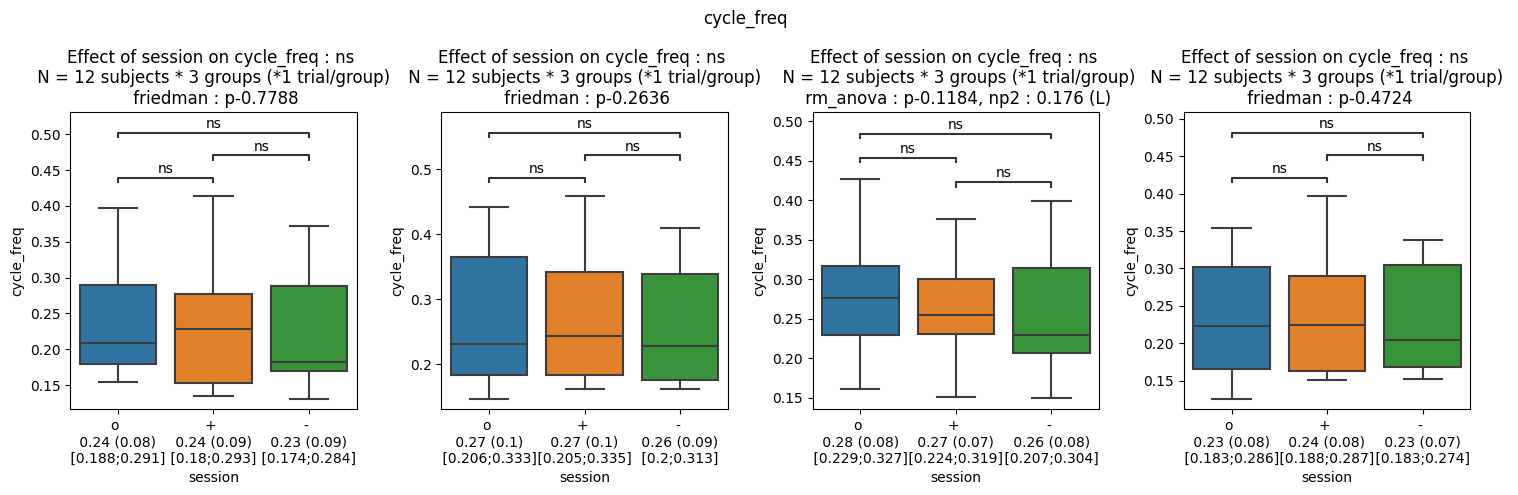

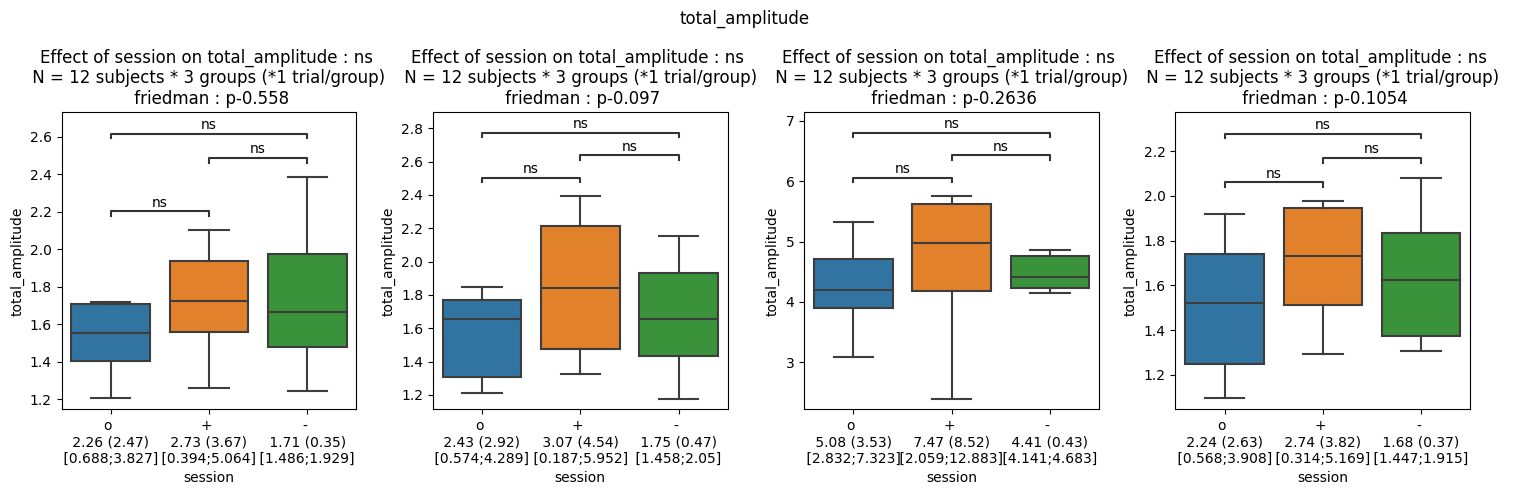

In [111]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_allsujet.query(f"cond == '{cond}' and select_best == 'NO'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(outcome_i)
    plt.tight_layout()

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


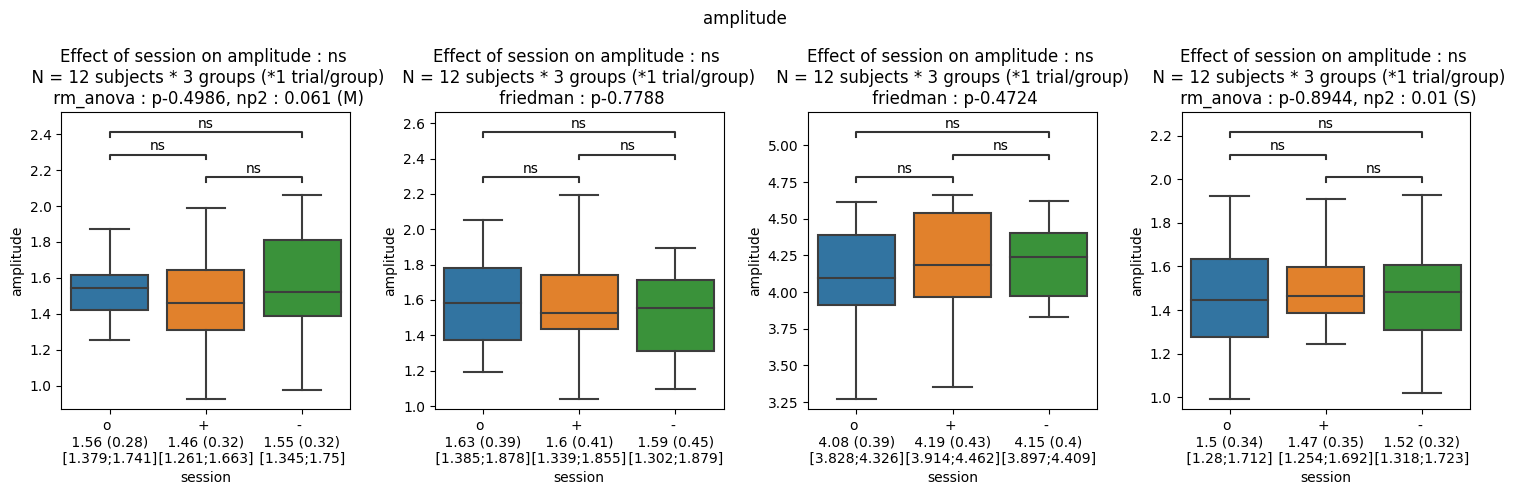

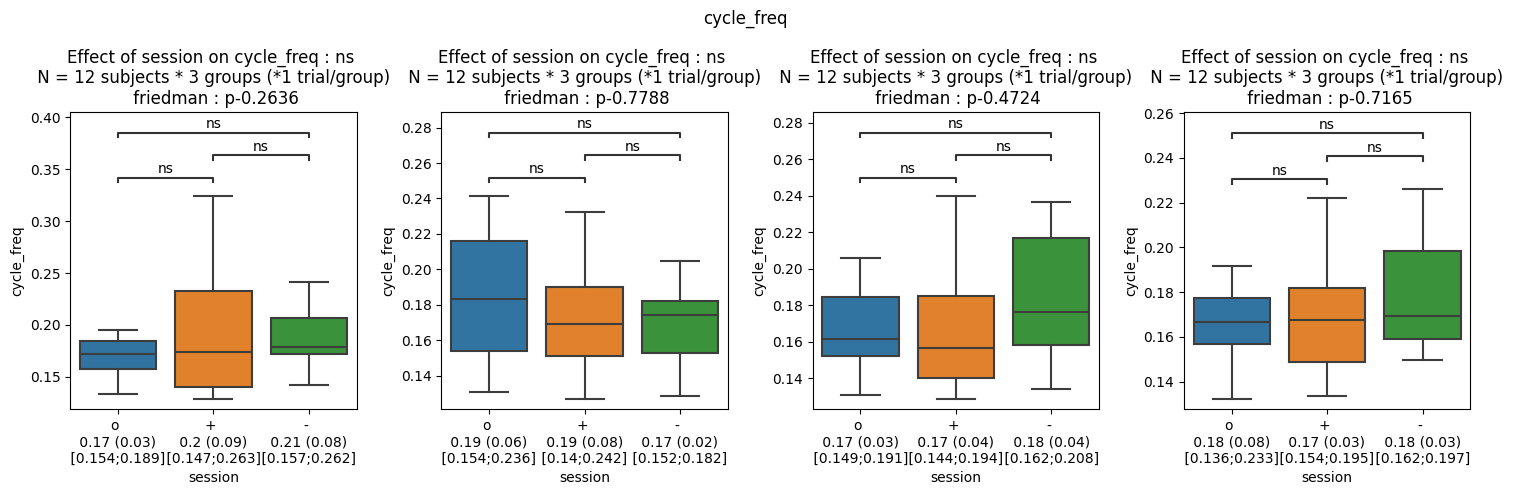

In [112]:
predictor = 'session' 

print(conditions)

for outcome_i in ['amplitude', 'cycle_freq']:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_mean_stats.query(f"cond == '{cond}' and select_best == 'NO'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(outcome_i)
    plt.tight_layout()

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


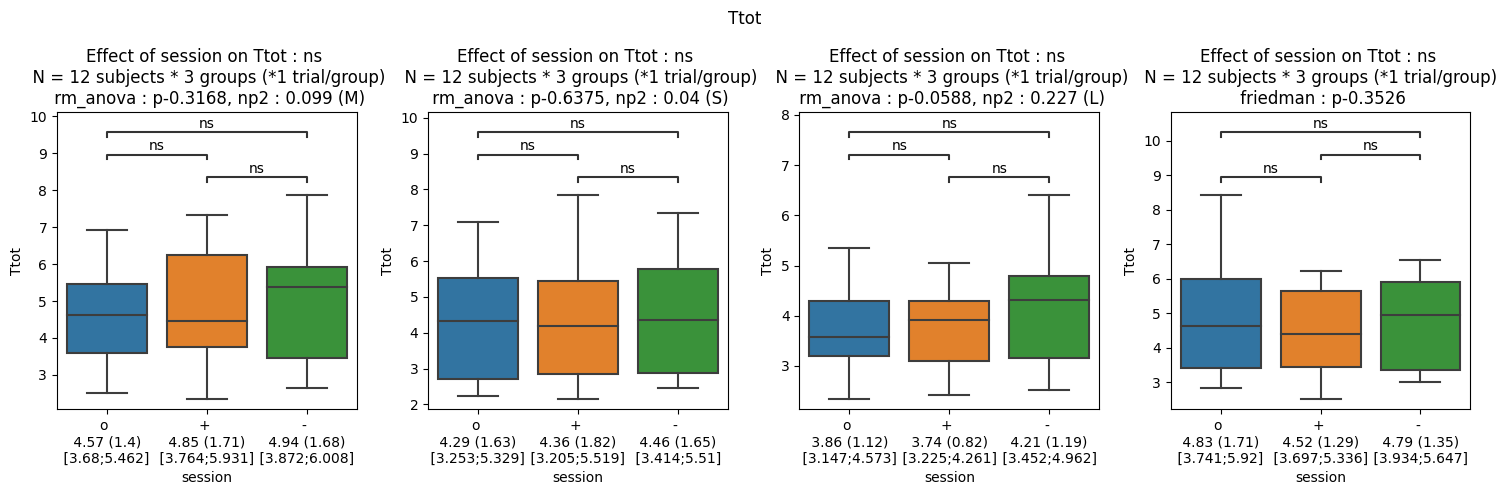

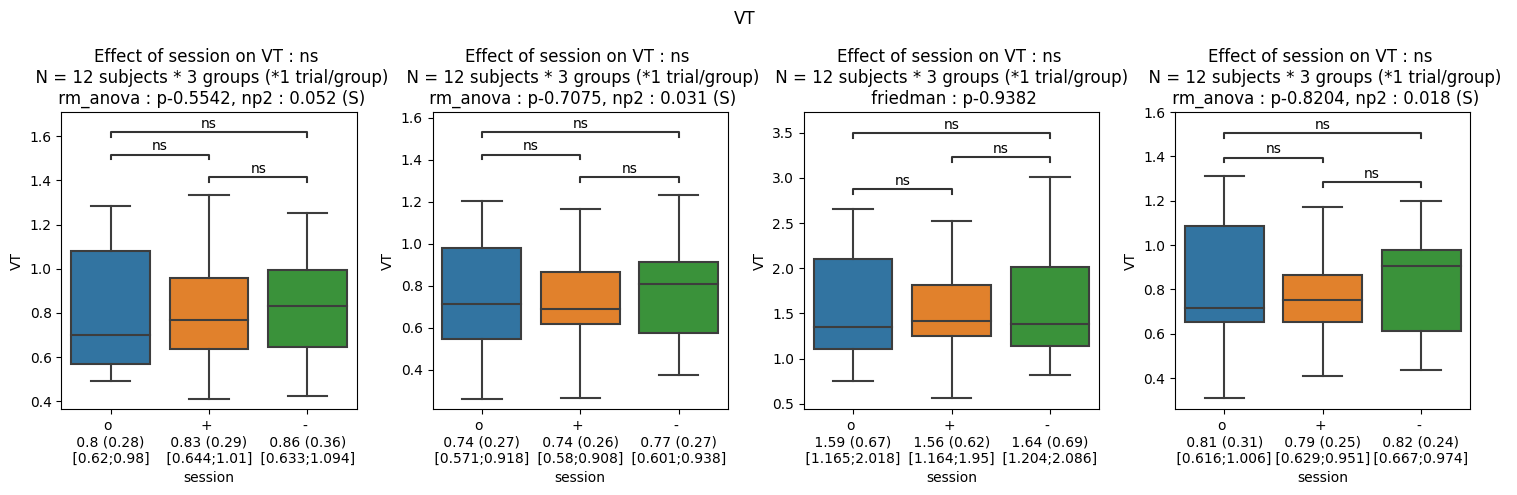

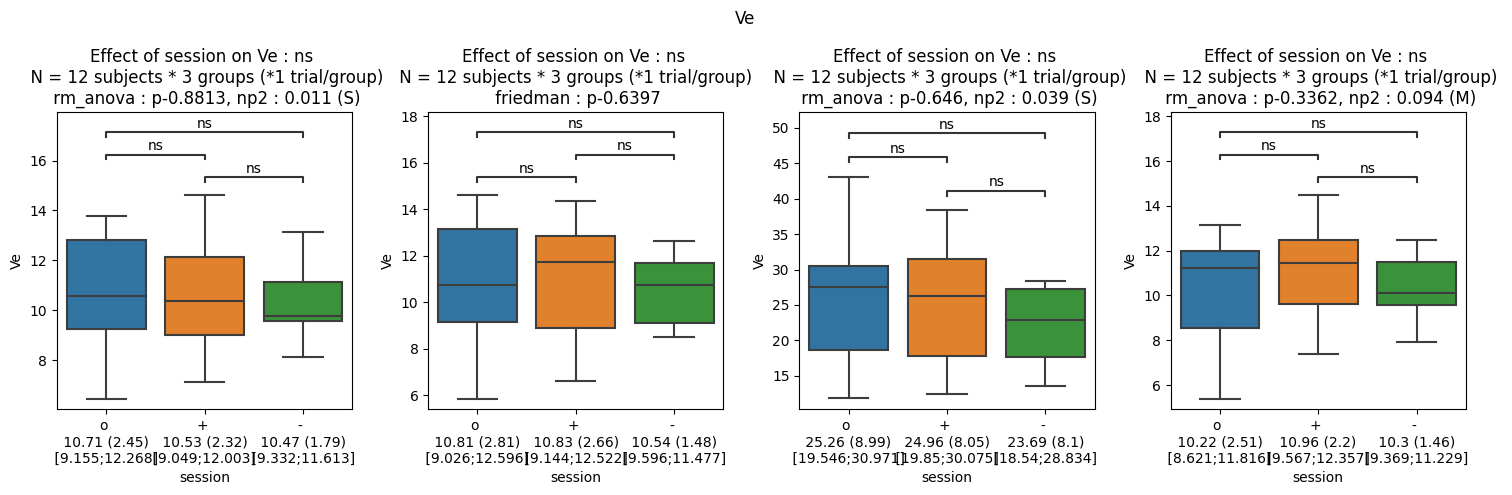

In [113]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_paris:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_paris.query(f"cond == '{cond}' and select_best == 'NO'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(outcome_i)
    plt.tight_layout()

## good versus bad respi

/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


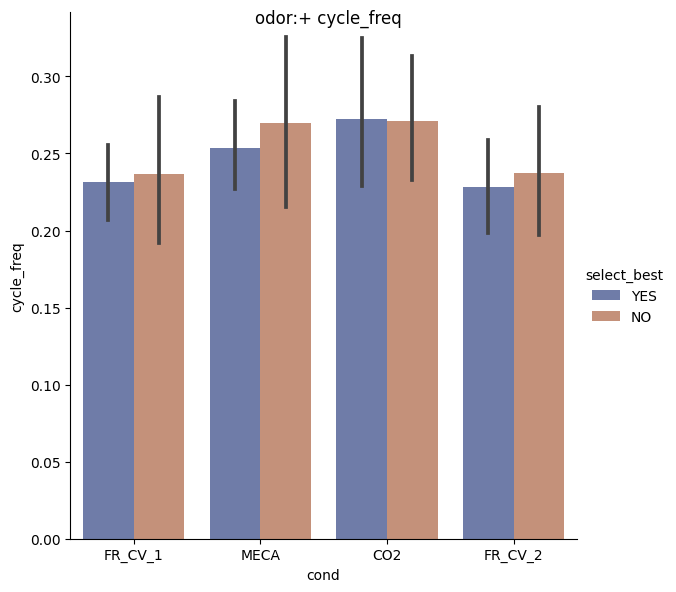

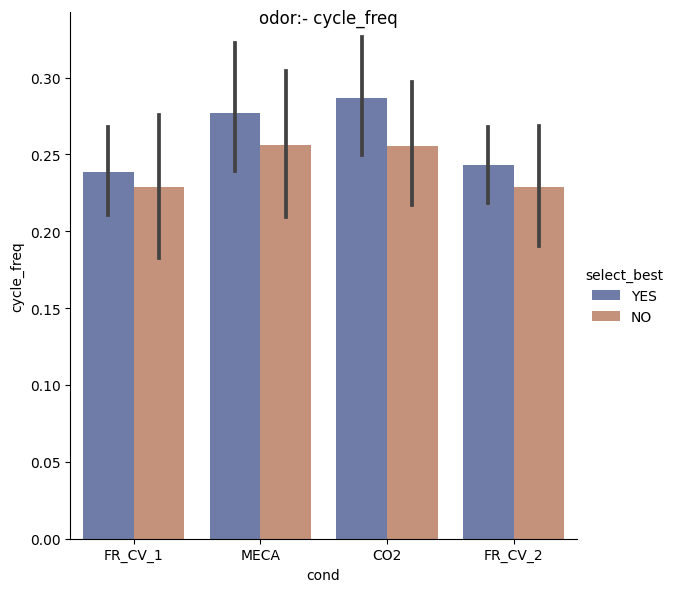

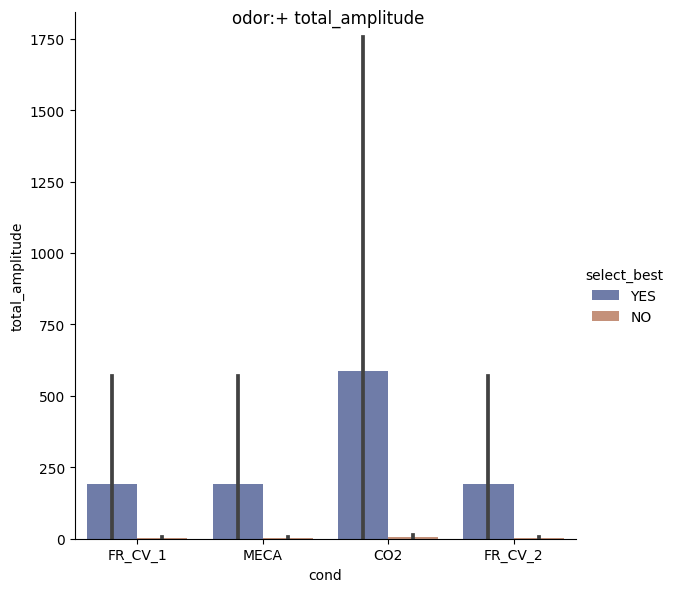

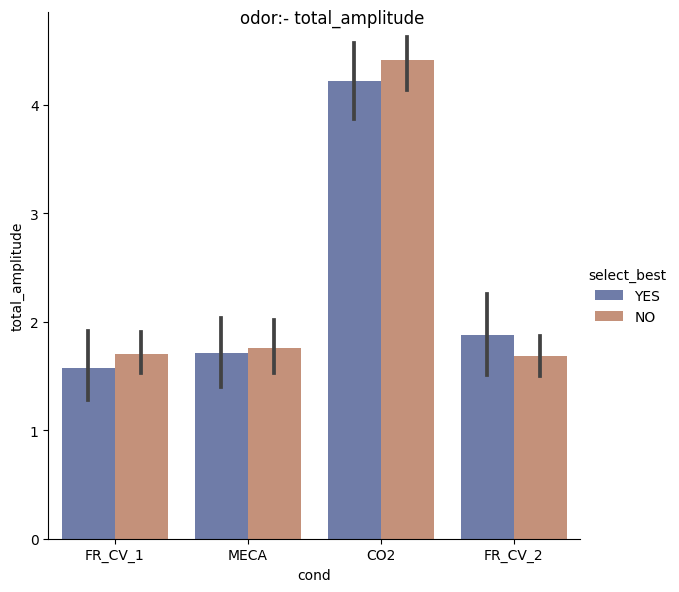

In [114]:
for metric in ['cycle_freq', 'total_amplitude']:
    for odor in ['+', '-']:
        df_plot = df_allsujet.query(f"session == '{odor}'")
        sns.catplot(data=df_plot, kind="bar", x="cond", y=metric, hue="select_best", palette="dark", alpha=.6, height=6)
        plt.suptitle(f"odor:{odor} {metric}")

/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jules/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tigh

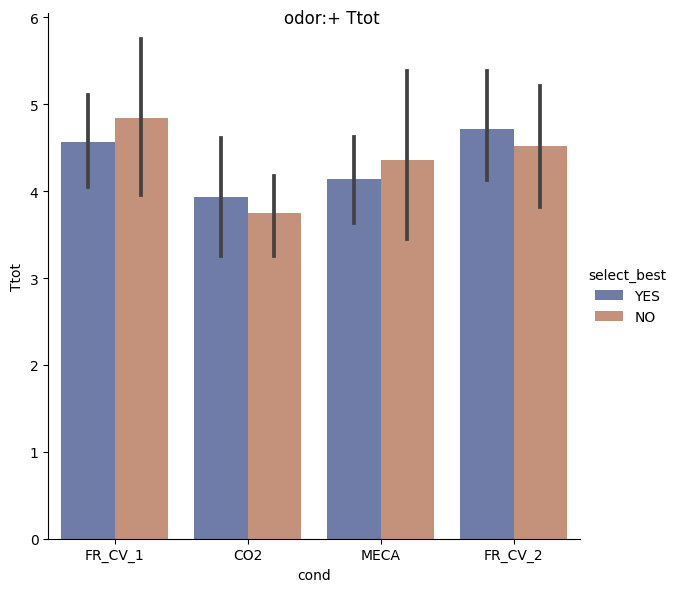

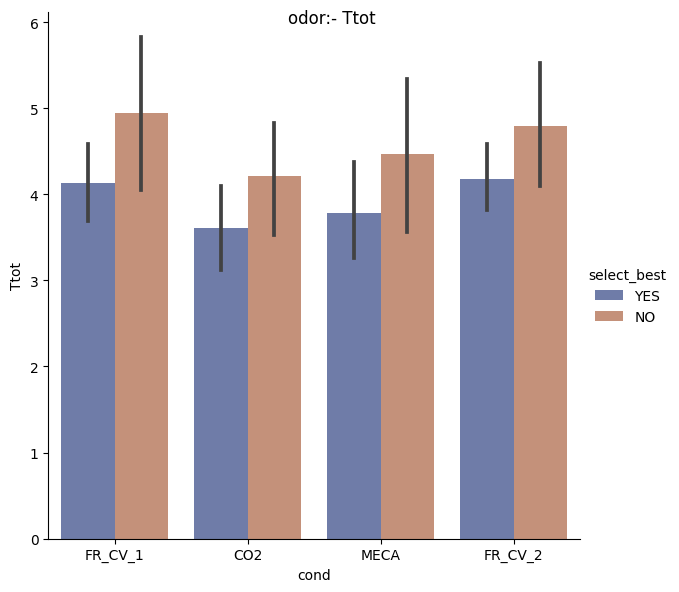

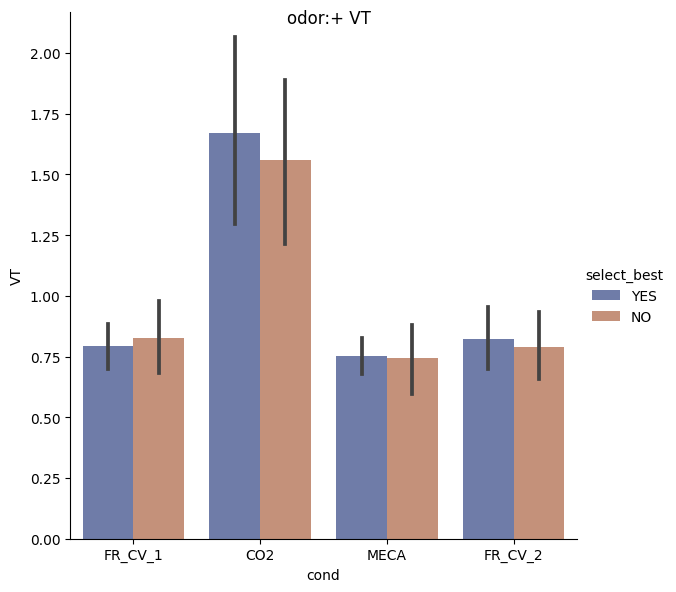

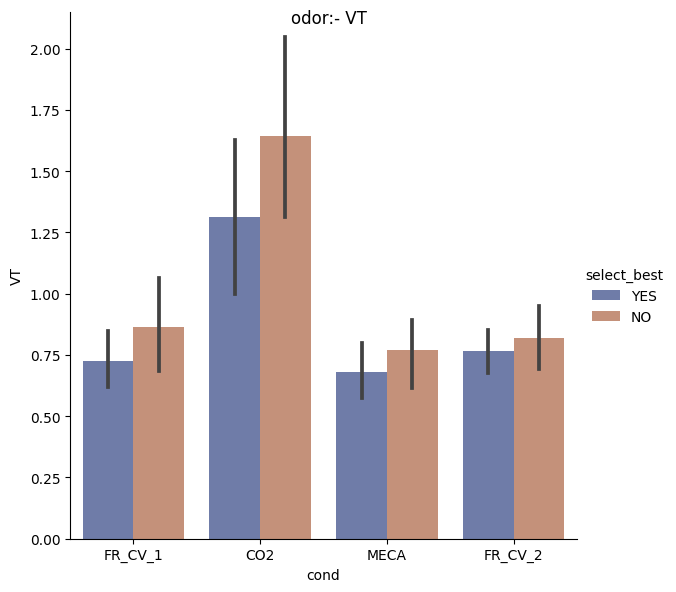

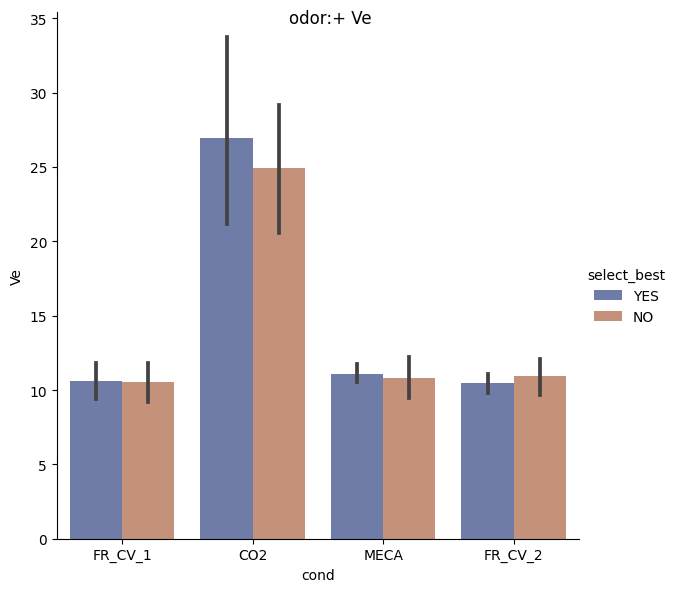

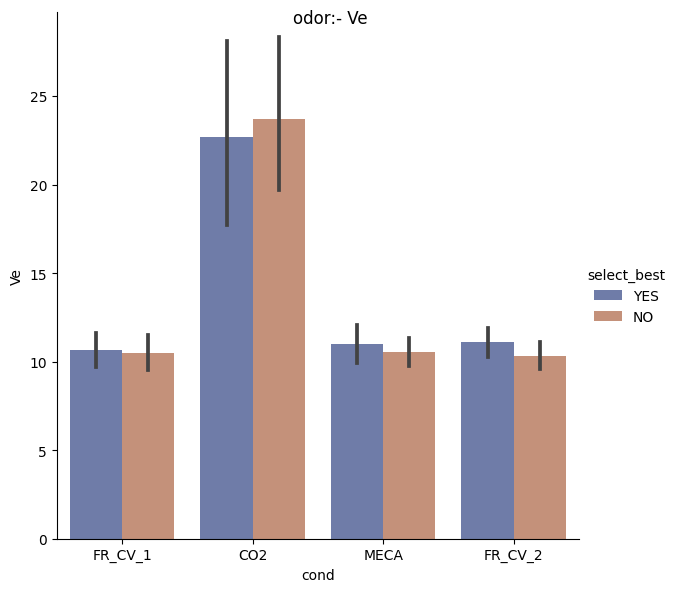

In [115]:
for metric in ['Ttot', 'VT', 'Ve']:
    for odor in ['+', '-']:
        df_plot = df_respi_paris.query(f"session == '{odor}'")
        sns.catplot(data=df_plot, kind="bar", x="cond", y=metric, hue="select_best", palette="dark", alpha=.6, height=6)
        plt.suptitle(f"odor:{odor} {metric}")

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']
['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


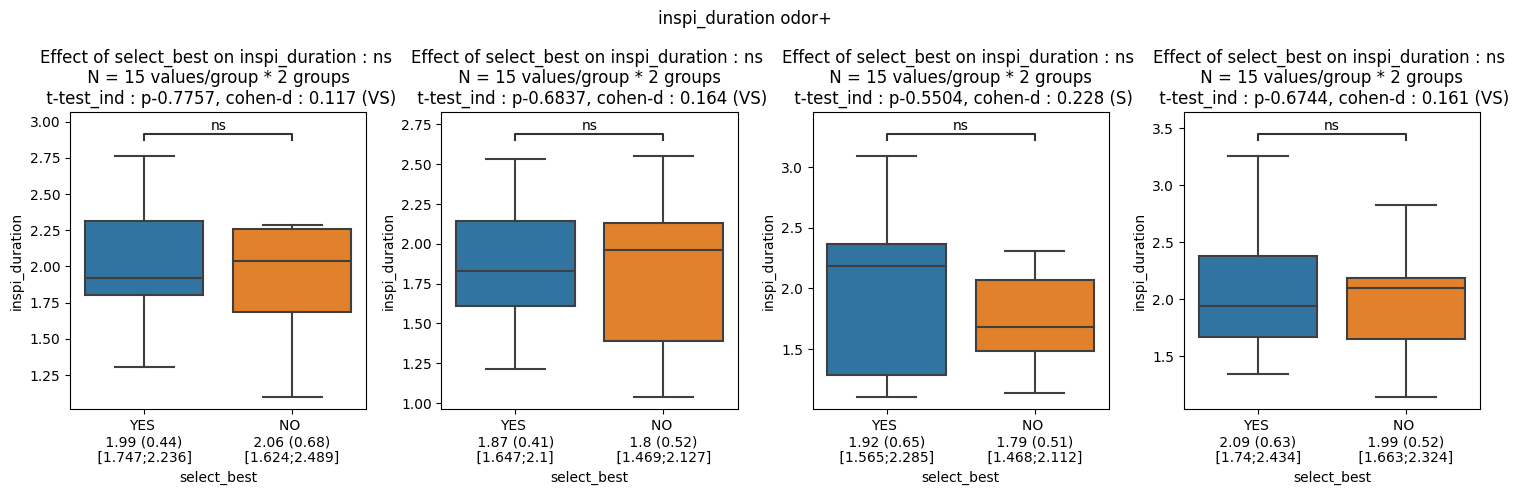

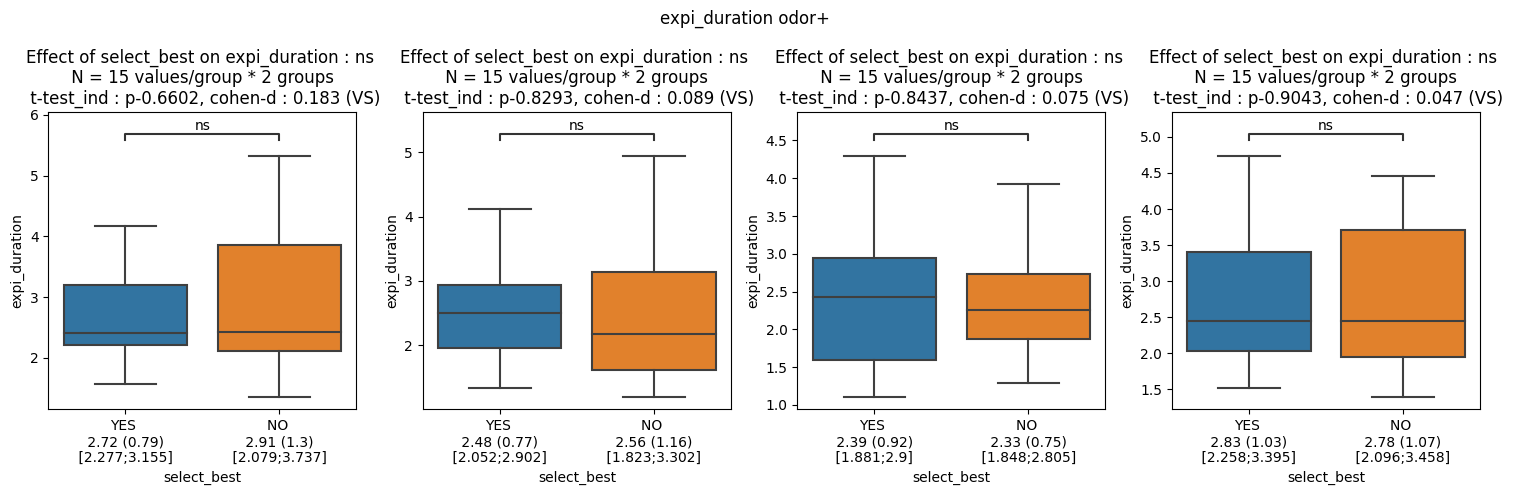

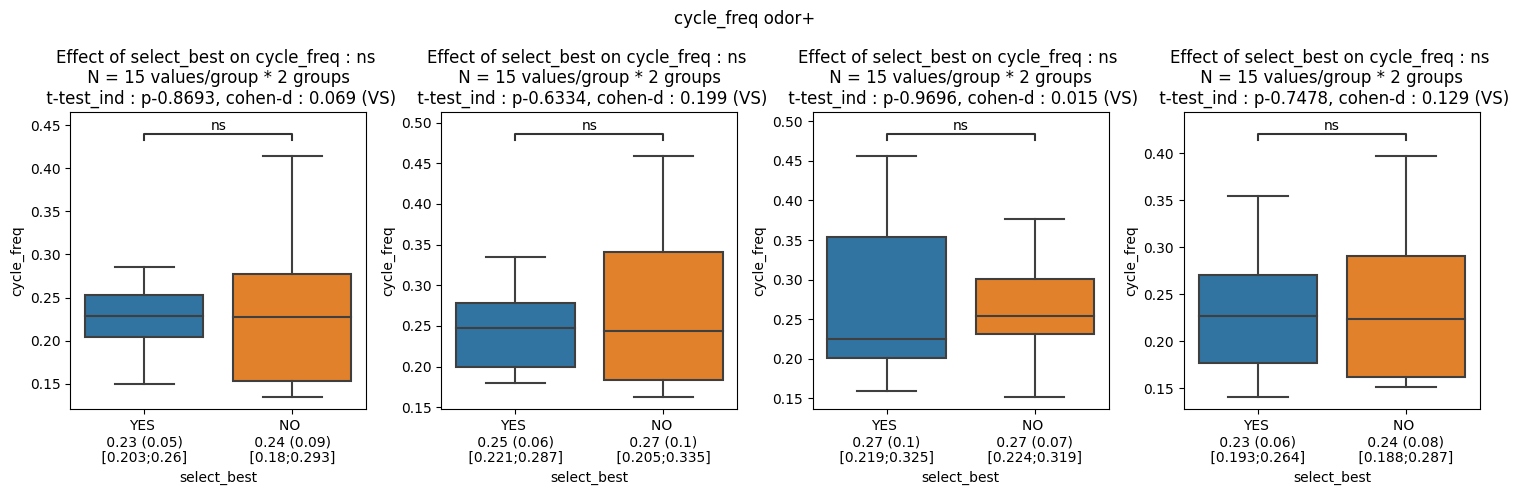

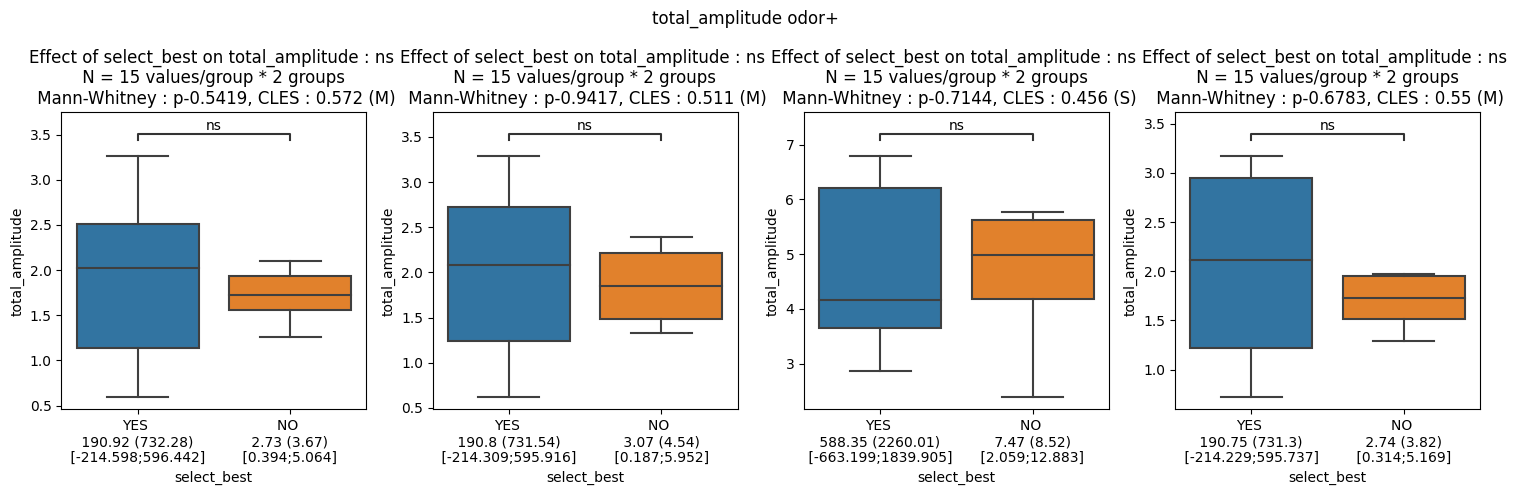

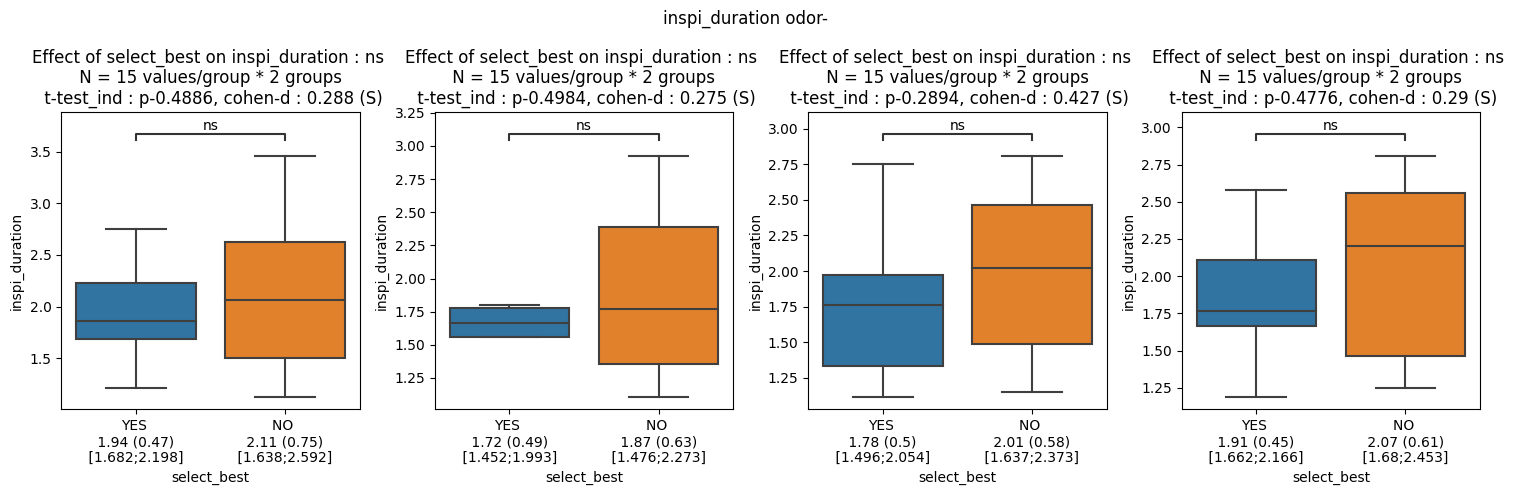

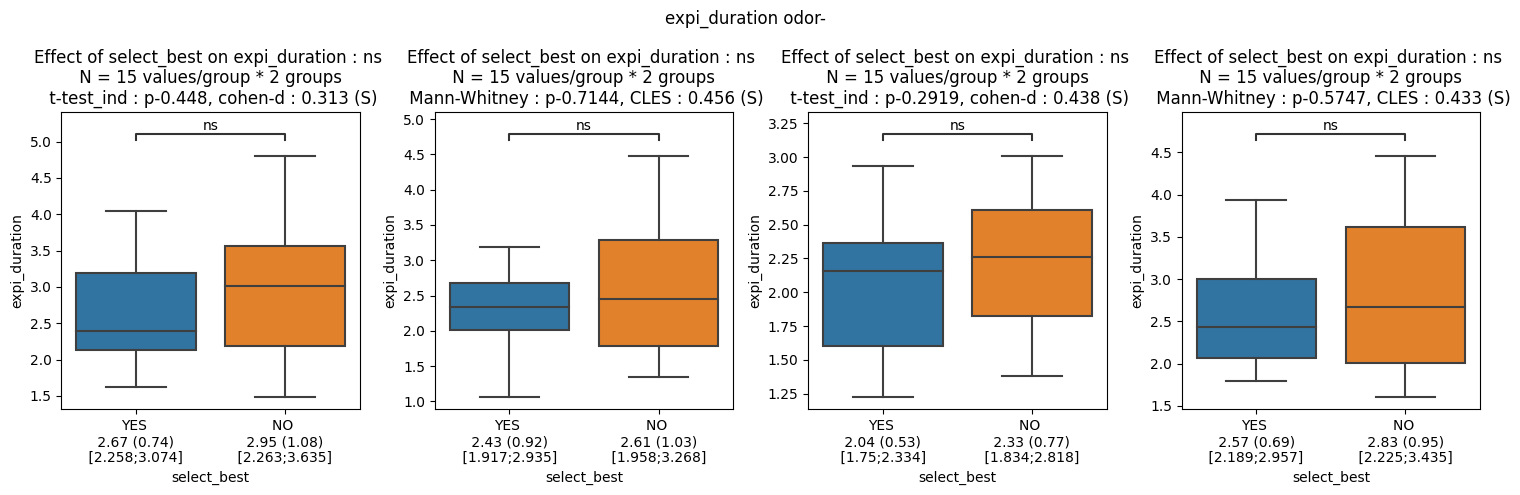

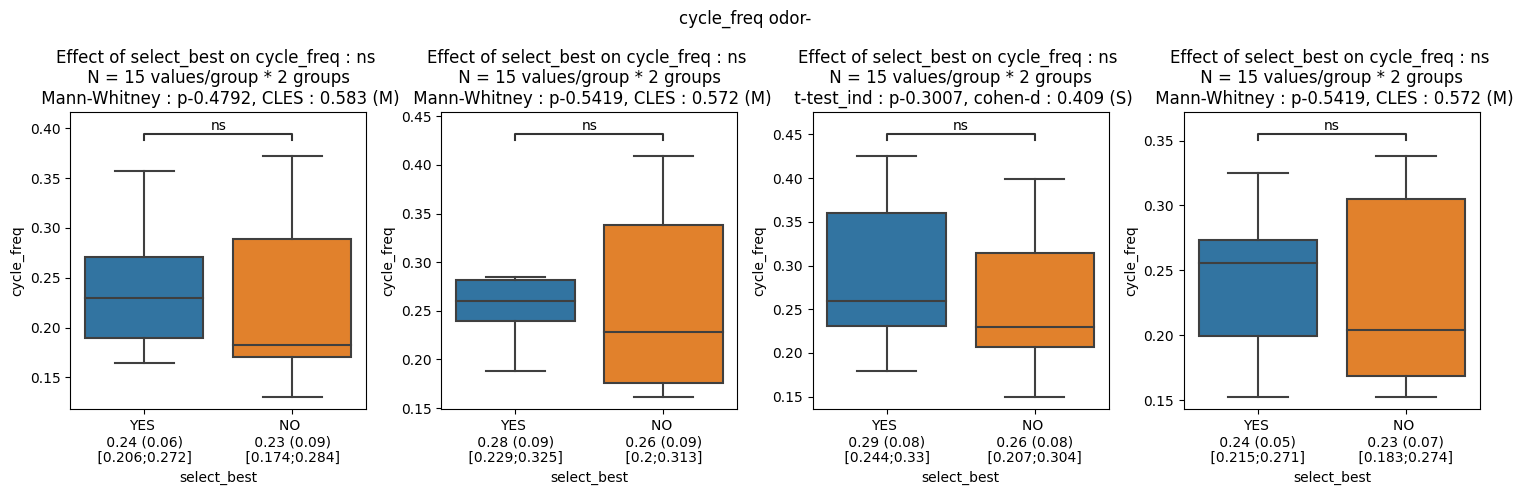

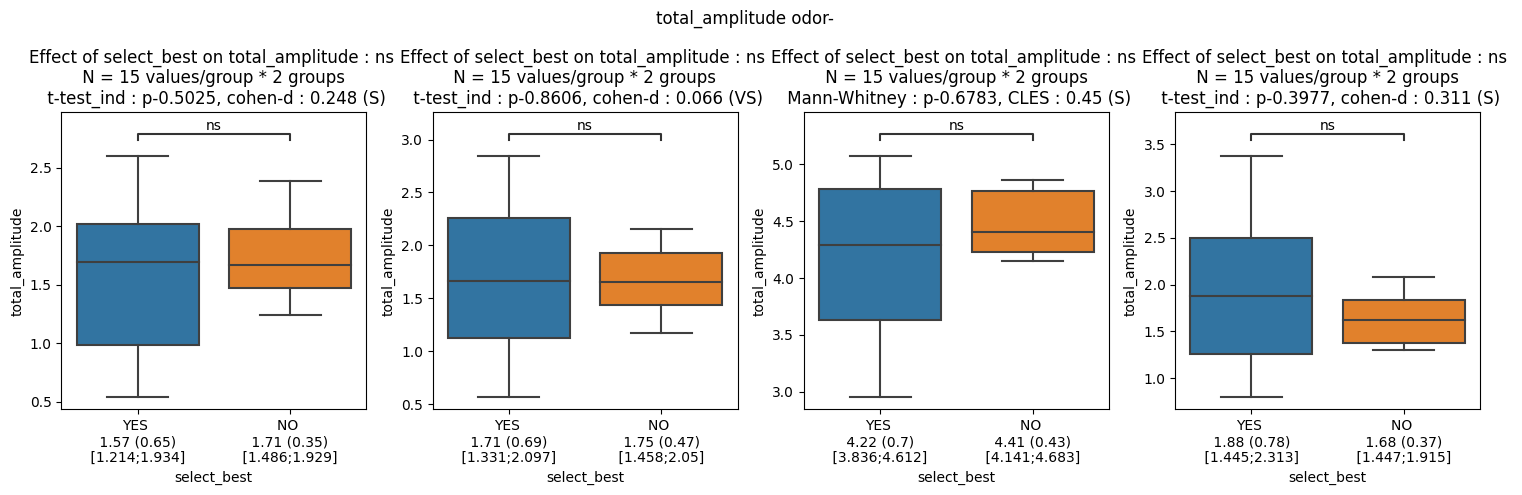

In [125]:
for session in ['+', '-']:

    predictor = 'select_best' 

    print(conditions)

    for outcome_i in metric_list:

        fig, axs = plt.subplots(ncols=4)
        fig.set_figheight(5)
        fig.set_figwidth(15)

        for c, cond in enumerate(conditions):
            
            ax = axs[c]
            df_stats = df_allsujet.query(f"cond == '{cond}' and session == '{session}'")
            auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='between', mode='box', transform=False, verbose=True, order=None)

        plt.suptitle(f"{outcome_i} odor{session}")
        plt.tight_layout()

In [126]:
df_respi_paris

sujet     cond session        TI        Te      Ttot         BF        VT  \
0    01PD  FR_CV_1       o  2.393846  3.008462  5.402308  11.837491  0.562511   
1    03VN  FR_CV_1       o  2.692766  3.617660  6.310426   9.545615  1.157782   
2    05LV  FR_CV_1       o  2.435536  2.843929  5.279464  11.626768  0.567217   
3    06EF  FR_CV_1       o  1.649000  2.068875  3.717875  16.298862  0.493380   
4    07PB  FR_CV_1       o  1.304717  1.504906  2.809623  21.771218  0.649400   
..    ...      ...     ...       ...       ...       ...        ...       ...   
319  29SC  FR_CV_2       -  1.671310  1.872262  3.543571  17.294815  0.731305   
320  30AR  FR_CV_2       -  1.427614  1.934886  3.362500  18.019880  0.577633   
321  31HJ  FR_CV_2       -  1.783425  2.277945  4.061370  14.811920  0.796478   
322  32CM  FR_CV_2       -  1.853947  2.058684  3.912632  15.556511  0.727632   
323  33MA  FR_CV_2       -  2.374615  2.178154  4.552769  13.657869  0.505092   

            Ve     VT_Ti    Ti_Ttot     PRESS     PetCO2  VAS_S  VAS_A  \
0     6.121682  0.229809  44.118335 -1.814150  30.619312    NaN    NaN   
1    11.013808  0.430079  42.714931 -4.095677  41.109311    NaN    NaN   
2     6.446338  0.233685  46.081250 -2.445666  38.509328    NaN    NaN   
3     8.047073  0.300471  44.566152 -2.818668  31.008479    NaN    NaN   
4    13.772378  0.494112  46.423333 -4.087813  37.777710    NaN    NaN   
..         ...       ...        ...       ...        ...    ...    ...   
319  12.333833  0.435322  47.230747 -4.246468  37.879662    NaN    NaN   
320  10.280461  0.403985  42.511473 -3.152908  36.640867    NaN    NaN   
321  11.779759  0.446903  43.984879 -3.927595  37.493090    NaN    NaN   
322  11.142399  0.391526  47.546784 -3.904454  37.805881    NaN    NaN   
323   6.674845  0.216982  51.719452 -2.272483  34.220138    NaN    NaN   

    select_best  
0           YES  
1           YES  
2            NO  
3            NO  
4            NO  
..          ...  
319         YES  
320          NO  
321         YES  
322         YES  
323         YES  

[324 rows x 16 columns]

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']
['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


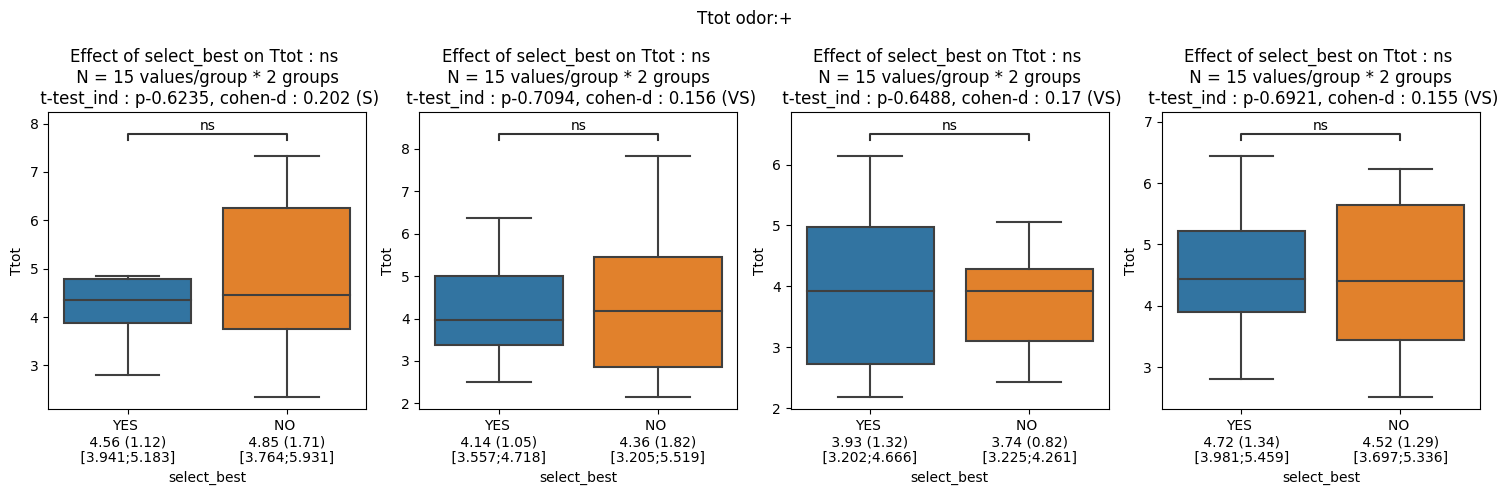

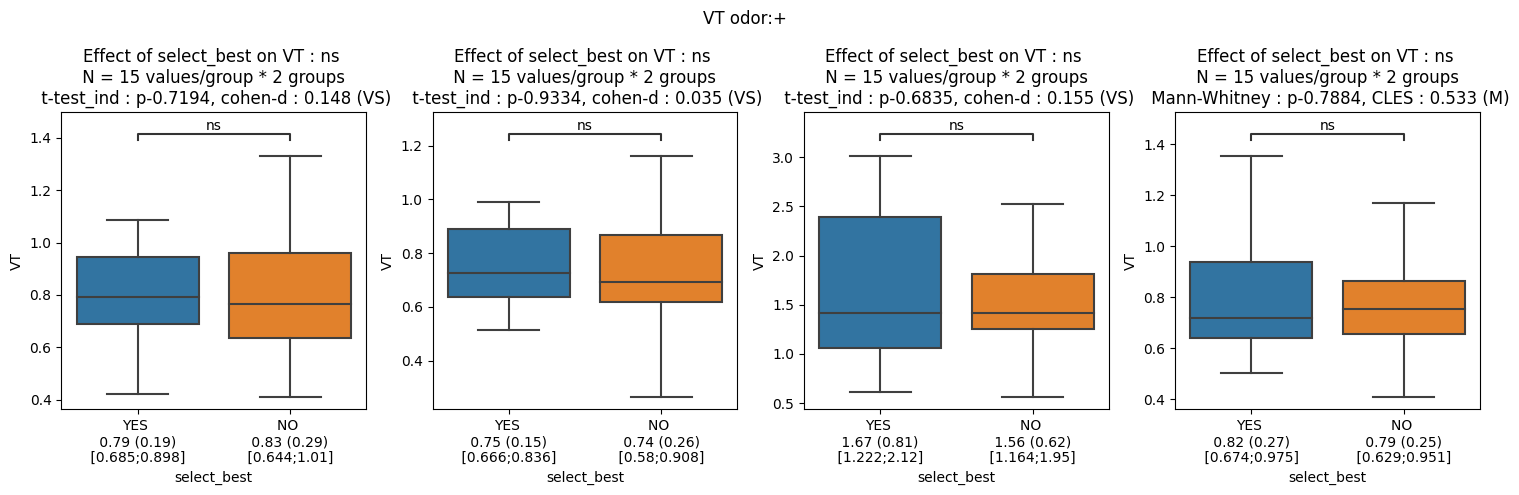

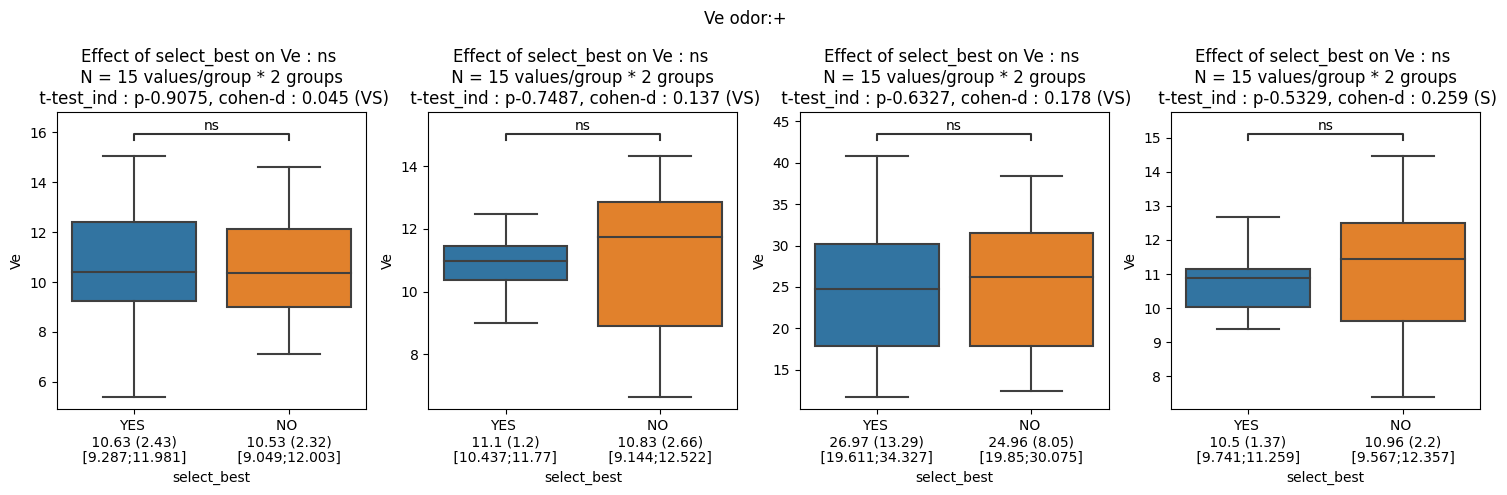

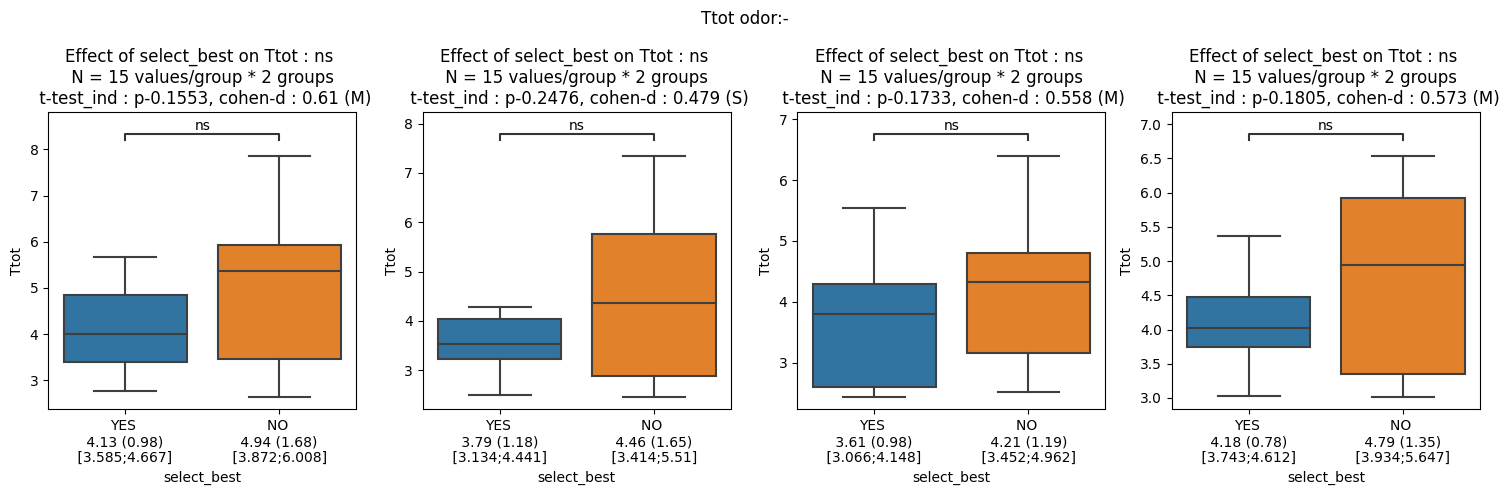

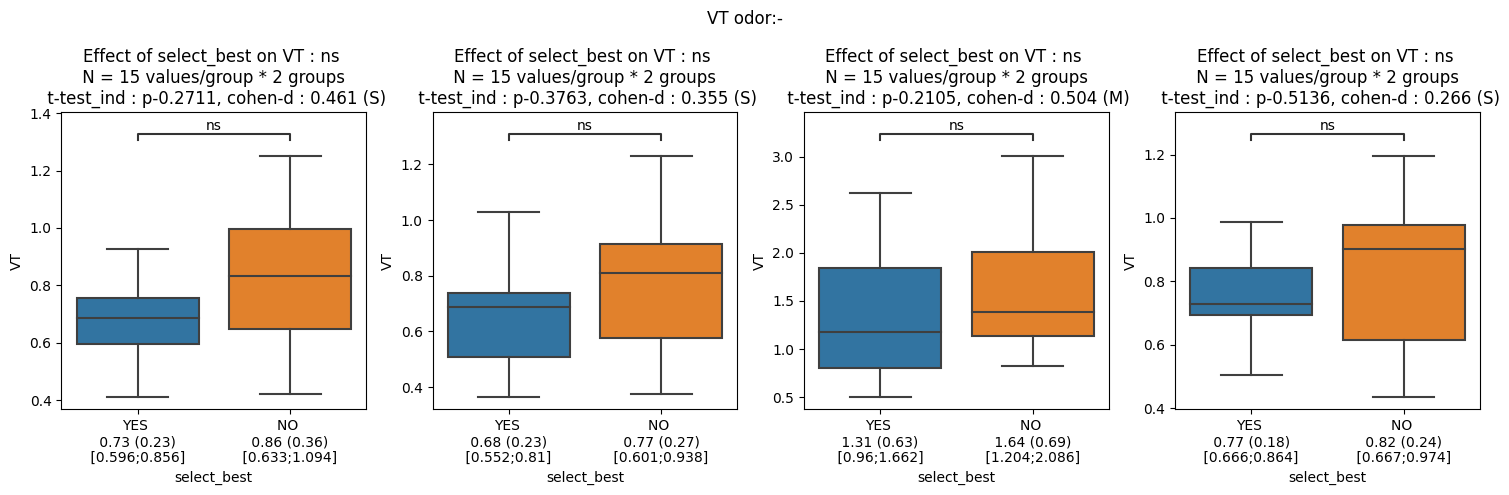

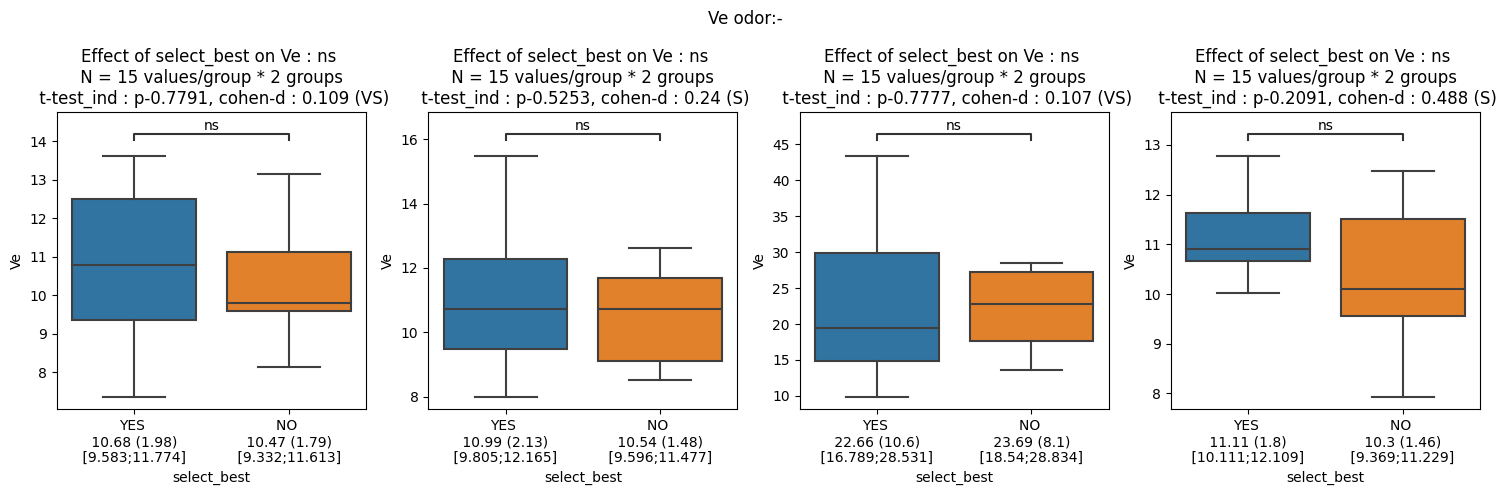

In [143]:
for session in ['+', '-']:

    predictor = 'select_best' 

    print(conditions)

    for outcome_i in metric_paris:

        fig, axs = plt.subplots(ncols=4)
        fig.set_figheight(5)
        fig.set_figwidth(15)

        for c, cond in enumerate(conditions):
            
            ax = axs[c]
            df_stats = df_respi_paris.query(f"cond == '{cond}' and session == '{session}'")
            auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='between', mode='box', transform=False, verbose=True, order=None)

        plt.suptitle(f"{outcome_i} odor:{session}")
        plt.tight_layout()

# SIGNAL ACROSS TIME

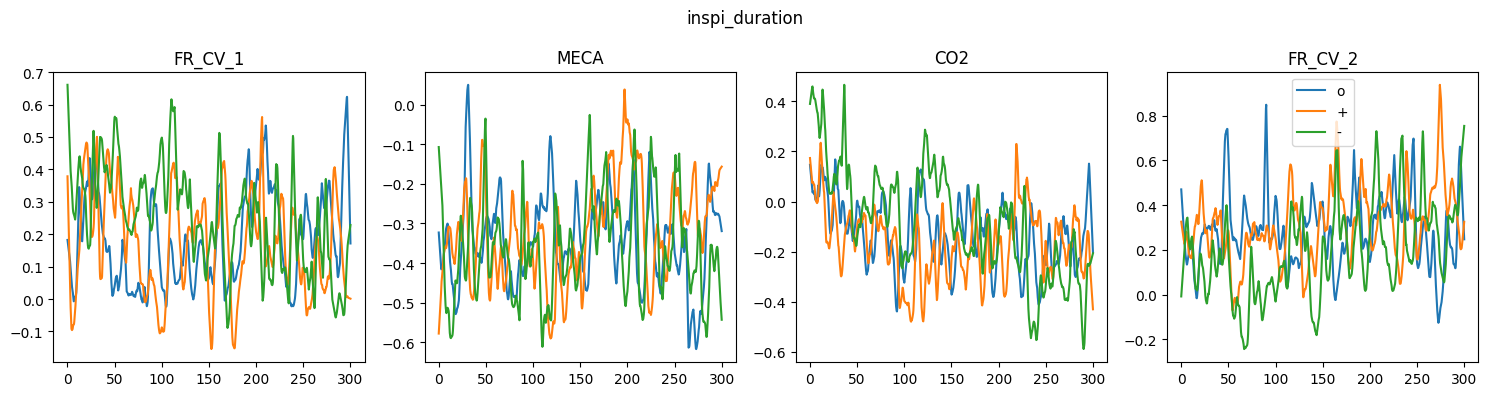

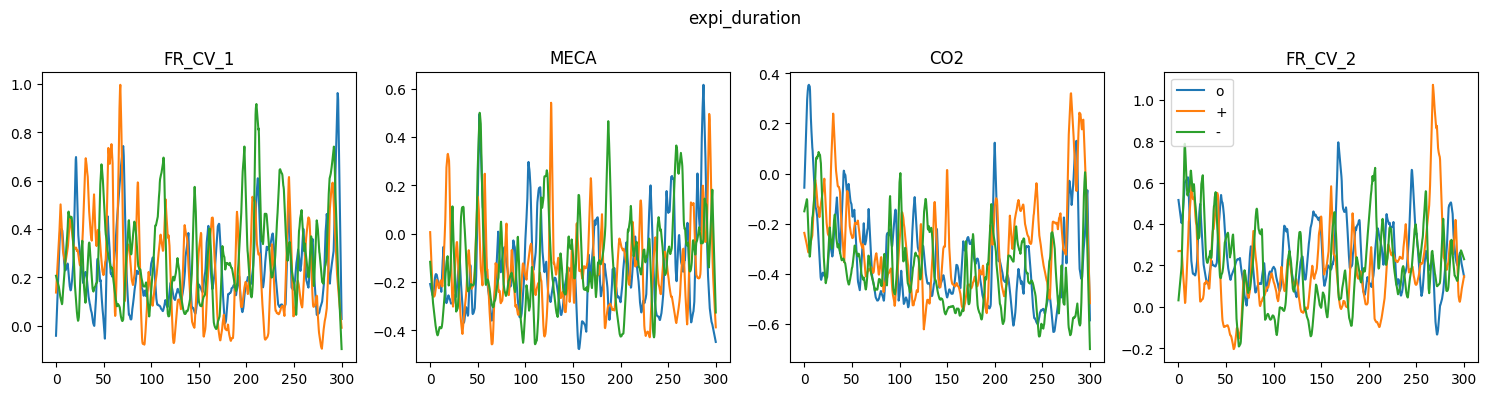

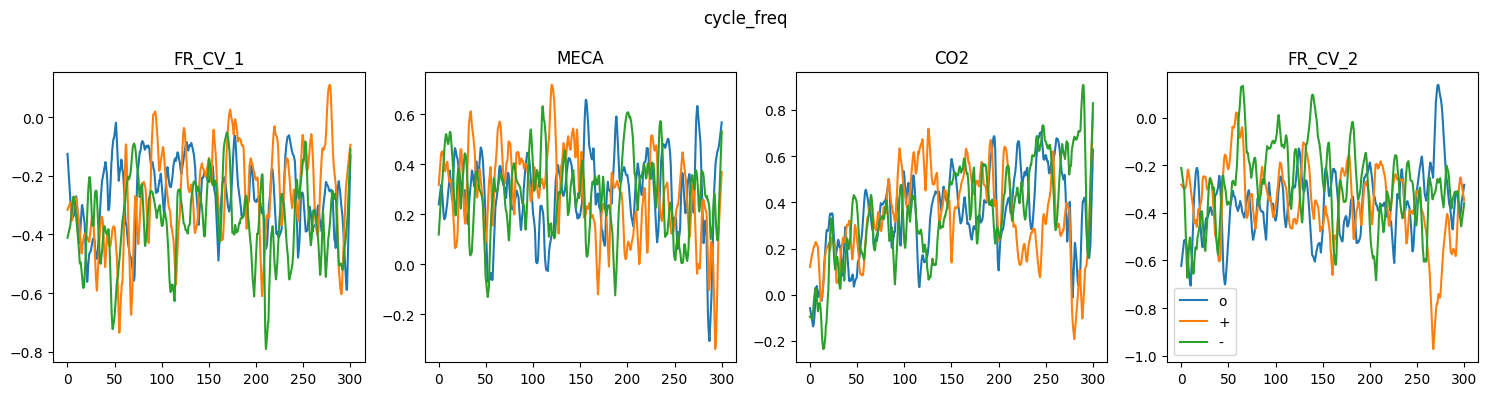

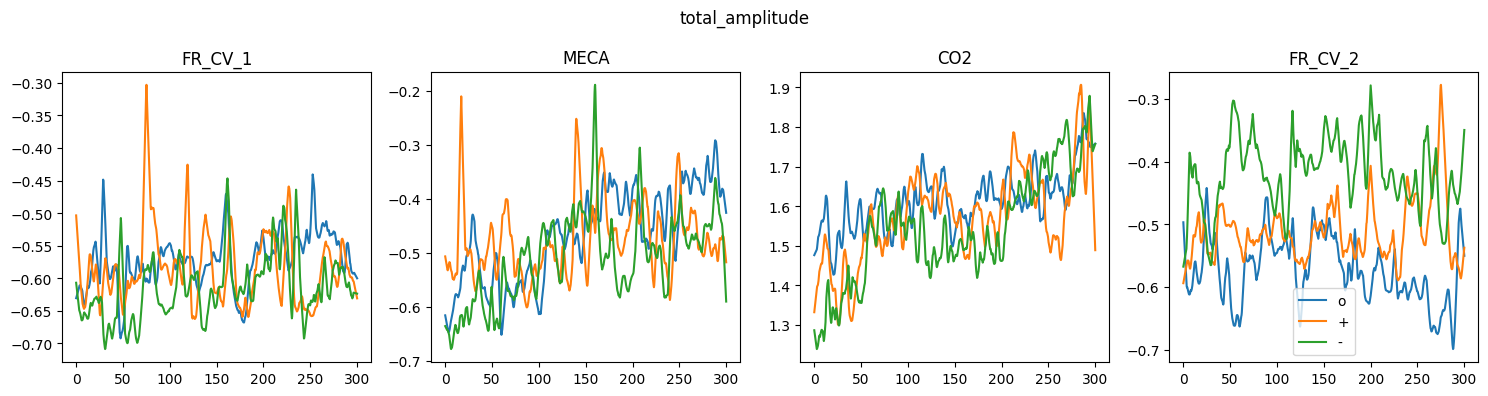

In [144]:
time = np.linspace(0,300,1000)

for metric in metric_list:

    fig, axs = plt.subplots(ncols=len(conditions), figsize=(15,4))

    for cond_i, cond in enumerate(conditions):

        ax = axs[cond_i]
    
        ax.plot(time, xr_respi_allsig.loc[:, cond, 'o', metric, :].mean('sujet').values, label='o')
        ax.plot(time, xr_respi_allsig.loc[:, cond, '+', metric, :].mean('sujet').values, label='+')
        ax.plot(time, xr_respi_allsig.loc[:, cond, '-', metric, :].mean('sujet').values, label='-')

        ax.set_title(cond)

    plt.suptitle(f"{metric}")
    plt.tight_layout()
    plt.legend()
    plt.show()


# EFFECT ODOR CHUNK

## chunkdata

In [145]:
xr_respi_allsig

<xarray.DataArray (sujet: 27, cond: 4, session: 3, metric: 4, time: 1000)>
array([[[[[-5.30095471e-01, -5.33788697e-01, -5.37481923e-01, ...,
           -6.69742787e-01, -7.23152521e-01, -7.76562256e-01],
          [ 1.15075312e-01,  2.16796775e-01,  3.18518238e-01, ...,
           -6.23627987e-03, -2.61591277e-02, -4.60819755e-02],
          [-1.50206343e-01, -1.99860987e-01, -2.49515631e-01, ...,
            4.70406913e-02,  8.45589732e-02,  1.22077255e-01],
          [-1.06563688e+00, -1.07643289e+00, -1.08722891e+00, ...,
           -1.68428683e+00, -1.72327458e+00, -1.76226232e+00]],

         [[ 2.79676937e+00,  2.60131841e+00,  2.40586745e+00, ...,
           -3.63830794e-01, -3.24676415e-01, -2.85522035e-01],
          [ 8.60419816e-02,  7.62981981e-02,  6.65544146e-02, ...,
           -3.49326135e-01, -3.53792036e-01, -3.58257937e-01],
          [-1.14524676e+00, -1.07819815e+00, -1.01114954e+00, ...,
            1.94062632e-01,  1.84909561e-01,  1.75756491e-01],
          [ 6.33948022e-01,  5.55685861e-01,  4.77423701e-01, ...,
           -3.91562651e-02, -2.01832227e-02, -1.21018036e-03]],

         [[-1.56606884e+00, -1.48694529e+00, -1.40782174e+00, ...,
           -4.96322296e-01, -4.14411197e-01, -3.32500097e-01],
...
          [-4.74249446e-01, -4.92082709e-01, -5.09915972e-01, ...,
           -6.87283675e-01, -6.71369271e-01, -6.55454868e-01]],

         [[-7.35381004e-01, -7.62886630e-01, -7.90392255e-01, ...,
           -4.74534226e-01, -4.08361273e-01, -3.42188319e-01],
          [-6.39942591e-01, -6.59191626e-01, -6.78440660e-01, ...,
           -9.83105651e-02, -1.62752985e-01, -2.27195405e-01],
          [ 6.63817158e-01,  7.00939438e-01,  7.38061717e-01, ...,
            8.32344292e-02,  9.60540498e-02,  1.08873670e-01],
          [ 2.66399693e-01,  2.73497166e-01,  2.80594639e-01, ...,
           -7.21588222e-01, -6.69269076e-01, -6.16949931e-01]],

         [[-6.33484761e-01, -5.89941450e-01, -5.46398138e-01, ...,
           -1.32475477e+00, -1.30488115e+00, -1.28500754e+00],
          [-3.26675784e-01, -3.21875330e-01, -3.17074876e-01, ...,
           -4.57240510e-01, -4.64907902e-01, -4.72575294e-01],
          [ 4.27378924e-01,  3.94903386e-01,  3.62427847e-01, ...,
            1.25020472e+00,  1.25516065e+00,  1.26011658e+00],
          [ 3.60290914e-01,  3.63118358e-01,  3.65945801e-01, ...,
           -3.34746869e-01, -3.27946006e-01, -3.21145143e-01]]]]])
Coordinates:
  * sujet    (sujet) <U4 '01PD' '03VN' '05LV' '06EF' ... '31HJ' '32CM' '33MA'
  * cond     (cond) <U7 'FR_CV_1' 'MECA' 'CO2' 'FR_CV_2'
  * session  (session) <U1 'o' '+' '-'
  * metric   (metric) <U15 'inspi_duration' ... 'total_amplitude'
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [146]:
sec_to_chunk = 10

In [147]:
i_chunk = (10*xr_respi_allsig['time'].shape[0])/300
df_respi_chunk = xr_respi_allsig.loc[:, :, :, :, :i_chunk].median(['time']).to_dataframe(name='').reset_index()
df_respi_chunk = df_respi_chunk.rename(columns={'': 'value'})

for row_i in range(df_respi_chunk.shape[0]):

    df_respi_chunk['sujet'].iloc[row_i] = f"{df_respi_chunk['sujet'].iloc[row_i][-2:]}{df_respi_chunk['sujet'].iloc[row_i][:2]}"


/tmp/ipykernel_2961/2320824667.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_respi_chunk['sujet'].iloc[row_i] = f"{df_respi_chunk['sujet'].iloc[row_i][-2:]}{df_respi_chunk['sujet'].iloc[row_i][:2]}"


In [148]:
data = {'sujet' : [], 'cond' : [], 'session' : []}

for metric in df_respi_chunk['metric'].unique():

    data[metric] = []

for sujet in df_respi_chunk['sujet'].unique():

    for cond in df_respi_chunk['cond'].unique():

        for session in df_respi_chunk['session'].unique():

            data['sujet'].append(sujet)
            data['cond'].append(cond)
            data['session'].append(session)

            for metric in df_respi_chunk['metric'].unique():

                data[metric].append(df_respi_chunk.query(f"sujet == '{sujet}' and cond == '{cond}' and session == '{session}' and metric == '{metric}'")['value'].values[0])

df_respi_chunk = pd.DataFrame(data)
df_respi_chunk

sujet     cond session  inspi_duration  expi_duration  cycle_freq  \
0    PD01  FR_CV_1       o       -0.591034       1.793479   -0.969508   
1    PD01  FR_CV_1       +       -0.428171      -0.054890   -0.038945   
2    PD01  FR_CV_1       -       -0.665043      -0.136271    0.027086   
3    PD01     MECA       o       -0.373126      -0.501641    0.337275   
4    PD01     MECA       +       -0.447984      -0.622865    0.766484   
..    ...      ...     ...             ...            ...         ...   
319  MA33      CO2       +        1.719568       0.433227   -1.042136   
320  MA33      CO2       -        0.878969      -0.126962   -0.590992   
321  MA33  FR_CV_2       o       -0.271887      -0.308488    0.251000   
322  MA33  FR_CV_2       +       -1.024190      -0.813258    1.034552   
323  MA33  FR_CV_2       -       -0.211561      -0.250383    0.066013   

     total_amplitude  
0          -1.189791  
1          -0.657378  
2          -1.364645  
3          -1.946296  
4           0.679938  
..               ...  
319         1.125379  
320         0.657791  
321        -0.639528  
322         0.269948  
323         0.388686  

[324 rows x 7 columns]

## allsujet odor

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


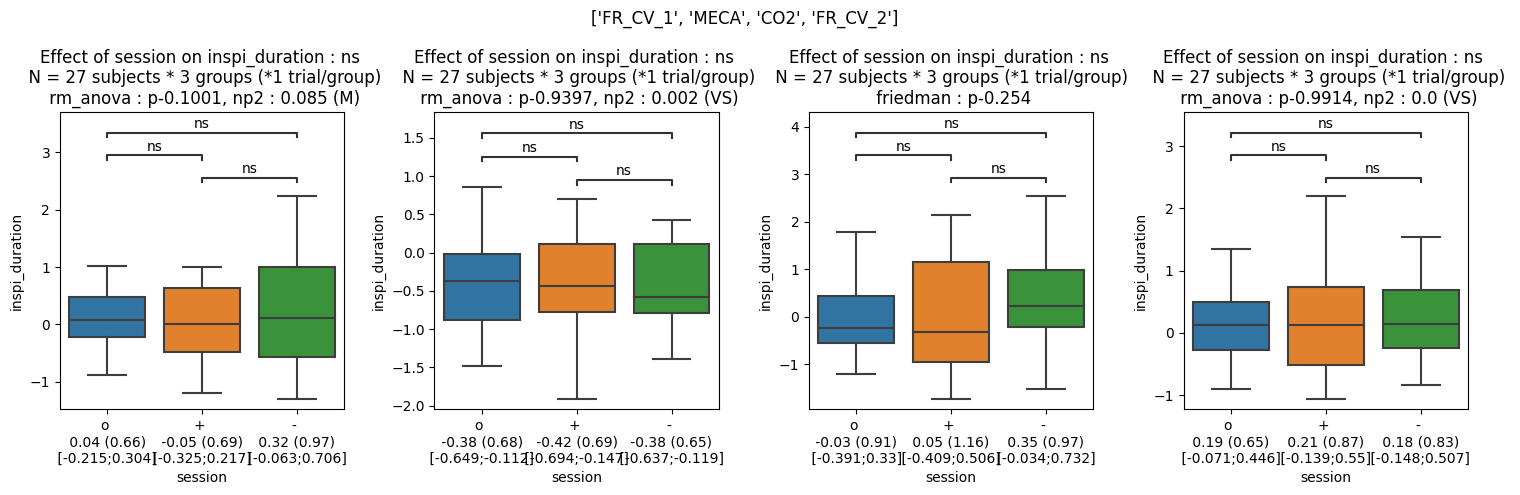

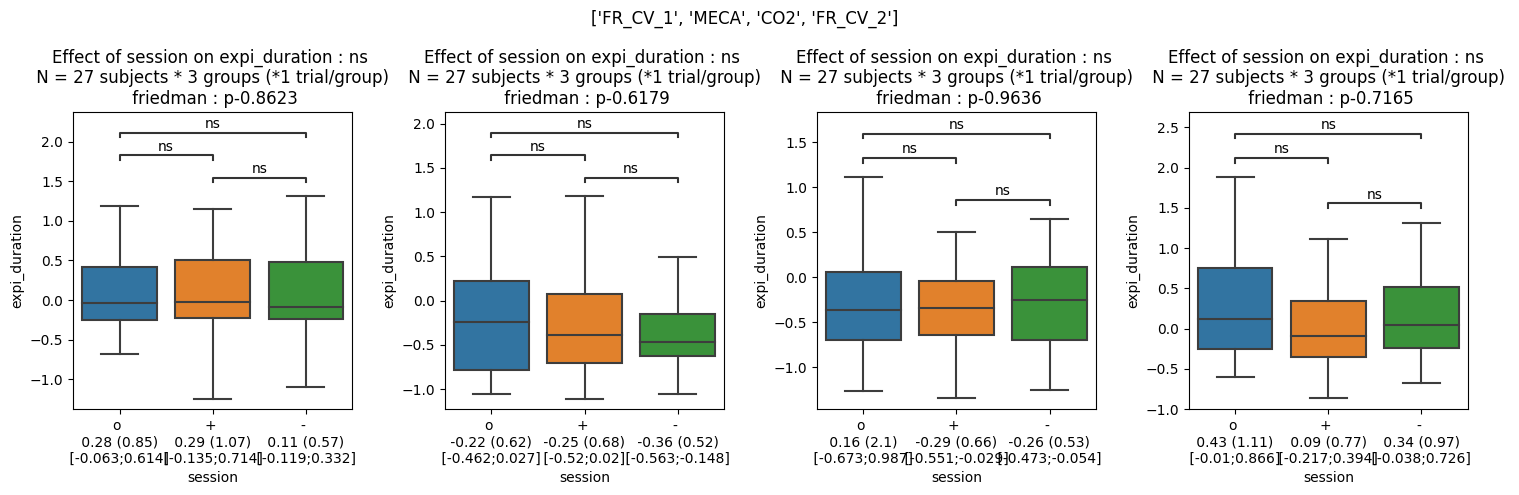

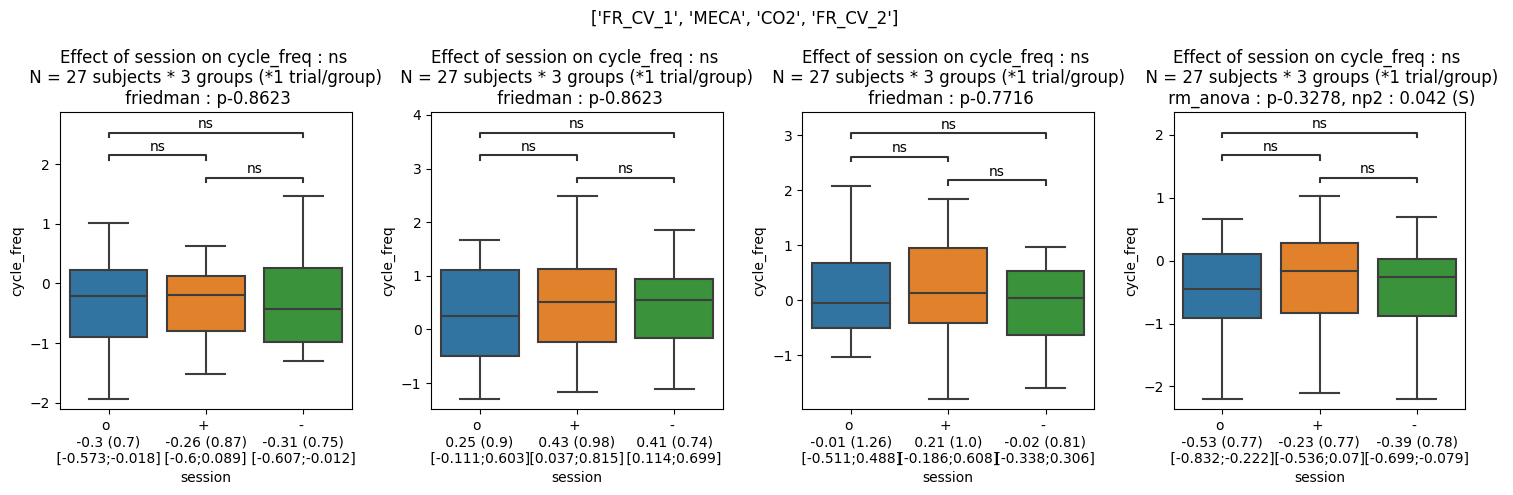

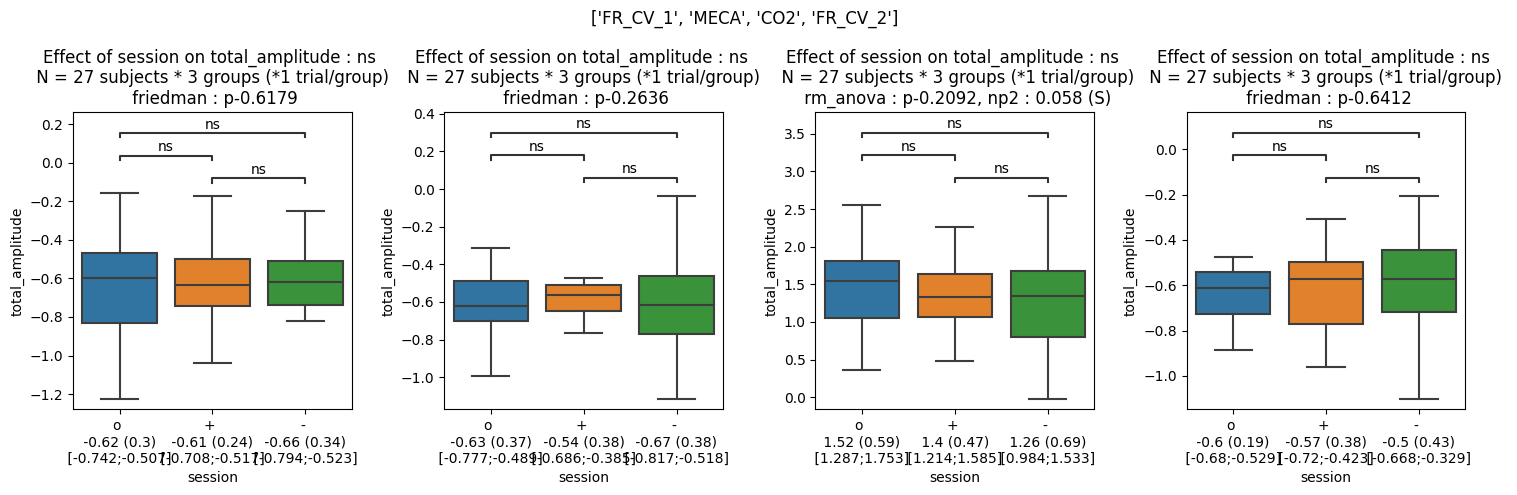

In [149]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_chunk.query(f"cond == '{cond}'")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

    plt.suptitle(f"{conditions}")
    plt.tight_layout()

## best sujet odor

['FR_CV_1', 'MECA', 'CO2', 'FR_CV_2']


/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_2961/3746976219.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/

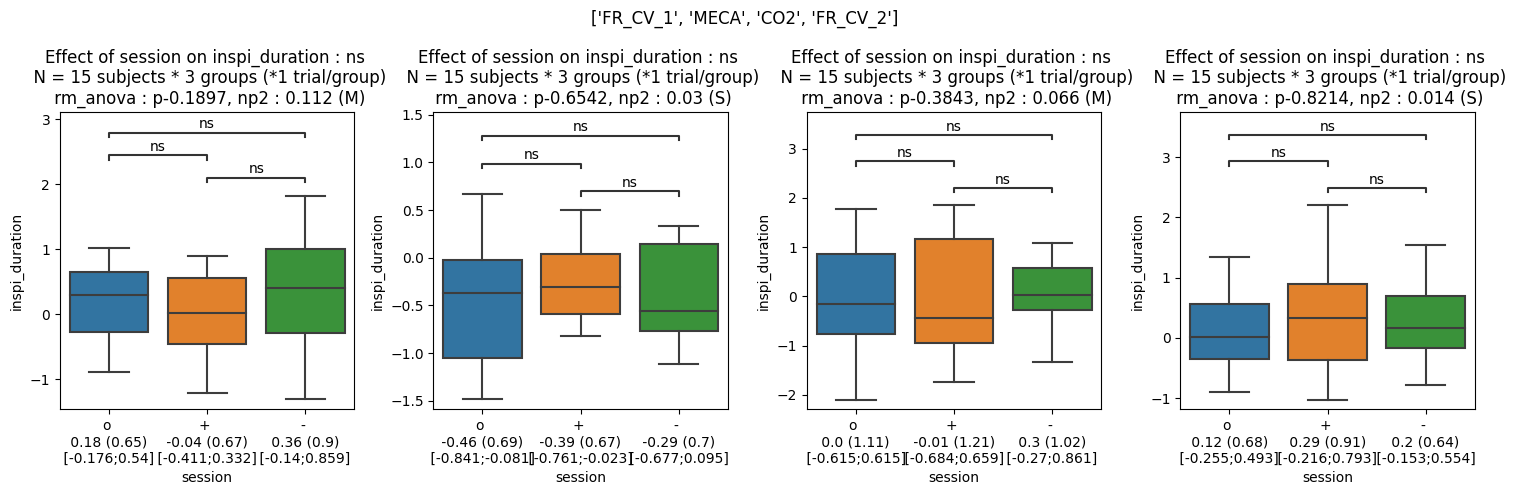

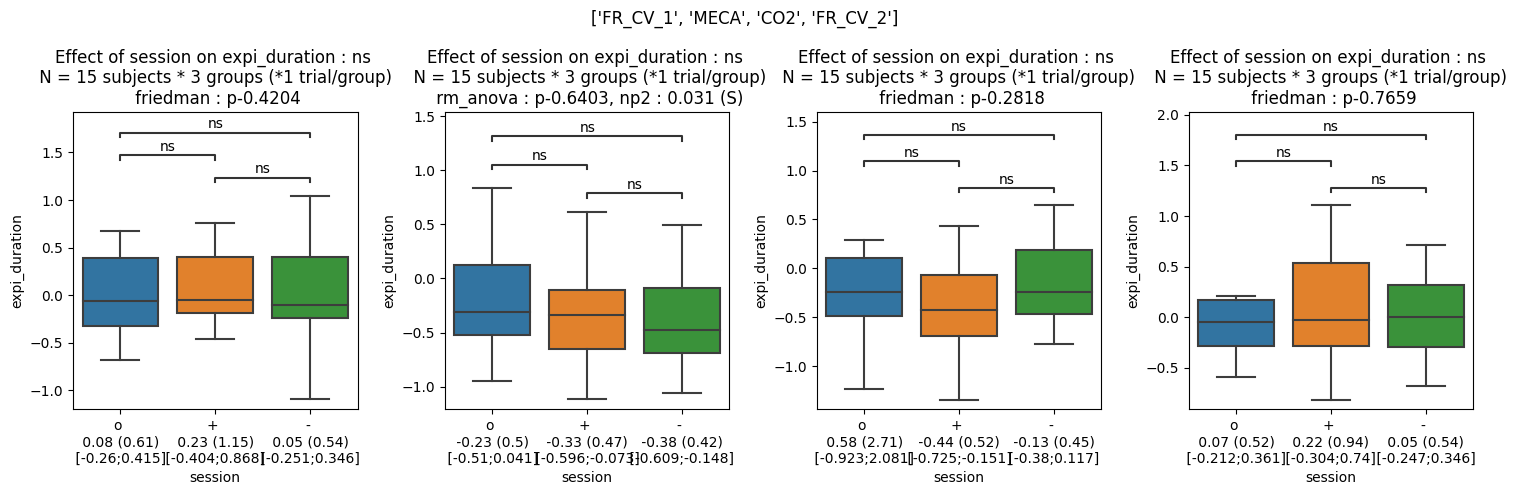

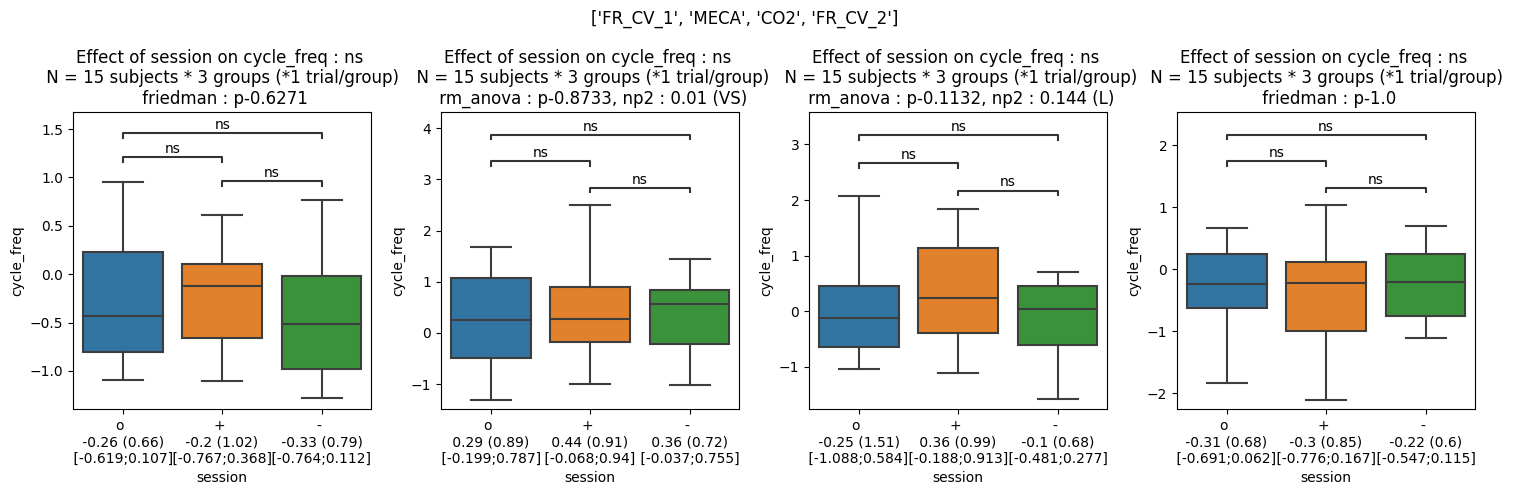

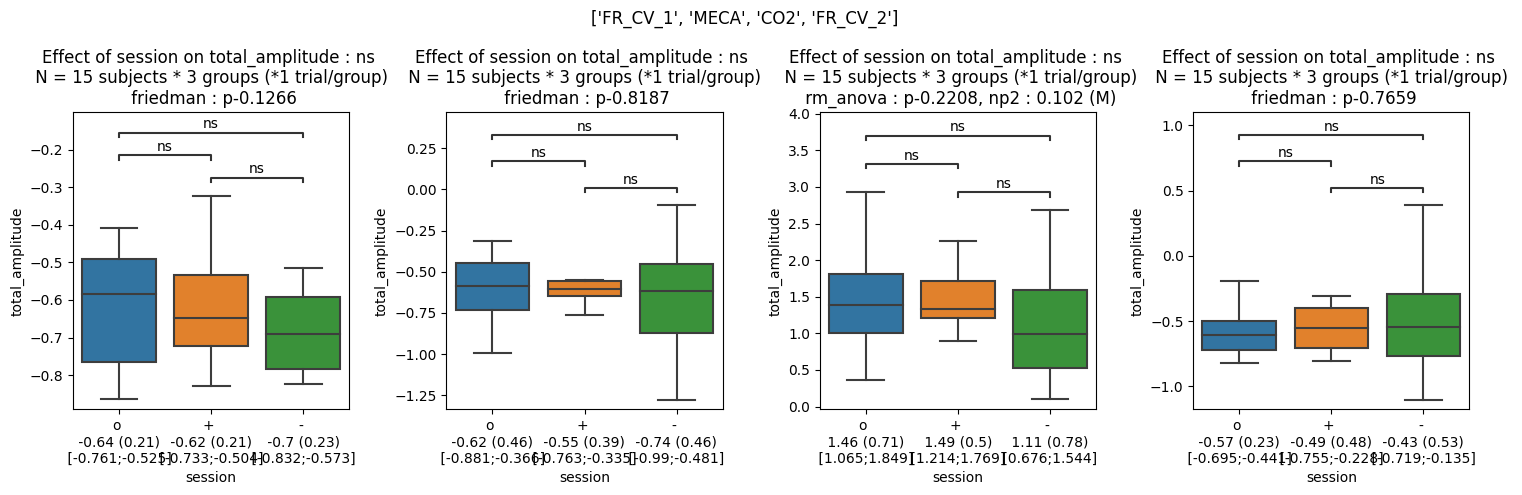

In [150]:
predictor = 'session' 

print(conditions)

for outcome_i in metric_list:

    fig, axs = plt.subplots(ncols=4)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    for c, cond in enumerate(conditions):
        
        ax = axs[c]
        df_stats = df_respi_chunk.query(f"cond == '{cond}' and sujet in {sujet_best_list.tolist()}")
        auto_stats(df_stats, predictor, outcome_i, ax=ax, subject='sujet', design='within', mode='box', transform=False, verbose=True, order=None)

        plt.suptitle(f"{conditions}")
        plt.tight_layout()

# PCA

## allsig respi

In [151]:
df_allsujet

sujet     cond session  inspi_duration  expi_duration  cycle_freq  \
0   01PD  FR_CV_1       o        3.156000       4.293081    0.148122   
0   01PD  FR_CV_1       +        2.425349       3.952372    0.174074   
0   01PD  FR_CV_1       -        1.836386       3.107333    0.217296   
0   01PD     MECA       o        3.006980       2.691959    0.186994   
0   01PD     MECA       +        2.532095       4.121952    0.179841   
..   ...      ...     ...             ...            ...         ...   
0   33MA      CO2       +        2.465018       2.499404    0.203683   
0   33MA      CO2       -        2.401123       2.528561    0.212464   
0   33MA  FR_CV_2       o        1.661373       1.794337    0.291934   
0   33MA  FR_CV_2       +        1.716487       1.898692    0.282535   
0   33MA  FR_CV_2       -        2.089387       2.476000    0.229212   

    total_amplitude select_best  
0          1.539592         YES  
0          2.176828         YES  
0          1.907390         YES  
0          1.483738         YES  
0          2.505508         YES  
..              ...         ...  
0          3.882571         YES  
0          4.878473         YES  
0          2.511541         YES  
0          3.133965         YES  
0          2.453490         YES  

[324 rows x 8 columns]

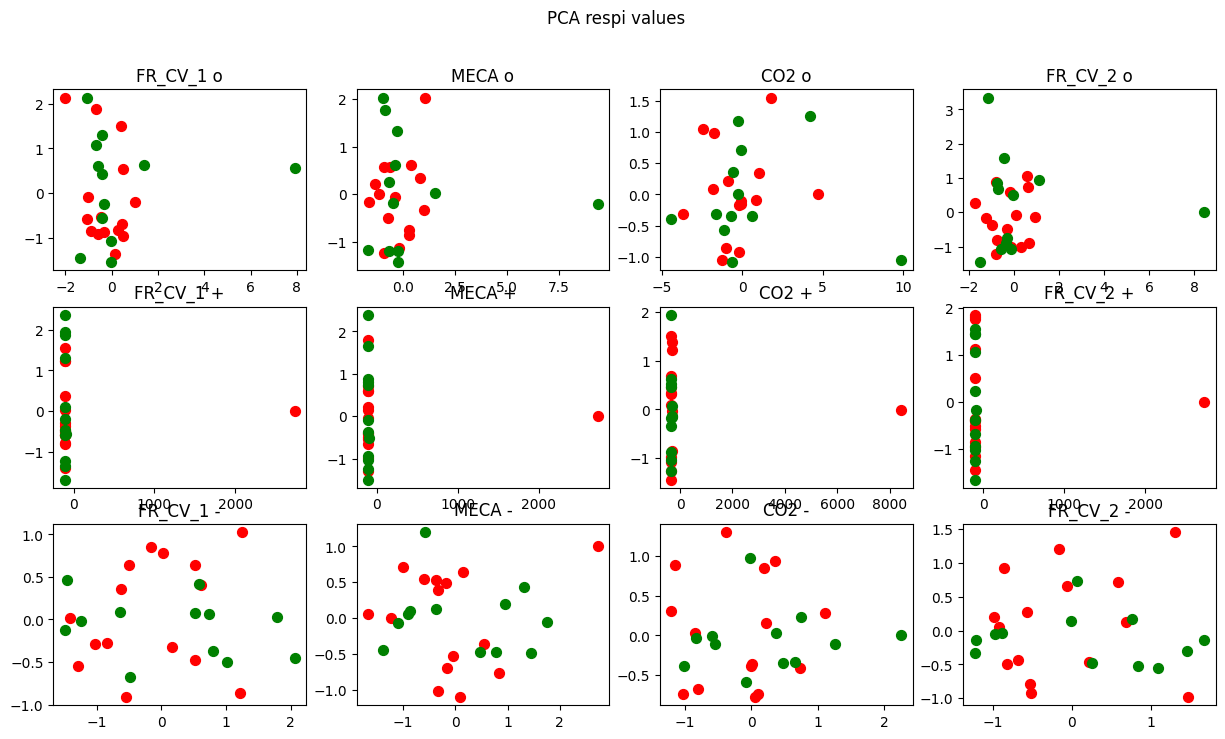

In [152]:
fig, axs = plt.subplots(ncols=len(conditions), nrows=len(odor_list))

for cond_i, cond in enumerate(conditions):

    for odor_i, odor in enumerate(odor_list):

        ax = axs[odor_i, cond_i]

        df_pca = df_allsujet.query(f"cond == '{cond}' and session == '{odor}'")
        X = df_pca[metric_list].values
        pca = PCA(n_components=2).fit_transform(X)
        df_pca_fit = pd.DataFrame(data = pca, columns = ['principal component 1', 'principal component 2'])

        ax.set_title(f"{cond} {odor}")
        targets = ['YES', 'NO']
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = df_pca['select_best'] == target
            ax.scatter(df_pca_fit.loc[indicesToKeep.values, 'principal component 1']
                    , df_pca_fit.loc[indicesToKeep.values, 'principal component 2'], c = color, s = 50)

plt.suptitle('PCA respi values')
fig.set_figheight(8)
fig.set_figwidth(15)

In [153]:
df_respi_paris

sujet     cond session        TI        Te      Ttot         BF        VT  \
0    01PD  FR_CV_1       o  2.393846  3.008462  5.402308  11.837491  0.562511   
1    03VN  FR_CV_1       o  2.692766  3.617660  6.310426   9.545615  1.157782   
2    05LV  FR_CV_1       o  2.435536  2.843929  5.279464  11.626768  0.567217   
3    06EF  FR_CV_1       o  1.649000  2.068875  3.717875  16.298862  0.493380   
4    07PB  FR_CV_1       o  1.304717  1.504906  2.809623  21.771218  0.649400   
..    ...      ...     ...       ...       ...       ...        ...       ...   
319  29SC  FR_CV_2       -  1.671310  1.872262  3.543571  17.294815  0.731305   
320  30AR  FR_CV_2       -  1.427614  1.934886  3.362500  18.019880  0.577633   
321  31HJ  FR_CV_2       -  1.783425  2.277945  4.061370  14.811920  0.796478   
322  32CM  FR_CV_2       -  1.853947  2.058684  3.912632  15.556511  0.727632   
323  33MA  FR_CV_2       -  2.374615  2.178154  4.552769  13.657869  0.505092   

            Ve     VT_Ti    Ti_Ttot     PRESS     PetCO2  VAS_S  VAS_A  \
0     6.121682  0.229809  44.118335 -1.814150  30.619312    NaN    NaN   
1    11.013808  0.430079  42.714931 -4.095677  41.109311    NaN    NaN   
2     6.446338  0.233685  46.081250 -2.445666  38.509328    NaN    NaN   
3     8.047073  0.300471  44.566152 -2.818668  31.008479    NaN    NaN   
4    13.772378  0.494112  46.423333 -4.087813  37.777710    NaN    NaN   
..         ...       ...        ...       ...        ...    ...    ...   
319  12.333833  0.435322  47.230747 -4.246468  37.879662    NaN    NaN   
320  10.280461  0.403985  42.511473 -3.152908  36.640867    NaN    NaN   
321  11.779759  0.446903  43.984879 -3.927595  37.493090    NaN    NaN   
322  11.142399  0.391526  47.546784 -3.904454  37.805881    NaN    NaN   
323   6.674845  0.216982  51.719452 -2.272483  34.220138    NaN    NaN   

    select_best  
0           YES  
1           YES  
2            NO  
3            NO  
4            NO  
..          ...  
319         YES  
320          NO  
321         YES  
322         YES  
323         YES  

[324 rows x 16 columns]

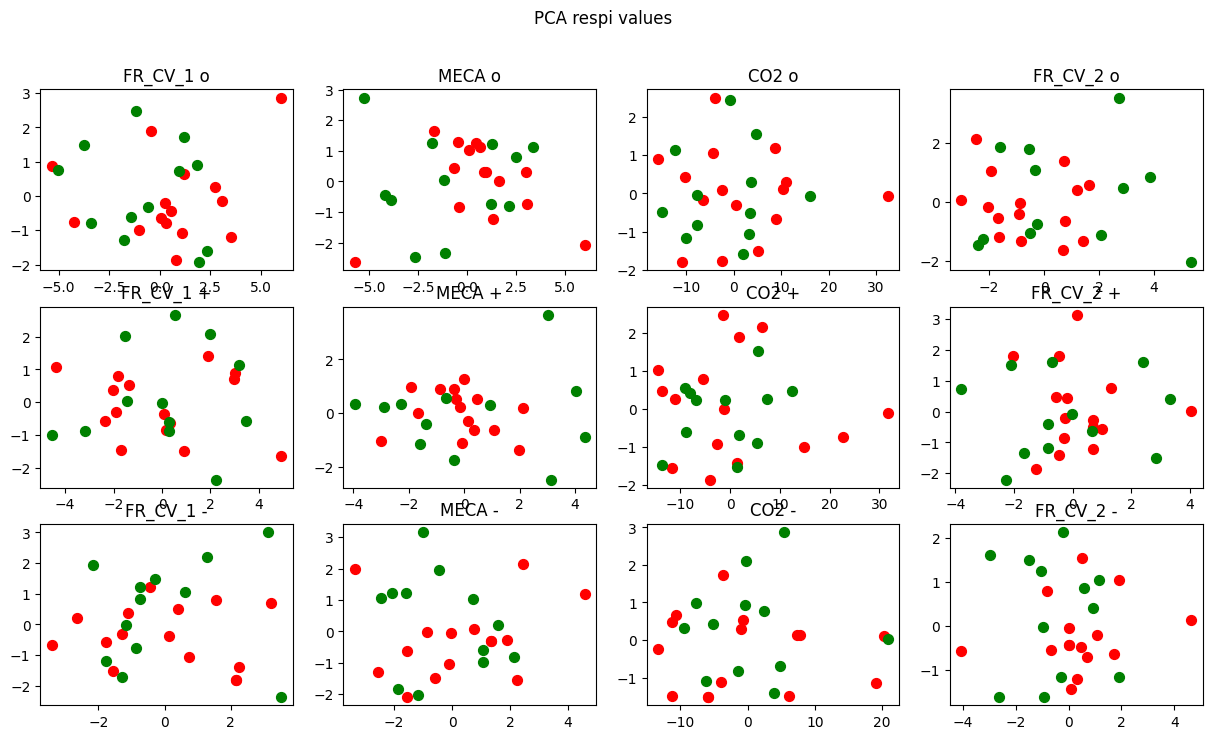

In [154]:
fig, axs = plt.subplots(ncols=len(conditions), nrows=len(odor_list))

for cond_i, cond in enumerate(conditions):

    for odor_i, odor in enumerate(odor_list):

        ax = axs[odor_i, cond_i]

        df_pca = df_respi_paris.query(f"cond == '{cond}' and session == '{odor}'")
        X = df_pca[['Ttot', 'VT', 'Ve']].values
        pca = PCA(n_components=2).fit_transform(X)
        df_pca_fit = pd.DataFrame(data = pca, columns = ['principal component 1', 'principal component 2'])

        ax.set_title(f"{cond} {odor}")
        targets = ['YES', 'NO']
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = df_pca['select_best'] == target
            ax.scatter(df_pca_fit.loc[indicesToKeep.values, 'principal component 1']
                    , df_pca_fit.loc[indicesToKeep.values, 'principal component 2'], c = color, s = 50)

plt.suptitle('PCA respi values')
fig.set_figheight(8)
fig.set_figwidth(15)

## 10s chunk

In [155]:
df_respi_chunk

sujet     cond session  inspi_duration  expi_duration  cycle_freq  \
0    PD01  FR_CV_1       o       -0.591034       1.793479   -0.969508   
1    PD01  FR_CV_1       +       -0.428171      -0.054890   -0.038945   
2    PD01  FR_CV_1       -       -0.665043      -0.136271    0.027086   
3    PD01     MECA       o       -0.373126      -0.501641    0.337275   
4    PD01     MECA       +       -0.447984      -0.622865    0.766484   
..    ...      ...     ...             ...            ...         ...   
319  MA33      CO2       +        1.719568       0.433227   -1.042136   
320  MA33      CO2       -        0.878969      -0.126962   -0.590992   
321  MA33  FR_CV_2       o       -0.271887      -0.308488    0.251000   
322  MA33  FR_CV_2       +       -1.024190      -0.813258    1.034552   
323  MA33  FR_CV_2       -       -0.211561      -0.250383    0.066013   

     total_amplitude  
0          -1.189791  
1          -0.657378  
2          -1.364645  
3          -1.946296  
4           0.679938  
..               ...  
319         1.125379  
320         0.657791  
321        -0.639528  
322         0.269948  
323         0.388686  

[324 rows x 7 columns]

In [156]:
sujet_sel_mask = []

for row_i in range(df_respi_chunk.shape[0]):

    if df_respi_chunk['sujet'].iloc[row_i] in sujet_best_list_rev:

        sujet_sel_mask.append('YES')

    else:

        sujet_sel_mask.append('NO')

df_respi_chunk['select_best'] = sujet_sel_mask
df_respi_chunk

sujet     cond session  inspi_duration  expi_duration  cycle_freq  \
0    PD01  FR_CV_1       o       -0.591034       1.793479   -0.969508   
1    PD01  FR_CV_1       +       -0.428171      -0.054890   -0.038945   
2    PD01  FR_CV_1       -       -0.665043      -0.136271    0.027086   
3    PD01     MECA       o       -0.373126      -0.501641    0.337275   
4    PD01     MECA       +       -0.447984      -0.622865    0.766484   
..    ...      ...     ...             ...            ...         ...   
319  MA33      CO2       +        1.719568       0.433227   -1.042136   
320  MA33      CO2       -        0.878969      -0.126962   -0.590992   
321  MA33  FR_CV_2       o       -0.271887      -0.308488    0.251000   
322  MA33  FR_CV_2       +       -1.024190      -0.813258    1.034552   
323  MA33  FR_CV_2       -       -0.211561      -0.250383    0.066013   

     total_amplitude select_best  
0          -1.189791          NO  
1          -0.657378          NO  
2          -1.364645          NO  
3          -1.946296          NO  
4           0.679938          NO  
..               ...         ...  
319         1.125379          NO  
320         0.657791          NO  
321        -0.639528          NO  
322         0.269948          NO  
323         0.388686          NO  

[324 rows x 8 columns]

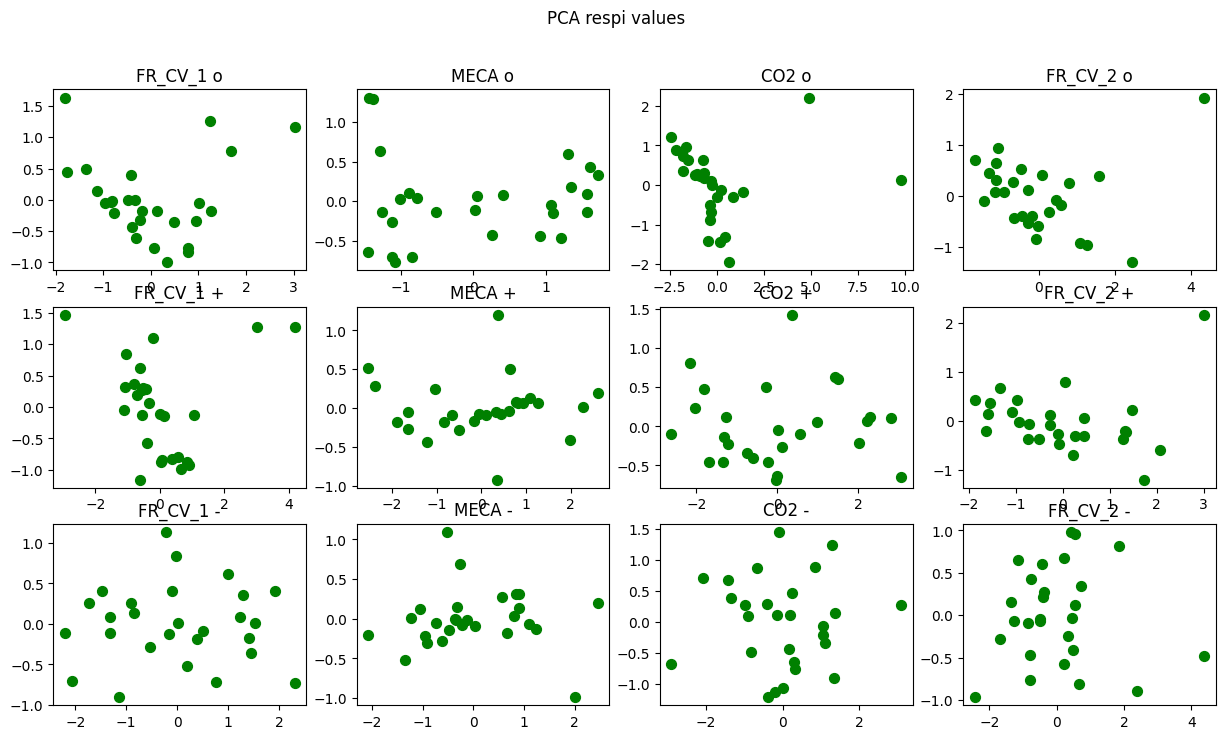

In [157]:
fig, axs = plt.subplots(ncols=len(conditions), nrows=len(odor_list))

for cond_i, cond in enumerate(conditions):

    for odor_i, odor in enumerate(odor_list):

        ax = axs[odor_i, cond_i]

        df_pca = df_respi_chunk.query(f"cond == '{cond}' and session == '{odor}'")
        X = df_pca[metric_list].values
        pca = PCA(n_components=2).fit_transform(X)
        df_pca_fit = pd.DataFrame(data = pca, columns = ['principal component 1', 'principal component 2'])

        ax.set_title(f"{cond} {odor}")
        targets = ['YES', 'NO']
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = df_pca['select_best'] == target
            ax.scatter(df_pca_fit.loc[indicesToKeep.values, 'principal component 1']
                    , df_pca_fit.loc[indicesToKeep.values, 'principal component 2'], c = color, s = 50)

plt.suptitle('PCA respi values')
fig.set_figheight(8)
fig.set_figwidth(15)